In [ ]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [60]:
# Define a class to receive the characteristics of each object detection
class Detection():
    def __init__(self):
        # number of frames history
        self.n_frames = 50
        
        # history of rectangles previous n frames
        self.prev_rects = []

    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > self.n_frames:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-self.n_frames:]

Number of vehicle images found: 8792
Number of non-vehicle images found: 8968


(-0.5, 437.5, 239.5, -0.5)

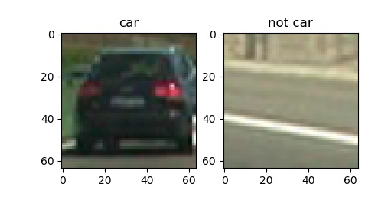

In [128]:
# Read in cars and notcars
    
# Load in the vehicle images to a list
vehicle_img_location = glob.glob('vehicles/*/*.png')
cars = []

# Read in a vehicle image
for f in vehicle_img_location:
    cars.append(f)
    
# Load in the non-vehicle images to a list
nonvehicle_img_location = glob.glob('non-vehicles/*/*.png')
notcars = []

# Read in a non-vehicle image
for f in nonvehicle_img_location:
    notcars.append(f)


print("Number of vehicle images found:", len(cars))
print("Number of non-vehicle images found:", len(notcars))

In [98]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                             pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                  pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

# define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

    #plt.savefig('output_images/car_notcar_example.jpg', dpi=100, bbox_inches='tight')

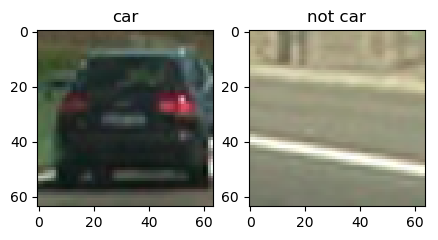

In [125]:
# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars)) #1676
notcar_ind = np.random.randint(0, len(notcars)) #3857

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, or 2 for this cell 
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, 
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, 
                                                  vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, 
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, 
                                                  vis=True)
                                                                                        
# Visualizer
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'not car image', 'not car HOG image']
fig = plt.figure(figsize=(12,3), dpi=100)
visualize(fig, 1, 4, images, titles)

In [ ]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
#n_samples = 1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(notcars)[random_idxs]
test_cars = cars 
test_notcars = notcars

car_features = extract_features(test_cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size, 
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_scaler = MinMaxScaler(feature_range=(0.1, 0.9)).fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
rand_state = 63
print("rand_state=", rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.25, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear Support Vector Classifier (SVC)
svc = LinearSVC(random_state=rand_state)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save model
data = {
    'svc': svc,
    'color_space': "YCrCb",
    'hog_channel': "ALL",
    'X_scaler': X_scaler,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins
}
pickle.dump(data, open("model_svc4.p", 'wb'))

In [ ]:
search_path = 'test_images/*.jpg'
example_images = glob.glob(search_path)
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    # Scale image (trained on PNGs, reading in JPG test images..)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    # obtain a list of windows to search within test image
    windows = slide_window(img, 
                           x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, 
                           xy_window=(96, 96), 
                           xy_overlap=(0.5, 0.5))
    
    # is there a car within the list of windows on the test image?
    hot_windows = search_windows(img, 
                                 windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space=color_space, 
                                 spatial_size=spatial_size, 
                                 hist_bins=hist_bins, 
                                 orient=orient, 
                                 pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, 
                                 spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, 
                                 hog_feat=hog_feat)   

    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)


In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)



In [ ]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5 #1.5

# Iterate over test images
for img_src in example_images:
    img_boxes = []
    t=time.time()
    count=0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    ctrans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    if scale != 1:
        img_shape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
        
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]        
    ch3 = ctrans_to_search[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step        
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell
            
            # Extract the sub-image patch
            sub_img = cv2.resize(ctrans_to_search[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            #spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make a prediction            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1,-1))
            
            # Predict if there is a car or not
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255), 4)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
            
    print(time.time()-t, 'seconds to run, total windows=', count)
            
    out_images.append(draw_img)
    #out_titles.append(img_src[-9:])
    #out_titles.append(img_src[-9:])
    out_titles.append('')
    out_titles.append('')
    #heatmap = 255*heatmap/np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

# Visualizer
fig = plt.figure(figsize=(12,24), dpi=100)
visualize(fig, 8, 2, out_images, out_titles)

In [132]:
# Load Support Vector Classifier from pickle file
model = pickle.load(open("model_svc3.p", "rb"))

# Load parameters
svc = model['svc']
color_space = model['color_space']
hog_channel = model['hog_channel']
X_scaler = model['X_scaler']
orient = model['orient']
pix_per_cell = model['pix_per_cell']
cell_per_block = model['cell_per_block']
spatial_size = model['spatial_size']
hist_bins = model['hist_bins']


# Iterate over test images
def find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):

    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    
    # Make a heatmap of zeros
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    ctrans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    if scale != 1:
        img_shape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
        
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]        
    ch3 = ctrans_to_search[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step        
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell
            
            # Extract the sub-image patch
            sub_img = cv2.resize(ctrans_to_search[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            #spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make a prediction            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1,-1))
            
            out = svc.decision_function(test_features)
            
            # Predict if there is a car or not
            test_prediction = svc.predict(test_features)
            
            if ((test_prediction == 1 and out > 1.0) or show_all_rectangles):
                #print(out)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [181]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 640
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)

print(len(rectangles), 'rectangles found in image')

14 rectangles found in image


In [182]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

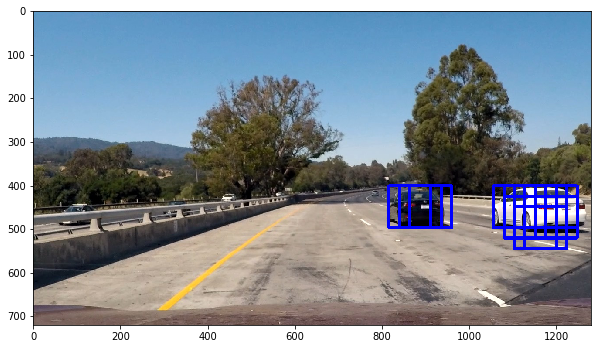

In [183]:
test_img = mpimg.imread('./test_images/test1.jpg')

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

Number of boxes (top row):  76
Number of boxes (bottom row):  76


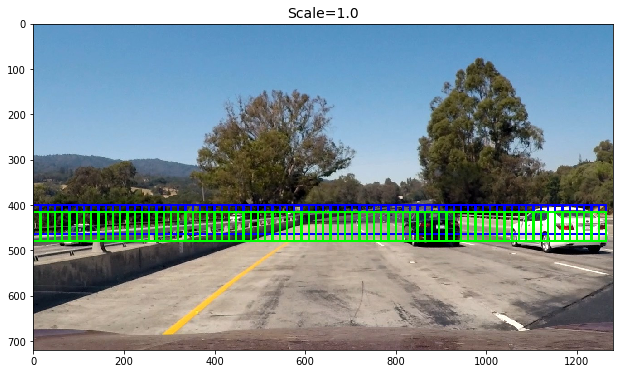

In [188]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row 
rects = []
ystart = 400 # pix_per_cell factors into ystart/ystop delta
ystop = 480
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# second row, reset to visualize different color
rects = []
ystart = 416
ystop = 496
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Scale=1.0', fontsize=14)
plt.savefig('output_images/search_window_scale1.0.jpg', dpi=100, bbox_inches='tight')

Number of boxes (top row):  49
Number of boxes (bottom row):  49


Text(0.5,1,'Scale=1.5')

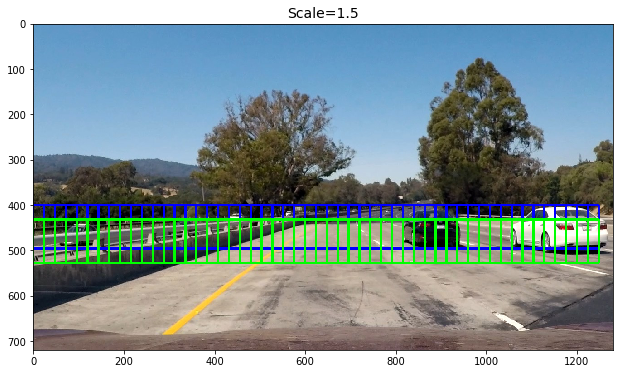

In [185]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row 
rects = []
ystart = 400 # pix_per_cell factors into ystart/ystop delta
ystop = 520
scale = 1.5
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# second row, reset to visualize different color
rects = []
ystart = 432
ystop = 552
scale = 1.5
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Scale=1.5', fontsize=14)

Number of boxes (top row):  36
Number of boxes (bottom row):  36


Text(0.5,1,'Scale=2.0')

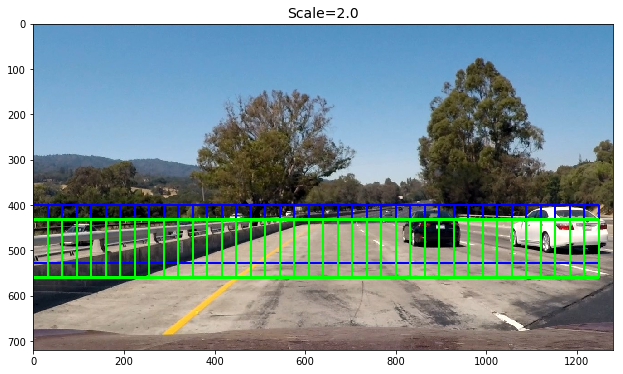

In [186]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row 
rects = []
ystart = 400 # pix_per_cell factors into ystart/ystop delta
ystop = 560
scale = 2.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# second row, reset to visualize different color
rects = []
ystart = 432
ystop = 592
scale = 2.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Scale=2.0', fontsize=14)

Number of boxes (top row):  28
Number of boxes (bottom row):  28


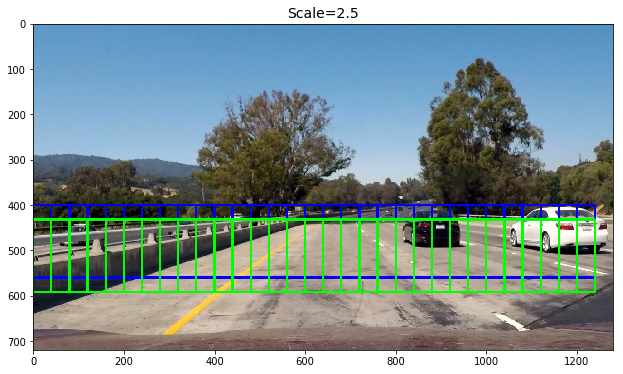

In [189]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row 
rects = []
ystart = 400 # pix_per_cell factors into ystart/ystop delta
ystop = 600
scale = 2.5
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# second row, reset to visualize different color
rects = []
ystart = 432
ystop = 632
scale = 2.5
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Scale=2.5', fontsize=14)
plt.savefig('output_images/search_window_scale2.5.jpg', dpi=100, bbox_inches='tight')

Total Number of boxes:  29


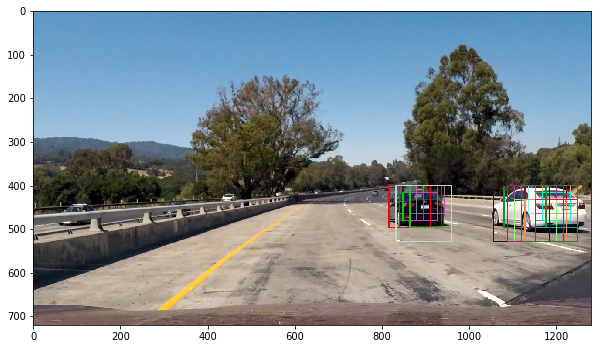

In [12]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 480
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 416
ystop = 496
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 400
ystop = 520
scale = 1.5
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 432 # + pix_per_cell
ystop = 552
scale = 1.5
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 400
ystop = 560
scale = 2.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 432 # + pix_per_cell
ystop = 592
scale = 2.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 400
ystop = 640
scale = 3.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)


ystart = 432 # + pix_per_cell
ystop = 572
scale = 3.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
rects.append(r)

# flatten a list of lists
rects = [item for sublist in rects for item in sublist] 

test_img_rects = draw_boxes(test_img, rects, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Total Number of boxes: ', len(rects))


In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0

    # Return updated heatmap
    return heatmap

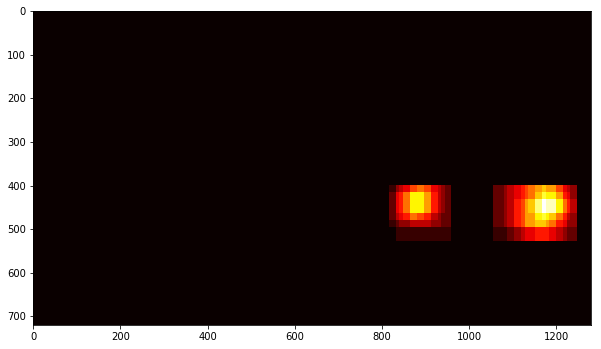

In [14]:
heatmap_img = np.zeros_like(test_img[:,:,0]).astype(np.float)
heatmap_img = add_heat(heatmap_img, rects)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


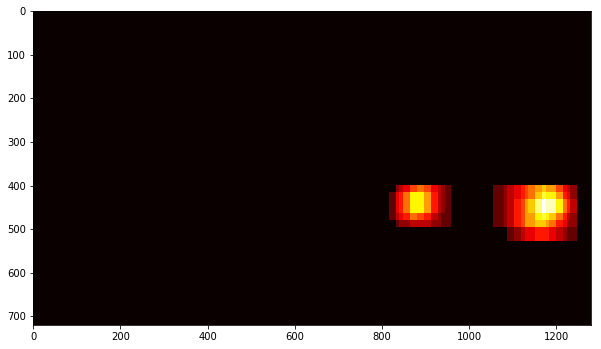

In [16]:
heatmap_thresh = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_thresh, cmap='hot')

2 cars found


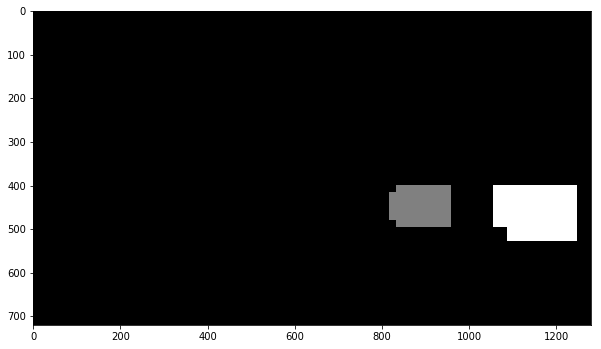

In [17]:
labels = label(heatmap_thresh)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

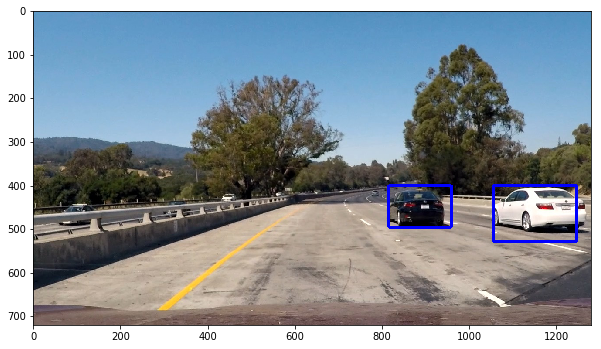

In [18]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)

    # Return the image
    return img, bboxes

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
    

In [64]:
def process_image(img):
    rects = []

    ystart = 400
    ystop = 480
    scale = 1.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 416
    ystop = 496
    scale = 1.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 520
    scale = 1.5
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432 
    ystop = 552
    scale = 1.5
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 560
    scale = 2.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 592
    scale = 2.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                    pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 640
    scale = 3.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 572
    scale = 3.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)

    # flatten a list of lists..
    rects = [item for sublist in rects for item in sublist] 
    
    #heatmap_img = np.zeros_like(test_img[:,:,0]).astype(np.float)
    #heatmap_img = add_heat(heatmap_img, rects)
    #heatmap_thresh = apply_threshold(heatmap_img, 2)
    #labels = label(heatmap_thresh)
    #draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    

    # add detections to the history
    if len(rects) > 0:
        det.add_rects(rects)
        
    #print(len(det.prev_rects), rects)
    # initial the detection history
    if len(det.prev_rects) > 49:
    
        heatmap_img = np.zeros_like(test_img[:,:,0]).astype(np.float)
    
        for rect_set in det.prev_rects:
            heatmap_img = add_heat(heatmap_img, rect_set)
        det_thresh = 1 + len(det.prev_rects)//2
        print(det_thresh, rects)
        heatmap_thresh = apply_threshold(heatmap_img, det_thresh)
    
#    plt.figure(figsize=(10,10))
#    plt.imshow(heatmap_thresh, cmap='hot')
    
    
        
    #median = cv2.medianBlur(heatmap_thresh, 11)
        labels = label(heatmap_thresh)
        draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img
    else:
        return img
    

    #return draw_img


In [66]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Class object for heat map
det = Detection()

test_output = 'output_video001.mp4'
#clip = VideoFileClip("test_video.mp4")
#clip = VideoFileClip("project_video.mp4").subclip(0,11)
clip = VideoFileClip("project_video.mp4")

test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[1.03527607]
[0.79298588]
[0.76279567]
[0.56168368]
[MoviePy] >>>> Building video test4d.mp4
[MoviePy] Writing video test4d.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

[1.03527607]
[0.79298588]
[0.76279567]
[0.56168368]


  0%|          | 1/1261 [00:02<53:42,  2.56s/it]

[0.55226636]
[0.77640385]
[0.76891938]
[0.81401119]
[1.12938084]
[1.40308329]
[0.93769429]


  0%|          | 2/1261 [00:05<54:01,  2.57s/it]

[0.66330475]
[0.98439196]
[1.38279702]
[1.37836116]
[0.54690718]
[0.61953145]


  0%|          | 3/1261 [00:07<53:32,  2.55s/it]

[0.94364119]
[0.53818357]
[2.11231696]
[0.95820164]
[2.35826343]


  1%|          | 7/1261 [00:19<1:02:32,  2.99s/it]

[0.52713378]


  1%|          | 12/1261 [00:34<56:32,  2.72s/it]  

[0.53012073]


  1%|          | 15/1261 [00:41<53:39,  2.58s/it]

[0.88780969]


  1%|▏         | 18/1261 [00:48<49:48,  2.40s/it]

[0.8043406]


  2%|▏         | 21/1261 [00:55<46:33,  2.25s/it]

[3.77876051]


  2%|▏         | 24/1261 [01:01<45:15,  2.20s/it]

[1.27267576]


  2%|▏         | 26/1261 [01:06<44:51,  2.18s/it]

[0.52218752]


  3%|▎         | 33/1261 [01:21<43:54,  2.15s/it]

[0.63676593]


  5%|▍         | 58/1261 [02:14<42:33,  2.12s/it]

[1.45861962]


  5%|▍         | 59/1261 [02:16<43:05,  2.15s/it]

[3.37982958]


  7%|▋         | 83/1261 [03:08<41:51,  2.13s/it]

[2.68303085]


  7%|▋         | 84/1261 [03:10<41:49,  2.13s/it]

[0.67936359]


  7%|▋         | 85/1261 [03:12<41:53,  2.14s/it]

[0.62637269]


  7%|▋         | 91/1261 [03:25<41:30,  2.13s/it]

[0.55416758]
[2.49666809]


  7%|▋         | 92/1261 [03:27<41:44,  2.14s/it]

[0.69296789]


  7%|▋         | 94/1261 [03:32<41:58,  2.16s/it]

[0.8027731]


  8%|▊         | 95/1261 [03:34<41:41,  2.15s/it]

[1.26130726]


  8%|▊         | 105/1261 [03:55<41:12,  2.14s/it]

[0.60367871]


  9%|▊         | 109/1261 [04:04<40:58,  2.13s/it]

[0.74286901]


 10%|▉         | 121/1261 [04:29<40:30,  2.13s/it]

[0.67840642]


 10%|▉         | 122/1261 [04:31<40:32,  2.14s/it]

[0.66956046]


 10%|▉         | 126/1261 [04:40<40:22,  2.13s/it]

[2.74912833]


 10%|█         | 128/1261 [04:44<40:16,  2.13s/it]

[0.51994194]


 10%|█         | 129/1261 [04:46<40:17,  2.14s/it]

[0.55855575]


 10%|█         | 131/1261 [04:51<40:19,  2.14s/it]

[0.54821311]
[0.80785293]


 10%|█         | 132/1261 [04:53<40:33,  2.16s/it]

[0.59383356]
[0.94121572]
[0.62630424]


 11%|█         | 133/1261 [04:55<40:46,  2.17s/it]

[1.01878242]
[1.14732651]


 11%|█         | 134/1261 [04:57<40:40,  2.17s/it]

[0.70580208]
[0.88257129]
[0.98184332]


 11%|█         | 135/1261 [04:59<40:38,  2.17s/it]

[0.53610182]
[1.32685776]
[0.69527383]
[0.87863329]


 11%|█         | 136/1261 [05:02<40:41,  2.17s/it]

[0.87221692]
[0.75514201]
[0.73218887]
[0.77564321]
[1.27445766]
[0.97050167]
[0.50491861]


 11%|█         | 137/1261 [05:04<40:33,  2.17s/it]

[1.28086602]
[0.65731824]
[0.53164325]
[1.23408445]
[0.83311179]
[1.54456947]
[1.0701814]


 11%|█         | 138/1261 [05:06<40:34,  2.17s/it]

[1.280637]
[0.81522836]


 12%|█▏        | 150/1261 [05:32<39:33,  2.14s/it]

[1.05887309]


 12%|█▏        | 151/1261 [05:34<39:33,  2.14s/it]

[0.534205]


 12%|█▏        | 154/1261 [05:40<39:33,  2.14s/it]

[0.51914857]


 13%|█▎        | 158/1261 [05:49<40:31,  2.20s/it]

[0.87763238]


 13%|█▎        | 159/1261 [05:51<40:12,  2.19s/it]

[0.61816864]


 13%|█▎        | 164/1261 [06:02<39:34,  2.16s/it]

[0.75588504]


 13%|█▎        | 165/1261 [06:04<39:19,  2.15s/it]

[0.64567778]
[0.64184058]


 13%|█▎        | 166/1261 [06:06<39:18,  2.15s/it]

[0.73358817]


 13%|█▎        | 167/1261 [06:08<39:43,  2.18s/it]

[0.83895464]


 13%|█▎        | 168/1261 [06:11<40:04,  2.20s/it]

[0.89553034]


 13%|█▎        | 169/1261 [06:13<40:09,  2.21s/it]

[1.00783648]


 13%|█▎        | 170/1261 [06:15<40:06,  2.21s/it]

[0.53223791]
[0.69110616]
[0.64137959]


 14%|█▎        | 171/1261 [06:17<40:19,  2.22s/it]

[0.99711674]
[0.575388]


 14%|█▎        | 172/1261 [06:20<40:13,  2.22s/it]

26 [((1184, 400), (1248, 464)), ((1120, 400), (1248, 528))]
[1.32767838]
[0.83966137]


 14%|█▎        | 173/1261 [06:22<40:13,  2.22s/it]

26 [((1200, 416), (1264, 480)), ((1120, 400), (1248, 528))]
[0.83303506]


 14%|█▍        | 174/1261 [06:24<39:54,  2.20s/it]

26 [((1120, 400), (1248, 528))]
[0.72920391]


 14%|█▍        | 175/1261 [06:26<39:38,  2.19s/it]

26 [((1120, 400), (1248, 528))]
[0.7246958]


 14%|█▍        | 176/1261 [06:28<39:44,  2.20s/it]

26 [((1120, 400), (1248, 528))]
[1.49299263]
[0.50218636]
[0.79437059]


 14%|█▍        | 177/1261 [06:31<39:41,  2.20s/it]

26 [((1168, 400), (1232, 464)), ((1128, 400), (1224, 496)), ((1120, 400), (1248, 528))]
[0.8782041]
[0.63775602]


 14%|█▍        | 178/1261 [06:33<39:28,  2.19s/it]

26 [((1168, 400), (1232, 464)), ((1120, 400), (1248, 528))]
[0.63503738]
[0.82607653]


 14%|█▍        | 179/1261 [06:35<41:36,  2.31s/it]

26 [((1168, 400), (1232, 464)), ((1184, 416), (1248, 480))]


 14%|█▍        | 180/1261 [06:38<41:18,  2.29s/it]

26 []
[0.56515867]


 14%|█▍        | 181/1261 [06:40<40:40,  2.26s/it]

26 [((1088, 400), (1216, 528))]
[0.58005602]
[0.55700904]
[0.53650011]


 14%|█▍        | 182/1261 [06:42<40:11,  2.24s/it]

26 [((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((1088, 400), (1216, 528))]


 15%|█▍        | 183/1261 [06:44<39:44,  2.21s/it]

26 []
[0.65484421]
[2.30857677]
[0.64520152]


 15%|█▍        | 184/1261 [06:46<39:48,  2.22s/it]

26 [((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((1088, 400), (1216, 528))]
[0.84711129]
[0.66962978]
[0.52487026]


 15%|█▍        | 185/1261 [06:49<39:43,  2.22s/it]

26 [((1152, 400), (1216, 464)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528))]
[0.56487492]
[1.12859876]
[0.98161814]


 15%|█▍        | 186/1261 [06:51<39:42,  2.22s/it]

26 [((1152, 400), (1216, 464)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.20897935]
[1.35329279]


 15%|█▍        | 187/1261 [06:53<39:24,  2.20s/it]

26 [((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.62565806]
[1.20983288]
[1.20685811]


 15%|█▍        | 188/1261 [06:55<39:28,  2.21s/it]

26 [((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.68758298]
[0.54467482]
[1.32003571]
[1.08730303]


 15%|█▍        | 189/1261 [06:57<39:28,  2.21s/it]

26 [((1184, 416), (1248, 480)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.64656254]
[1.3032134]
[1.24626279]


 15%|█▌        | 190/1261 [07:00<39:27,  2.21s/it]

26 [((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.2334995]
[1.1779692]
[0.90175805]


 15%|█▌        | 191/1261 [07:02<39:23,  2.21s/it]

26 [((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.52585628]
[1.30055326]
[1.26344445]


 15%|█▌        | 192/1261 [07:04<39:26,  2.21s/it]

26 [((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.37804056]
[1.08632634]


 15%|█▌        | 193/1261 [07:06<39:23,  2.21s/it]

26 [((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.51675272]
[1.02213558]
[0.54426874]
[0.78682527]
[0.57235741]
[0.83807105]
[1.14100861]


 15%|█▌        | 194/1261 [07:08<39:28,  2.22s/it]

26 [((320, 400), (384, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.75673093]
[0.88751145]
[0.9362786]
[0.71667307]
[0.80845138]
[1.23366847]


 15%|█▌        | 195/1261 [07:11<39:22,  2.22s/it]

26 [((1120, 400), (1184, 464)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.61097511]
[1.52729796]
[1.62715862]
[0.51184083]
[1.10166095]
[0.6825525]
[0.61594837]
[0.77004925]
[1.14485815]


 16%|█▌        | 196/1261 [07:13<39:33,  2.23s/it]

26 [((1120, 400), (1184, 464)), ((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[3.11750528]
[1.31342694]
[0.94468665]
[1.05559833]
[1.79504868]
[0.79882197]
[0.96134885]


 16%|█▌        | 197/1261 [07:15<39:33,  2.23s/it]

26 [((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.15771148]
[1.53250695]
[0.790773]
[0.91838562]
[1.97339203]
[0.61610323]
[0.52714533]
[0.82474371]


 16%|█▌        | 198/1261 [07:17<39:26,  2.23s/it]

26 [((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[3.37152453]
[0.84773113]
[0.9670511]
[1.64114936]
[0.62353093]


 16%|█▌        | 199/1261 [07:20<39:14,  2.22s/it]

26 [((1152, 400), (1216, 464)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[0.96400845]
[1.16337686]
[0.70226888]
[1.64308924]
[0.60755433]
[0.60349922]


 16%|█▌        | 200/1261 [07:22<39:23,  2.23s/it]

26 [((1168, 400), (1232, 464)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1120, 400), (1248, 528))]
[0.6028729]
[0.51323779]
[1.05868445]
[1.94449597]
[0.84001407]


 16%|█▌        | 201/1261 [07:24<39:17,  2.22s/it]

26 [((1136, 400), (1200, 464)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[1.64057161]
[0.54378185]
[1.01216171]
[0.90860792]
[2.40120833]
[0.66068904]
[0.98588206]


 16%|█▌        | 202/1261 [07:26<39:28,  2.24s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[1.82028779]
[1.03722627]
[0.86224926]
[1.04488615]
[2.34370001]
[0.76949702]
[0.84079646]


 16%|█▌        | 203/1261 [07:29<39:23,  2.23s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[0.72121745]
[1.88324713]
[1.40657832]
[0.71153981]
[0.81143658]
[1.58005793]
[2.39622056]
[0.53734024]
[1.23793131]
[0.67010243]


 16%|█▌        | 204/1261 [07:31<39:28,  2.24s/it]

26 [((1120, 400), (1184, 464)), ((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1080, 432), (1176, 528)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[0.51020837]
[0.89469726]
[1.98660803]
[1.57400403]
[0.91425653]
[1.63139936]
[2.67301062]
[1.68396337]
[1.27026083]
[0.84494333]


 16%|█▋        | 205/1261 [07:33<39:18,  2.23s/it]

26 [((1120, 400), (1184, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.7295245]
[1.70934417]
[0.96373651]
[0.57682671]
[1.58745227]
[1.0081299]
[1.70208858]
[1.41481897]
[0.78870103]
[1.16005201]
[1.02199663]


 16%|█▋        | 206/1261 [07:35<39:13,  2.23s/it]

26 [((1120, 400), (1184, 464)), ((1200, 400), (1264, 464)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.69114006]
[1.31944828]
[1.66622986]
[1.07170095]
[1.47751855]
[0.96155895]
[1.35638624]
[1.27847851]
[1.43523388]
[0.8298533]
[1.12019777]
[1.00190506]


 16%|█▋        | 207/1261 [07:37<39:14,  2.23s/it]

26 [((1120, 400), (1184, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((960, 432), (1056, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.65844299]
[1.62287779]
[1.91202864]
[0.62645493]
[1.11591387]
[1.31540705]
[0.78591451]
[1.03732254]
[0.96985369]


 16%|█▋        | 208/1261 [07:40<39:11,  2.23s/it]

26 [((1120, 400), (1184, 464)), ((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.74145277]
[0.56324483]
[1.30855832]
[0.6051869]
[0.92118637]
[0.81048878]
[1.29696143]
[0.86085001]
[1.02686619]
[1.03065652]


 17%|█▋        | 209/1261 [07:42<39:34,  2.26s/it]

26 [((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[2.25098574]
[2.02318429]
[2.16001279]
[1.48292279]
[1.29823027]
[0.97211158]
[1.00550445]
[0.8526534]
[0.87328252]
[1.06610509]


 17%|█▋        | 210/1261 [07:44<39:18,  2.24s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.7908406]
[0.75298274]
[1.57029503]
[0.86253976]
[1.75562334]
[1.02989509]
[0.54953347]
[0.86493785]
[0.68171128]
[1.01255783]
[0.71951986]


 17%|█▋        | 211/1261 [07:46<39:15,  2.24s/it]

26 [((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1152, 400), (1248, 496)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.55521346]
[1.43838041]
[0.64786448]
[0.94396674]
[0.70580844]
[0.70273582]
[0.7463982]
[0.84141575]
[0.59570509]
[0.6943066]


 17%|█▋        | 212/1261 [07:49<39:16,  2.25s/it]

26 [((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.26887425]
[1.5796664]
[0.73514865]
[1.18298078]
[1.09542295]
[0.82700021]
[0.99970688]
[0.59148123]
[0.64467168]
[0.68983034]
[0.80724731]
[0.7222149]


 17%|█▋        | 213/1261 [07:51<39:17,  2.25s/it]

26 [((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((144, 432), (240, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.28018699]
[1.31113496]
[1.04012463]
[1.0215754]
[1.32722757]
[0.86937556]
[0.52864896]
[0.93077389]
[0.75558122]
[0.75667403]


 17%|█▋        | 214/1261 [07:53<39:03,  2.24s/it]

26 [((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.65074604]
[0.9252681]
[0.77973592]
[1.01521932]
[0.72094218]
[1.38492822]
[0.7186311]
[0.65091255]
[0.75962539]
[1.07597168]
[0.9791513]
[0.91141759]


 17%|█▋        | 215/1261 [07:55<39:09,  2.25s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((504, 432), (600, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.99269985]
[1.02373092]
[1.61132327]
[0.90919357]
[1.91308058]
[1.19059162]
[1.65989945]
[1.33962044]
[1.4373286]
[1.20301228]
[1.0746115]
[0.61542341]


 17%|█▋        | 216/1261 [07:58<39:05,  2.24s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[0.80967372]
[1.88950703]
[0.65029615]
[0.80751294]
[1.55562077]
[1.16702176]
[1.3088665]
[1.24896922]
[0.91402078]
[1.16411142]
[0.76682268]
[1.28549261]
[1.18753538]
[1.03836831]
[0.60467009]


 17%|█▋        | 217/1261 [08:00<39:01,  2.24s/it]

26 [((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1136, 416), (1200, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.86454884]
[1.30340996]
[1.84121508]
[0.73225163]
[1.40906519]
[0.99961687]
[0.79540608]
[0.89751612]
[1.23586185]
[1.3062352]
[0.96476609]
[1.4756966]
[1.09721368]
[1.1577656]
[0.58694302]


 17%|█▋        | 218/1261 [08:02<38:58,  2.24s/it]

26 [((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[0.71510399]
[1.83269151]
[0.76484348]
[0.59967017]
[1.58174091]
[1.51752458]
[0.984667]
[0.88564404]
[0.80979462]
[1.52497902]
[0.89986827]
[1.11436394]
[0.52653027]


 17%|█▋        | 219/1261 [08:04<38:54,  2.24s/it]

26 [((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1080, 432), (1176, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.09455991]
[1.72066731]
[0.74184525]
[0.78445531]
[1.95510133]
[0.66996291]
[2.16638098]
[1.72608686]
[1.01493248]
[0.91242689]
[1.58623525]
[0.84276596]
[1.36716958]


 17%|█▋        | 220/1261 [08:07<39:03,  2.25s/it]

26 [((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.92085314]
[0.72057282]
[1.16184685]
[0.568515]
[1.8077028]
[1.64311138]
[1.12306998]
[0.99853494]
[1.13929776]
[0.89467518]
[1.27316497]


 18%|█▊        | 221/1261 [08:09<38:52,  2.24s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.68575754]
[0.69470426]
[1.39409901]
[1.12700521]
[1.58419837]
[1.61162967]
[1.28296264]
[1.10639443]
[1.14011612]
[0.70400647]
[0.93968247]


 18%|█▊        | 222/1261 [08:11<38:53,  2.25s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.72589729]
[0.5995284]
[2.83955117]
[1.54058723]
[0.61152053]
[0.55186794]
[1.53921339]
[1.57575772]
[0.85842025]
[1.13966717]
[1.55055039]
[0.80867463]
[0.98676268]


 18%|█▊        | 223/1261 [08:13<38:48,  2.24s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.54134917]
[1.25929551]
[0.57414112]
[0.6338301]
[1.9571171]
[0.54054624]
[1.33067624]
[1.8234129]
[1.39779208]
[1.0881852]
[1.25504906]
[0.92535828]
[0.95007058]
[0.78990076]


 18%|█▊        | 224/1261 [08:16<39:01,  2.26s/it]

26 [((1136, 400), (1200, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[2.00055583]
[1.35406535]
[0.76496104]
[2.72915099]
[0.81850513]
[1.75186495]
[1.93191268]
[1.09611819]
[1.19416017]
[0.87674116]
[0.59893151]
[0.94350175]


 18%|█▊        | 225/1261 [08:18<38:46,  2.25s/it]

26 [((1136, 400), (1200, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.5074635]
[1.15089132]
[0.62920365]
[1.33271493]
[0.77629235]
[0.54272758]
[1.16548304]
[1.64757143]
[1.45598837]
[1.02725066]
[0.97245263]
[0.78407596]
[0.74262713]


 18%|█▊        | 226/1261 [08:20<38:46,  2.25s/it]

26 [((1136, 400), (1200, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.67213834]
[1.37408628]
[1.19322469]
[0.63983043]
[0.92402887]
[1.04589586]
[0.51167391]
[0.52562705]
[1.36669368]
[1.07326381]
[0.60704622]
[1.39562958]
[0.74379197]
[0.99358407]
[0.93216116]


 18%|█▊        | 227/1261 [08:22<38:36,  2.24s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.14685301]
[1.49022565]
[0.97608863]
[0.60014981]
[0.88505927]
[0.75174646]
[0.51505042]
[0.56749947]
[1.19591157]
[1.36561905]
[1.3599361]
[0.66414868]
[0.77868675]
[0.82151495]
[0.61169571]


 18%|█▊        | 228/1261 [08:25<38:46,  2.25s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.6752975]
[0.86246805]
[0.71364874]
[0.50403002]
[0.50499858]
[0.91672162]
[1.0014766]
[1.12165453]
[1.736065]
[0.5815801]
[0.5480819]
[0.88964463]
[0.9191105]


 18%|█▊        | 229/1261 [08:27<38:48,  2.26s/it]

26 [((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1200, 416), (1264, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[0.55579343]
[1.56460498]
[0.83595244]
[0.68025749]
[0.65949773]
[0.91543353]
[0.72195701]
[0.97344572]
[0.74199812]
[1.19075348]
[0.97210158]
[1.07418114]
[1.24118438]
[1.67474755]
[0.94547149]
[0.81835652]
[0.80442618]
[0.77337301]


 18%|█▊        | 230/1261 [08:29<38:42,  2.25s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.33046216]
[1.67286567]
[0.59864504]
[0.55306026]
[0.62901378]
[0.5395512]
[0.71617303]
[1.47971381]
[1.41201187]
[0.94527471]
[0.75827826]
[1.16905555]
[1.65833643]
[1.14958949]
[0.54184969]
[0.96640728]
[0.89643573]


 18%|█▊        | 231/1261 [08:31<38:39,  2.25s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1120, 416), (1184, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.04567187]
[1.51294534]
[0.84582596]
[0.50599749]
[0.82084064]
[0.95187217]
[0.99909517]
[0.96462156]
[1.07834812]
[1.04003951]
[0.96231792]
[0.85727967]
[1.10350874]


 18%|█▊        | 232/1261 [08:34<38:25,  2.24s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.67226226]
[1.25654371]
[1.0084112]
[1.58987014]
[0.55062975]
[0.5080864]
[0.546194]
[1.44779805]
[1.32034855]
[1.14456938]
[1.37799448]
[0.99602312]
[1.17981273]
[0.93119653]
[1.31635457]


 18%|█▊        | 233/1261 [08:36<38:34,  2.25s/it]

26 [((1088, 400), (1152, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.61257461]
[1.78187166]
[1.48013024]
[0.72674019]
[3.39411608]
[0.51108599]
[0.6193469]
[0.83171428]
[1.49764989]
[1.01612476]
[1.26389141]
[0.84725605]
[0.76582704]
[1.23450359]
[1.07159784]
[1.33191312]


 19%|█▊        | 234/1261 [08:38<38:30,  2.25s/it]

26 [((1088, 400), (1152, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.74919788]
[1.22802483]
[0.71994999]
[2.37010677]
[2.83865826]
[0.88526362]
[0.62185528]
[0.72169281]
[1.96656897]
[1.18304324]
[1.35692758]
[9.67223639]
[1.26013539]
[1.12478018]
[1.23201107]
[1.07600881]
[1.3595027]


 19%|█▊        | 235/1261 [08:40<38:32,  2.25s/it]

26 [((1104, 400), (1168, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((624, 432), (720, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.78067763]
[1.34457633]
[0.86820442]
[1.51510686]
[1.1821389]
[1.04247029]
[1.31741969]
[1.35490601]
[1.0179698]
[1.27667111]
[0.50000817]
[0.50304024]
[0.51246719]
[0.91110661]
[1.32322592]
[1.12660027]
[1.27261421]


 19%|█▊        | 236/1261 [08:43<38:27,  2.25s/it]

26 [((1120, 400), (1184, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((480, 432), (576, 528)), ((1056, 432), (1152, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.79672031]
[1.30473885]
[0.70649887]
[0.72180207]
[1.62638352]
[0.85062906]
[0.52087157]
[0.72479561]
[1.44506612]
[1.21541271]
[1.13487678]
[1.49548128]
[0.6659056]
[0.57074864]
[1.03285366]
[1.22004845]
[1.29608697]


 19%|█▉        | 237/1261 [08:45<38:27,  2.25s/it]

26 [((1120, 400), (1184, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((984, 400), (1080, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.15683986]
[1.25122447]
[0.56124571]
[0.93009732]
[1.24020315]
[0.95658348]
[1.32651809]
[1.65440142]
[1.01506181]
[1.08277161]
[1.1833896]
[1.26082858]
[1.21861532]
[1.2342527]


 19%|█▉        | 238/1261 [08:47<38:34,  2.26s/it]

26 [((1120, 400), (1184, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.39555879]
[0.77551651]
[1.66581494]
[0.88894382]
[1.68606155]
[1.55753531]
[0.94491956]
[1.00281715]
[0.67622408]
[1.32557537]
[0.84298865]
[0.56847192]
[0.99184623]
[1.24388621]
[1.35910476]


 19%|█▉        | 239/1261 [08:50<38:39,  2.27s/it]

26 [((1120, 400), (1184, 464)), ((1168, 400), (1232, 464)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.64562495]
[0.56642292]
[2.29380896]
[1.09259563]
[0.90229915]
[0.94533306]
[0.88996314]
[0.73727013]
[2.19881272]
[1.64444033]
[1.33606215]
[1.23083066]
[1.45140399]
[0.75684994]
[1.01476303]
[1.18278794]
[1.45597479]


 19%|█▉        | 240/1261 [08:52<38:44,  2.28s/it]

26 [((96, 400), (160, 464)), ((224, 400), (288, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.69796491]
[0.73004598]
[0.71426211]
[1.50086464]
[0.837958]
[1.03724511]
[1.55160743]
[1.17407581]
[1.2499565]
[1.24982526]
[0.78345228]
[0.94549205]
[0.98788445]
[1.45758245]
[0.6025315]


 19%|█▉        | 241/1261 [08:54<38:37,  2.27s/it]

26 [((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[2.48831372]
[0.88723373]
[1.63844818]
[0.82690713]
[1.75438282]
[1.22591354]
[0.5839596]
[0.86737197]
[1.25848597]
[1.37114977]
[1.51783281]
[1.29209957]
[1.37246984]
[0.76918829]
[1.03343171]
[1.84362074]
[0.52233469]


 19%|█▉        | 242/1261 [08:56<38:30,  2.27s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.04281658]
[1.28165517]
[1.64455862]
[0.83596458]
[1.49700045]
[1.30257242]
[0.74171147]
[1.16773225]
[1.33939746]
[1.55077468]
[1.57302722]
[1.1797734]
[1.01945335]
[0.65003386]
[0.95343339]
[1.6517525]


 19%|█▉        | 243/1261 [08:59<38:24,  2.26s/it]

26 [((80, 400), (144, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.1984338]
[1.75760847]
[0.81975545]
[0.54262022]
[1.0332225]
[0.84033897]
[0.51271031]
[0.8531454]
[1.27394488]
[1.40481636]
[1.32983239]
[1.45294013]
[1.2489773]
[1.16179467]
[0.82923698]
[0.9545511]
[1.70462752]


 19%|█▉        | 244/1261 [09:01<38:25,  2.27s/it]

26 [((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.4989616]
[1.37573336]
[1.79903953]
[0.86076002]
[0.58266983]
[0.82656329]
[1.73039448]
[1.20072839]
[1.58367029]
[0.97761836]
[0.5338353]
[1.33108909]
[0.61274805]
[0.84044375]
[0.56923746]
[1.60145441]


 19%|█▉        | 245/1261 [09:03<38:17,  2.26s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((480, 432), (576, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.13546199]
[1.122768]
[2.25248018]
[1.58843526]
[0.50454416]
[0.8473988]
[0.86301392]
[0.50460086]
[0.59676901]
[0.90607634]
[1.60086413]
[1.07652551]
[1.86677621]
[0.88862834]
[1.23689562]
[1.16002653]
[0.92314151]
[0.97964236]
[1.7324777]


 20%|█▉        | 246/1261 [09:05<38:16,  2.26s/it]

26 [((64, 400), (128, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.47985326]
[1.6229271]
[0.64728273]
[0.83993566]
[0.99727146]
[1.39659618]
[1.07571251]
[1.58393547]
[0.81062732]
[0.63356542]
[1.48705312]
[1.03295028]
[0.9407936]
[0.87919834]
[1.68581466]


 20%|█▉        | 247/1261 [09:08<38:34,  2.28s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[3.30049533]
[1.46832076]
[0.58891042]
[2.99303019]
[1.23932837]
[1.0641501]
[1.26269174]
[1.39188655]
[1.52482073]
[0.82272739]
[0.74260431]
[1.38376783]
[1.4100948]
[0.98230406]
[0.98669795]
[1.84246102]


 20%|█▉        | 248/1261 [09:10<39:43,  2.35s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.26965997]
[0.52017415]
[0.66832359]
[1.42983757]
[1.45373391]
[0.63192439]
[1.41041256]
[0.66397338]
[1.24260554]
[1.20570286]
[1.09837606]
[0.71848924]
[0.74541447]
[1.03989261]
[1.54849983]
[0.65920708]
[0.87077832]
[1.43770894]


 20%|█▉        | 249/1261 [09:13<39:26,  2.34s/it]

26 [((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.15719345]
[0.69616077]
[1.34895939]
[2.38598505]
[1.2433771]
[1.4186202]
[0.53429091]
[1.18969868]
[0.73622254]
[1.2806813]
[0.82986894]
[0.78350434]
[0.83414287]
[1.62836828]
[0.60180858]
[0.71329344]
[1.36456053]


 20%|█▉        | 250/1261 [09:15<39:02,  2.32s/it]

26 [((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.70346488]
[0.61988409]
[0.99780875]
[0.87862053]
[0.61955976]
[0.66138143]
[1.78419643]
[1.08225308]
[0.60443227]
[1.50224112]
[0.51615537]
[1.27792075]
[1.12020915]
[1.34937478]
[0.81229715]
[1.19620666]
[0.66367519]
[1.04596351]
[1.42617413]
[0.71785185]
[0.87810103]
[1.06777747]


 20%|█▉        | 251/1261 [09:17<39:55,  2.37s/it]

26 [((912, 400), (976, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((992, 416), (1056, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((144, 432), (240, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[2.0726378]
[0.63891264]
[0.91214072]
[0.8825109]
[1.40521423]
[0.61595177]
[1.23696319]
[0.75464555]
[1.56727329]
[0.90883941]
[1.19292986]
[0.62926533]
[1.1901099]
[0.84056652]
[1.20025598]
[0.61913063]
[0.93402801]
[1.11241579]
[0.54694]


 20%|█▉        | 252/1261 [09:20<40:22,  2.40s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[2.00196611]
[0.60803508]
[0.73902861]
[0.61451183]
[1.42609813]
[0.95895074]
[1.20806939]
[1.29410155]
[1.84957284]
[1.16710804]
[1.20258011]
[0.78644534]
[1.10621032]
[0.70823488]
[0.9847387]
[0.7856151]
[0.94724002]
[1.14667959]
[0.55505411]


 20%|██        | 253/1261 [09:22<40:35,  2.42s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[2.05904674]
[0.74319176]
[0.86028745]
[0.55901686]
[1.52350501]
[0.70366498]
[0.50247883]
[0.66150645]
[1.68987585]
[1.20042767]
[1.14925136]
[0.82228869]
[2.11102143]
[1.20296707]
[1.05301685]
[0.55628395]
[0.96960652]
[0.74956075]
[0.8277479]
[0.68224662]


 20%|██        | 254/1261 [09:25<40:21,  2.40s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((552, 432), (648, 528)), ((576, 432), (672, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.56138354]
[1.07524034]
[0.66236206]
[0.85267338]
[0.64046097]
[0.72922984]
[1.0723981]
[1.39061112]
[1.30177867]
[1.23312498]
[0.83841606]
[0.97420431]
[0.95321704]
[0.50368443]
[0.72267493]
[1.0286199]
[0.64784251]


 20%|██        | 255/1261 [09:27<40:05,  2.39s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.7011834]
[1.18010398]
[0.58992969]
[0.99748758]
[1.16532219]
[1.02195024]
[1.07974405]
[1.46550358]
[0.94019081]
[1.92684392]
[0.92846542]
[1.14586971]
[0.68701387]
[0.51631565]
[1.08696747]


 20%|██        | 256/1261 [09:29<39:15,  2.34s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((696, 432), (792, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.65120865]
[0.6805534]
[0.74042497]
[1.04304289]
[1.12716225]
[1.13904536]
[1.29288901]
[1.56827643]
[0.975504]
[0.62606616]
[0.62780808]
[0.51555829]
[0.88212092]
[0.72197558]
[0.88092619]


 20%|██        | 257/1261 [09:31<38:53,  2.32s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1032, 432), (1128, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
[1.111173]
[1.67884091]
[0.84836939]
[0.83121158]
[1.46893951]
[1.27911319]
[1.22022088]
[1.30013351]
[1.33440437]
[0.57544734]
[0.57522693]
[0.91044785]
[0.57090886]
[0.83663983]


 20%|██        | 258/1261 [09:34<39:01,  2.33s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
[0.54545483]
[1.48429564]
[0.57705002]
[0.79671364]
[0.85222613]
[1.844416]
[1.21262349]
[1.00103258]
[1.51390697]
[1.36789445]
[0.62593562]
[0.56349183]
[0.61339627]
[0.9360212]


 21%|██        | 259/1261 [09:36<39:38,  2.37s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
[1.00391421]
[1.21985088]
[1.6940236]
[0.62971847]
[1.26639671]
[0.82519871]
[1.94275412]
[1.09042503]
[1.06568188]
[1.40276185]
[1.51176298]
[0.52430225]
[1.01909113]
[0.81828634]
[1.03074663]


 21%|██        | 260/1261 [09:39<39:04,  2.34s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
[1.24321845]
[1.54487044]
[1.41370234]
[1.71410795]
[0.71963104]
[1.09224708]
[0.56792081]
[1.46826083]
[1.71374416]
[1.2340738]
[1.70995615]
[1.91807873]
[0.76222796]
[1.12114125]
[0.85756667]
[0.72916804]
[0.80871184]


 21%|██        | 261/1261 [09:41<38:40,  2.32s/it]

26 [((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.96410736]
[2.00658716]
[1.7525015]
[1.60849522]
[0.70544534]
[0.56253073]
[1.60950746]
[1.4999153]
[1.57894002]
[1.67648054]
[1.82033939]
[0.80278017]
[0.99422928]
[0.6515311]
[0.59303458]
[0.6109326]


 21%|██        | 262/1261 [09:43<38:19,  2.30s/it]

26 [((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.83708433]
[1.65962781]
[1.5896084]
[1.77450654]
[0.55361332]
[0.74931231]
[0.55976899]
[0.75568697]
[1.47622994]
[1.35976031]
[1.94732048]
[1.66905952]
[0.83069592]
[0.84384857]
[0.69934674]
[1.09261286]
[0.82122175]


 21%|██        | 263/1261 [09:45<38:10,  2.30s/it]

26 [((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]
[0.70987014]
[1.14961943]
[1.14590099]
[1.69866745]
[0.94382259]
[0.59303721]
[0.58122828]
[1.35509083]
[1.46869606]
[1.3552356]
[1.37094967]
[1.87144586]
[1.06584272]
[1.05255484]
[0.69899412]
[1.35228711]
[0.9562644]
[0.81078064]


 21%|██        | 264/1261 [09:48<38:00,  2.29s/it]

26 [((992, 400), (1056, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((976, 416), (1040, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
[1.40622554]
[1.09742665]
[0.61595736]
[0.65944105]
[1.67896871]
[1.61116562]
[0.90732581]
[1.76456187]
[1.01817583]
[0.51272778]
[1.14497205]
[0.67243213]
[1.50450231]
[1.08498778]
[0.71125197]
[1.01367923]


 21%|██        | 265/1261 [09:50<37:56,  2.29s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1032, 432), (1128, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.98966636]
[0.76425801]
[1.17938435]
[1.23096416]
[0.60498668]
[1.73768622]
[2.06596705]
[1.25909348]
[1.48946117]
[0.99238361]
[1.27123993]
[0.66906859]
[1.30518393]
[0.68793798]
[0.6504988]
[0.60969024]


 21%|██        | 266/1261 [09:52<37:47,  2.28s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1104, 416), (1168, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.57704517]
[1.35408255]
[1.18459325]
[1.08019479]
[0.68541518]
[1.74611716]
[2.05715488]
[1.60319295]
[1.04393404]
[0.87338764]
[0.80824723]
[0.9705568]
[1.41506927]
[1.01824463]
[0.68444238]


 21%|██        | 267/1261 [09:54<37:39,  2.27s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1032, 432), (1128, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.93465306]
[1.20948054]
[0.8249845]
[0.53952146]
[1.62504285]
[0.61615973]
[0.61757715]
[1.39945754]
[1.89501686]
[1.60984153]
[1.12209131]
[0.5213696]
[1.02583152]
[0.9116885]
[1.48802926]
[0.59719454]
[1.01469586]


 21%|██▏       | 268/1261 [09:57<37:38,  2.27s/it]

26 [((1072, 400), (1136, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((960, 400), (1056, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1032, 432), (1128, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[3.24646491]
[1.08559264]
[0.66283511]
[3.42361758]
[1.33500702]
[1.86362903]
[1.4408996]
[0.9749294]
[0.56933154]
[0.76602555]
[1.24144332]
[0.65316806]
[0.51958]
[0.52340493]


 21%|██▏       | 269/1261 [09:59<37:39,  2.28s/it]

26 [((1072, 400), (1136, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1104, 416), (1168, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.27105505]
[0.86298759]
[0.8246275]
[0.89967769]
[0.7525957]
[1.81378185]
[0.60760955]
[1.26010427]
[1.65206429]
[1.40585232]
[1.21079774]
[0.61833162]
[0.81832753]
[1.4264889]
[0.85407725]
[0.60298444]


 21%|██▏       | 270/1261 [10:01<37:37,  2.28s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((960, 400), (1056, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.73712369]
[1.22018896]
[0.67360921]
[1.05578377]
[0.9209688]
[0.89643758]
[0.53157682]
[0.80386356]
[1.23156007]
[0.76291649]
[1.53403832]
[1.68345491]
[1.21331215]
[1.43161868]
[0.620268]
[0.90457286]
[0.53139965]
[1.04500118]
[0.80388424]
[0.95140484]
[0.90758521]


 21%|██▏       | 271/1261 [10:04<37:34,  2.28s/it]

26 [((976, 400), (1040, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.64149707]
[0.5402649]
[1.0385343]
[0.86101907]
[0.84239247]
[2.29162247]
[0.73920225]
[0.51266897]
[1.80448981]
[1.76954336]
[1.72108252]
[1.44769207]
[0.62116514]
[0.73092899]
[0.52486635]
[1.32598553]
[0.9569045]
[1.05098322]
[1.0518238]


 22%|██▏       | 272/1261 [10:06<37:22,  2.27s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1088, 416), (1152, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.57712717]
[0.60328116]
[1.12536549]
[0.95550446]
[0.77953232]
[0.95022205]
[1.55920418]
[1.10509466]
[0.77646319]
[0.60485515]
[1.68195237]
[1.69170648]
[1.55987792]
[1.21875192]
[0.5226469]
[0.53961094]
[0.85822846]
[1.32690776]
[1.13259984]
[1.30021475]
[1.14437057]


 22%|██▏       | 273/1261 [10:08<37:29,  2.28s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.10995009]
[1.27635322]
[0.95367339]
[1.06129184]
[0.62266099]
[0.62401185]
[0.8539876]
[1.91294205]
[1.57471381]
[0.99220075]
[0.86943602]
[0.56273803]
[0.99684036]
[0.94258699]
[0.74870439]
[0.52070742]
[1.14712711]
[1.01191183]
[1.18897724]
[0.97849698]


 22%|██▏       | 274/1261 [10:10<37:24,  2.27s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.54064705]
[1.70368797]
[0.6709049]
[0.79840762]
[0.96668545]
[0.61103579]
[0.50479601]
[1.85339618]
[1.76847041]
[1.53109492]
[0.60193495]
[1.1001277]
[1.46896945]
[1.17137975]
[1.35938388]
[1.08888102]
[1.2303501]


 22%|██▏       | 275/1261 [10:13<37:27,  2.28s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.82790307]
[2.2088484]
[0.8362732]
[1.44559709]
[1.09127189]
[0.51500264]
[1.51692164]
[1.56617891]
[1.22764672]
[1.2654565]
[0.68076611]
[1.31640182]
[0.9650072]
[0.84165781]
[0.60374994]


 22%|██▏       | 276/1261 [10:15<37:19,  2.27s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.53727996]
[1.99366562]
[1.69360317]
[1.78135594]
[0.51026044]
[0.77561439]
[1.19979581]
[1.31016204]
[1.50121927]
[1.10853517]
[1.02111412]
[1.29194286]
[1.21113435]
[0.94907227]
[0.61784138]


 22%|██▏       | 277/1261 [10:17<37:27,  2.28s/it]

26 [((992, 400), (1056, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.70816548]
[0.89060361]
[1.67497669]
[0.6379101]
[0.67485013]
[1.31145094]
[1.49070159]
[1.57325822]
[0.87785327]
[1.01217045]
[0.57592226]
[1.19216579]
[1.0863155]
[1.17177512]
[0.54810018]


 22%|██▏       | 278/1261 [10:19<37:10,  2.27s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.3772141]
[1.6880285]
[1.64947208]
[0.80693092]
[0.6748965]
[0.72254579]
[1.33814104]
[1.22353358]
[1.43767199]
[0.70723972]
[1.04983399]
[1.27214261]
[0.88969826]
[1.19112527]


 22%|██▏       | 279/1261 [10:22<37:09,  2.27s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.50669278]
[0.59608533]
[0.60377781]
[1.78232522]
[1.61427346]
[0.92172055]
[1.21458627]
[0.8115415]
[1.60477656]
[1.36639876]
[1.47128936]
[0.60388931]
[0.53524733]
[1.09481209]
[1.27060064]
[0.71623214]
[1.14227268]
[0.97529657]


 22%|██▏       | 280/1261 [10:24<37:05,  2.27s/it]

26 [((992, 400), (1056, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.21292546]
[1.49987232]
[0.87111781]
[0.67973617]
[1.59977145]
[0.64627135]
[0.83517742]
[1.06582173]
[1.66083524]
[1.03298623]
[1.24655994]
[0.51545208]
[0.67290437]
[1.25592573]
[1.16654821]
[0.79904985]
[1.14109131]
[0.79496145]
[0.51088108]


 22%|██▏       | 281/1261 [10:26<37:14,  2.28s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[0.59742266]
[1.52439773]
[0.68112205]
[1.29913949]
[1.07530118]
[0.7796528]
[0.58318605]
[0.8393225]
[1.43465815]
[1.17593055]
[1.19374207]
[0.57926946]
[1.03036205]
[0.5069847]
[0.93915696]
[0.98645953]
[1.20747018]
[0.96669266]
[0.54987169]


 22%|██▏       | 282/1261 [10:29<37:04,  2.27s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[1.16543335]
[0.78903702]
[0.77227044]
[1.35016076]
[0.63164691]
[0.64268127]
[0.55557678]
[1.53585367]
[1.77091644]
[1.34950488]
[1.46319017]
[0.85740244]
[0.61235384]
[1.06500096]
[1.13267584]
[0.82057984]
[1.04391926]
[0.68537888]


 22%|██▏       | 283/1261 [10:31<36:59,  2.27s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.52631717]
[1.28829401]
[0.67841461]
[0.87831861]
[2.15800692]
[0.63005102]
[0.90965324]
[1.70701862]
[1.84117006]
[1.24430541]
[1.4960967]
[0.75153954]
[0.60564307]
[0.72733686]
[0.65160388]
[1.03426786]
[0.83036066]
[0.93491294]
[0.75528617]


 23%|██▎       | 284/1261 [10:33<37:00,  2.27s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.78367451]
[0.74210432]
[1.06354772]
[0.61496791]
[0.93787858]
[2.37000021]
[1.1014916]
[1.34869686]
[1.62988609]
[1.43196546]
[1.5518236]
[0.74893799]
[0.85152104]
[0.79396404]
[0.73736504]
[0.73652551]
[0.62567005]


 23%|██▎       | 285/1261 [10:35<37:07,  2.28s/it]

26 [((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.58251051]
[1.21166904]
[0.6189137]
[0.66938307]
[2.86510912]
[0.66772084]
[1.02453131]
[1.30901579]
[1.6051416]
[1.36306553]
[1.52034117]
[0.78961034]
[0.56960183]
[0.62068752]
[0.79267868]
[0.70875481]
[0.74547229]
[0.52245388]


 23%|██▎       | 286/1261 [10:38<37:04,  2.28s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.07126234]
[0.69101224]
[1.44236424]
[1.07022193]
[2.21079828]
[0.78955326]
[0.86923297]
[1.40331308]
[1.43187054]
[1.16709496]
[1.62495015]
[0.84460751]
[0.81587841]
[0.52457657]
[0.99593721]
[0.90436386]
[0.8439538]
[0.84204494]


 23%|██▎       | 287/1261 [10:40<36:56,  2.28s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.25731964]
[1.03995965]
[0.58398146]
[1.34692737]
[0.68057187]
[2.35146334]
[0.57271469]
[0.75425021]
[1.28920657]
[1.38231199]
[1.11354738]
[1.4719027]
[1.00921903]
[1.09590839]
[0.74859263]
[1.16409727]
[0.799961]
[0.93582384]
[0.7326827]


 23%|██▎       | 288/1261 [10:42<36:54,  2.28s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.80069423]
[0.80752639]
[1.41352936]
[0.84912145]
[0.69218573]
[0.67381298]
[1.30640286]
[0.74303796]
[0.77777373]
[1.47515175]
[1.3569978]
[1.37088201]
[1.83700347]
[1.0727938]
[1.36120667]
[0.8430122]
[0.83562238]
[0.72668675]
[1.0168559]
[0.862786]
[0.6467591]


 23%|██▎       | 289/1261 [10:45<36:57,  2.28s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[0.80399122]
[1.31481463]
[0.58466644]
[1.62526231]
[1.01890444]
[0.65874526]
[1.15783052]
[1.05698302]
[1.56017644]
[0.51014687]
[0.59405379]
[1.21266002]
[1.15153343]
[1.43783793]
[1.60621014]
[1.04264539]
[1.5511414]
[1.53040435]
[0.90684719]
[0.558145]
[0.83138676]
[0.58557845]
[0.7516771]
[0.83406853]
[0.52758852]


 23%|██▎       | 290/1261 [10:47<37:01,  2.29s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((192, 432), (288, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[0.68752846]
[0.54380236]
[1.40184287]
[0.94402402]
[1.05606434]
[0.53697125]
[0.82699179]
[1.46628538]
[1.25524138]
[1.35080392]
[1.2355853]
[0.83591391]
[1.08794545]
[0.55083484]
[0.67726338]
[1.05662066]
[0.87560954]


 23%|██▎       | 291/1261 [10:49<36:59,  2.29s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.73095334]
[1.38317799]
[1.54359371]
[0.78430244]
[0.90590481]
[0.98391789]
[0.52090833]
[1.64982134]
[1.19985444]
[1.33948444]
[1.30449948]
[0.85268717]
[1.1792778]
[0.80602849]
[0.91492335]
[0.83619408]
[0.98882706]
[1.01919715]
[3.13237538]


 23%|██▎       | 292/1261 [10:51<36:53,  2.28s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((704, 432), (832, 560))]
[1.5423491]
[1.26968595]
[1.62269442]
[0.95371029]
[0.76004641]
[1.12720075]
[0.72779218]
[0.5819014]
[1.6623497]
[1.12658484]
[1.4664742]
[1.00995704]
[0.90012633]
[0.9402385]
[0.89039174]
[0.75931806]
[0.92594151]
[1.39808642]
[0.92736758]


 23%|██▎       | 293/1261 [10:54<36:46,  2.28s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1184, 400), (1248, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.99221333]
[1.06825221]
[1.64830304]
[0.77215095]
[0.56022697]
[0.55826714]
[1.77394145]
[1.2381293]
[1.23314423]
[0.90642386]
[0.56149932]
[0.71915219]
[1.54840181]
[1.33539344]
[0.53966806]
[0.57832106]
[1.17357407]
[0.77257112]


 23%|██▎       | 294/1261 [10:56<36:56,  2.29s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1184, 400), (1248, 464)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1008, 432), (1104, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.82668664]
[0.80726047]
[1.45915079]
[0.59372205]
[0.79658206]
[1.38157333]
[0.8863575]
[1.24259462]
[0.95051689]
[0.69181522]
[0.95394577]
[0.69065445]
[0.52705727]
[0.7685576]
[0.51102437]
[1.23070056]
[0.66862729]


 23%|██▎       | 295/1261 [10:58<36:53,  2.29s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1008, 432), (1104, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.07155087]
[1.64434886]
[0.63553222]
[0.60586709]
[1.09652153]
[1.1316165]
[1.38692175]
[0.8592839]
[0.96765929]
[1.00595147]
[1.16051284]
[0.61408945]
[0.61229143]
[1.0563729]
[0.62456313]


 23%|██▎       | 296/1261 [11:01<36:40,  2.28s/it]

26 [((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.79509292]
[0.69295911]
[1.64416803]
[0.92203109]
[0.98377205]
[0.86356456]
[1.35948493]
[1.16384549]
[1.47310412]
[0.71733882]
[0.8677182]
[0.64033711]
[1.07117939]
[0.97392051]
[0.70182462]
[0.6353403]
[1.08285036]
[0.59552628]


 24%|██▎       | 297/1261 [11:03<36:37,  2.28s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.24273398]
[1.39474702]
[0.80744044]
[0.89033855]
[0.89008818]
[1.31980106]
[1.69899621]
[1.02055625]
[1.28557173]
[0.63478918]
[0.80794056]
[0.67099574]
[1.20032864]
[1.10857805]
[0.76318757]
[0.83598871]
[1.24453135]
[0.5760136]


 24%|██▎       | 298/1261 [11:05<36:40,  2.29s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.35244563]
[1.07326999]
[0.73851292]
[1.16584408]
[0.64328212]
[1.23455021]
[1.59385829]
[0.58473681]
[1.29500545]
[0.86835718]
[1.01138917]
[0.58281615]
[1.11457725]
[0.83721346]
[0.55576092]
[1.17982149]
[0.52627034]


 24%|██▎       | 299/1261 [11:07<36:34,  2.28s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1056, 432), (1184, 560))]
[0.96747422]
[2.16632322]
[1.21059492]
[0.50374026]
[1.85329651]
[0.54927354]
[0.82013985]
[1.42476016]
[0.7944574]
[1.48511332]
[0.8440312]
[1.05369088]
[0.96844569]
[0.95050101]
[0.5918591]
[1.13761357]
[0.54051407]
[0.59980902]


 24%|██▍       | 300/1261 [11:10<36:33,  2.28s/it]

26 [((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1120, 416), (1184, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560))]
[1.21709726]
[0.7994224]
[1.06589166]
[0.76920679]
[0.74027564]
[0.55468317]
[1.82517372]
[0.55004945]
[1.30612699]
[1.09992505]
[1.3776281]
[1.60692975]
[0.87337191]
[0.86044721]
[1.40524959]
[0.57531406]
[0.73771954]
[1.38161252]
[1.30743039]
[1.5256341]


 24%|██▍       | 301/1261 [11:12<36:33,  2.28s/it]

26 [((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.86742712]
[1.13705894]
[0.68592616]
[0.6790466]
[2.30641929]
[1.61890128]
[0.88957644]
[1.10048574]
[1.78050826]
[0.93302014]
[0.87774926]
[0.99597472]
[0.50751044]
[0.9205062]
[1.12809154]
[1.05918742]
[1.37771626]


 24%|██▍       | 302/1261 [11:14<36:40,  2.30s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.70451662]
[1.199847]
[1.20835351]
[0.67672054]
[1.36740292]
[0.6687899]
[2.11779488]
[1.57079103]
[1.16478362]
[0.74743158]
[1.88266129]
[0.68762769]
[0.66746114]
[1.1051242]
[1.12940258]
[1.02938446]
[1.0184381]
[1.2706228]


 24%|██▍       | 303/1261 [11:17<36:37,  2.29s/it]

26 [((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.70761276]
[0.67946399]
[1.57645716]
[0.77478466]
[0.92623447]
[0.5605162]
[1.05930337]
[1.28295035]
[0.77217574]
[1.07317753]
[1.85965726]
[0.66075214]
[0.62181091]
[1.12234448]
[0.94623114]
[0.58296267]
[1.07314834]
[1.34824972]


 24%|██▍       | 304/1261 [11:19<36:28,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.76856414]
[1.10022439]
[1.79954941]
[0.84865073]
[0.66596271]
[1.08705407]
[0.5172669]
[1.0540626]
[0.88726535]
[0.76249736]
[1.71886309]
[0.69391442]
[0.51601783]
[0.90982545]
[1.08604804]
[0.9354247]
[1.11423965]
[1.29177217]


 24%|██▍       | 305/1261 [11:21<36:24,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1088, 416), (1152, 480)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.86433149]
[0.673293]
[1.47232425]
[0.84993426]
[0.6551523]
[0.58937033]
[1.03309565]
[0.50523888]
[1.64451605]
[1.51466488]
[0.92848391]
[1.73982256]
[0.79325153]
[0.69806051]
[1.36435064]
[0.92323949]
[1.09832174]
[0.93298139]
[1.20971691]
[1.53851998]


 24%|██▍       | 306/1261 [11:23<36:26,  2.29s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[1.37223352]
[0.98421851]
[1.91465373]
[0.89748308]
[0.6801771]
[1.36700528]
[1.25130867]
[1.73711129]
[1.07738338]
[0.92738027]
[1.72202106]
[0.91977985]
[0.87296816]
[0.81648081]
[0.78654713]
[1.13625042]
[1.26346627]


 24%|██▍       | 307/1261 [11:26<36:25,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.64364991]
[1.09931224]
[0.61903251]
[1.46338349]
[1.35740253]
[0.59095707]
[1.58018054]
[1.55855823]
[1.262588]
[1.00160728]
[1.61859393]
[0.65491431]
[0.54641627]
[0.53675101]
[0.68296671]
[1.04990457]
[0.75374553]
[1.25872868]
[1.15805031]


 24%|██▍       | 308/1261 [11:28<36:14,  2.28s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.52957991]
[1.33205117]
[0.74431347]
[0.81116603]
[1.42283734]
[1.42902982]
[1.32504156]
[1.52675085]
[0.60833073]
[0.71104924]
[0.73517922]
[0.63289865]
[1.25654224]
[0.92590129]
[1.24773574]
[1.00638106]


 25%|██▍       | 309/1261 [11:30<36:06,  2.28s/it]

26 [((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.5141906]
[1.23852486]
[0.70384178]
[0.92302877]
[1.39291274]
[1.25742887]
[1.28343709]
[1.6291152]
[0.70846155]
[0.86572539]
[0.8677366]
[1.25356775]
[0.87368945]
[1.29012442]
[1.14411576]


 25%|██▍       | 310/1261 [11:33<36:10,  2.28s/it]

26 [((1040, 400), (1104, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.55508075]
[1.2210334]
[1.4344833]
[0.59590653]
[1.00000864]
[1.17683106]
[0.71197229]
[1.64095037]
[0.88992971]
[0.91327729]
[1.43026149]
[0.74731786]
[0.56450073]
[0.57393995]
[1.14119966]
[0.59701769]
[1.41634955]
[1.01069859]
[1.33211064]
[1.32518576]
[0.95507502]


 25%|██▍       | 311/1261 [11:35<37:15,  2.35s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1056, 432), (1184, 560))]
[0.52969283]
[1.03446919]
[1.24351733]
[0.60752921]
[1.37756864]
[1.40120832]
[0.74462185]
[1.49118521]
[0.96712616]
[0.97420462]
[1.42671952]
[0.72075121]
[0.75839043]
[0.82350162]
[1.15801814]
[0.56807123]
[1.22465181]
[0.94415932]
[1.29227669]
[1.34524732]
[0.7327602]


 25%|██▍       | 312/1261 [11:37<36:50,  2.33s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1056, 432), (1184, 560))]
[1.27688519]
[0.90006087]
[1.14625538]
[0.96568027]
[1.6182107]
[1.42159649]
[1.17014962]
[1.29095967]
[1.06663845]
[0.74703435]
[0.95366743]
[0.58198387]
[1.33963899]
[0.79222148]
[1.1780472]
[0.84651735]


 25%|██▍       | 313/1261 [11:40<36:29,  2.31s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.54063818]
[0.70199469]
[0.8042098]
[2.03711444]
[0.51394351]
[0.91191424]
[0.60950542]
[1.01787539]
[1.18699502]
[1.19285586]
[1.28959565]
[0.63157397]
[0.66945261]
[0.83727189]
[0.93691216]
[1.07413516]
[0.55695617]
[1.25949745]
[0.93954355]


 25%|██▍       | 314/1261 [11:42<36:30,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((448, 416), (512, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.53113035]
[0.71508546]
[0.98681473]
[0.67961803]
[0.56276533]
[0.60412962]
[0.61166752]
[1.23561481]
[1.13974649]
[1.21476534]
[1.1765032]
[0.74052863]
[0.93016097]
[0.70154444]
[1.2406561]
[0.71810098]
[1.06806945]
[0.97192175]


 25%|██▍       | 315/1261 [11:44<36:18,  2.30s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.84876121]
[0.684142]
[0.61006518]
[0.51440185]
[0.5175464]
[1.38087609]
[0.94017713]
[1.13210262]
[1.36080905]
[0.86065763]
[0.66050791]
[1.15483548]
[0.53168063]
[1.3060774]
[0.62499042]
[1.11318016]
[0.70007988]


 25%|██▌       | 316/1261 [11:46<36:05,  2.29s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.99816227]
[1.05985615]
[1.63556706]
[0.94446538]
[0.81759005]
[0.54563458]
[0.64983586]
[1.10684646]
[0.51571496]
[1.4433057]
[1.06372516]
[1.35140104]
[1.49721868]
[0.98344112]
[0.80539265]
[1.12690258]
[0.52153559]
[1.02462982]
[0.94715186]


 25%|██▌       | 317/1261 [11:49<36:03,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.57809232]
[0.68570517]
[0.81021229]
[0.72083506]
[0.85915055]
[1.47381147]
[1.71923145]
[1.36187978]
[1.03407595]
[1.16295075]
[0.75642069]
[0.67995463]
[1.30565436]
[0.60733333]
[0.80094434]
[0.72891434]
[0.70645868]
[1.00360203]


 25%|██▌       | 318/1261 [11:51<36:04,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1040, 416), (1104, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((264, 432), (360, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.95226994]
[0.86577218]
[1.04789711]
[0.83462883]
[0.6624492]
[0.53086172]
[1.17746497]
[0.71484698]
[0.56579502]
[1.75798849]
[1.28392285]
[1.34925793]
[1.20060461]
[0.51259183]
[1.11791346]
[0.67053774]
[1.29998872]
[0.88023436]
[1.07723402]
[0.90847878]


 25%|██▌       | 319/1261 [11:53<35:57,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[1.08435384]
[0.83406973]
[0.895605]
[1.2512786]
[1.70056074]
[1.14159221]
[1.41642602]
[1.12824496]
[0.57440946]
[0.9391278]
[0.56996169]
[1.26265959]
[0.92933216]
[1.27449831]
[0.69863116]


 25%|██▌       | 320/1261 [11:56<35:51,  2.29s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.56136961]
[1.08616839]
[0.67586549]
[0.73912114]
[1.71290718]
[1.68264554]
[1.27314248]
[1.70114263]
[1.26268591]
[0.91196265]
[1.18400509]
[1.38235426]
[0.79407952]
[1.10947709]
[0.94873554]


 25%|██▌       | 321/1261 [11:58<35:48,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[1.01525408]
[1.18286278]
[0.76598659]
[0.72350883]
[0.60251297]
[0.85273901]
[1.65850473]
[0.61549074]
[1.60261249]
[1.02852766]
[1.87649968]
[1.41979103]
[0.70034852]
[1.27704579]
[0.64518062]
[1.20797]
[0.78164341]
[1.14900747]
[0.86666128]


 26%|██▌       | 322/1261 [12:00<35:52,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.8191151]
[0.74241901]
[1.31007554]
[0.68135344]
[0.74401171]
[0.52940339]
[1.31949019]
[1.44769839]
[0.86776826]
[1.88113721]
[1.12348117]
[0.65557929]
[0.9254127]
[0.52742744]
[1.05414089]
[0.73943358]
[1.21951495]
[0.92948699]


 26%|██▌       | 323/1261 [12:03<36:12,  2.32s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.93781389]
[1.09948586]
[1.46178288]
[0.6702082]
[0.76759767]
[1.4879491]
[1.2629411]
[0.80855911]
[1.92826032]
[1.14963781]
[0.80758694]
[1.16669263]
[0.58770856]
[1.02042631]
[0.63612942]
[1.23809687]
[0.90927641]


 26%|██▌       | 324/1261 [12:05<36:08,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.66950468]
[0.87146203]
[1.41641826]
[1.27015955]
[0.69409693]
[1.19513015]
[1.61371586]
[1.49182955]
[0.99086335]
[1.7940678]
[0.78166922]
[0.62850678]
[0.9712619]
[0.5142469]
[0.96238511]
[0.57950243]
[1.08008981]
[0.81202068]


 26%|██▌       | 325/1261 [12:07<35:47,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.8126227]
[1.25450556]
[1.02525555]
[0.82949178]
[0.5763459]
[0.94314484]
[1.64629883]
[1.33250354]
[1.06879295]
[1.94499585]
[0.77797715]
[0.88032816]
[0.75617593]
[0.7515435]
[0.67237368]
[1.15282835]
[0.67123077]


 26%|██▌       | 326/1261 [12:09<35:41,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.99665538]
[1.21434109]
[1.29536306]
[0.792502]
[0.68347739]
[1.06593721]
[1.57774264]
[0.99502972]
[1.17675467]
[1.99011123]
[0.77305018]
[0.79269899]
[1.00077336]
[0.80689153]


 26%|██▌       | 327/1261 [12:12<35:40,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[0.90705868]
[1.50193732]
[1.28904403]
[0.89803869]
[1.48456587]
[1.29906439]
[1.09085301]
[0.58247929]
[1.14856367]
[0.85705991]
[1.60661097]
[0.87152427]
[0.73612224]
[0.89062223]
[0.68460499]


 26%|██▌       | 328/1261 [12:14<35:30,  2.28s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[0.82680458]
[1.19124989]
[1.58233232]
[1.14989961]
[0.88799953]
[2.31539401]
[0.90110415]
[1.18766629]
[0.60757512]
[1.91738918]
[1.13238972]
[1.68655007]
[0.8907461]
[0.5515142]
[0.99323016]
[0.77273441]


 26%|██▌       | 329/1261 [12:16<35:27,  2.28s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[0.68064041]
[1.19311867]
[1.3825194]
[1.27126423]
[0.68249648]
[1.52593183]
[0.58455065]
[1.40636279]
[1.13448385]
[1.62296947]
[0.62616916]
[0.58845624]
[1.10833925]
[0.79291114]
[0.71108475]
[0.66564636]


 26%|██▌       | 330/1261 [12:19<35:30,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[1.14714445]
[1.50843208]
[1.00978443]
[0.75607471]
[1.42474339]
[1.19069636]
[1.21890387]
[1.32602146]
[1.40274215]
[0.5691046]
[0.84034866]
[0.99520426]
[0.55204261]


 26%|██▌       | 331/1261 [12:21<35:20,  2.28s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.79896505]
[0.99796492]
[1.8812009]
[1.07929683]
[0.63543684]
[1.79230844]
[1.34337599]
[0.59732628]
[1.45750947]
[1.22213408]
[1.49487539]
[0.67587287]
[0.72078624]
[0.58451769]
[0.74493735]
[1.04051315]


 26%|██▋       | 332/1261 [12:23<35:10,  2.27s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.84159398]
[0.77287922]
[1.81413597]
[1.03229202]
[0.81264689]
[1.02227292]
[1.27548498]
[0.71563365]
[1.43459132]
[1.33537543]
[1.48701385]
[0.93676213]
[0.5874483]
[0.94855007]
[0.72258451]
[1.09940878]


 26%|██▋       | 333/1261 [12:25<35:04,  2.27s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 432), (1152, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.58706396]
[1.45627946]
[0.82531841]
[1.16472633]
[1.17258553]
[0.51195686]
[1.08822314]
[1.41448732]
[1.25498717]
[0.93716126]
[0.91939898]
[0.6462279]
[1.15816677]


 26%|██▋       | 334/1261 [12:28<35:17,  2.28s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.75684363]
[1.5165117]
[0.79376768]
[1.52527835]
[0.76825393]
[1.382737]
[1.18336203]
[1.58734556]
[0.50751487]
[1.24500644]
[0.98923195]
[0.83162818]
[1.10585268]
[0.78178089]


 27%|██▋       | 335/1261 [12:30<35:16,  2.29s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1056, 432), (1184, 560))]
[1.06343809]
[0.91038491]
[1.88721301]
[0.75505765]
[0.66934001]
[1.14116235]
[0.97455553]
[0.57806335]
[0.82102551]
[1.18838801]
[1.55955184]
[0.95899005]
[1.06069643]
[0.95168324]
[1.35769571]


 27%|██▋       | 336/1261 [12:32<35:11,  2.28s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[1.09161991]
[0.85903158]
[1.81660336]
[0.91183003]
[0.83608445]
[1.17858224]
[1.19526541]
[0.66532468]
[0.91685301]
[1.22664234]
[1.33426176]
[1.23252791]
[0.66219019]
[0.94247385]
[1.21925172]
[0.65225646]
[1.38429643]
[1.90230205]


 27%|██▋       | 337/1261 [12:34<35:06,  2.28s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((96, 432), (224, 560))]
[1.13637269]
[1.07542477]
[1.33586811]
[0.85735686]
[0.97600518]
[0.92041077]
[0.86276528]
[0.58028987]
[0.71796688]
[1.0984769]
[1.18014232]
[1.38775432]
[0.61031707]
[0.55671217]
[0.62261299]
[1.33911109]
[0.73550228]
[1.31219452]


 27%|██▋       | 338/1261 [12:37<35:16,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1088, 416), (1152, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.77674324]
[0.6812303]
[1.02334309]
[1.22399327]
[0.98062469]
[1.11349377]
[0.77277924]
[1.43136827]
[1.37770956]
[1.33888682]
[1.25421709]
[0.88339711]
[0.61354728]
[0.68750621]
[0.93230103]
[0.88507268]
[1.15474317]


 27%|██▋       | 339/1261 [12:39<35:09,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1032, 432), (1128, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[1.94664874]
[1.35364108]
[1.2210323]
[0.87111488]
[0.66617146]
[0.83660357]
[0.96222522]
[0.56895099]
[1.42239995]
[1.29378959]
[1.39673529]
[1.07936177]
[0.88745461]
[1.40919837]
[0.67567894]
[0.8787848]
[1.12079869]
[0.75171106]
[0.95683447]


 27%|██▋       | 340/1261 [12:41<35:10,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.91857917]
[1.3196441]
[1.25772546]
[1.01874573]
[0.95693385]
[1.47341063]
[1.63976708]
[1.59418918]
[1.43946045]
[1.24391951]
[1.00794353]
[0.79644937]
[0.52648725]
[0.52549485]
[0.59076747]
[0.93282117]
[0.93250308]


 27%|██▋       | 341/1261 [12:44<35:02,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((216, 432), (312, 528)), ((1032, 432), (1128, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[1.34512849]
[1.35223507]
[0.96035925]
[0.57893835]
[0.74245164]
[1.09213717]
[0.88207217]
[1.83923489]
[1.31481447]
[1.15340942]
[1.16218605]
[0.98200602]
[0.88086869]
[1.44379286]
[1.12152508]
[0.92760766]
[0.8004466]


 27%|██▋       | 342/1261 [12:46<35:27,  2.31s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1152, 400), (1216, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[1.06332739]
[1.31178623]
[0.9753153]
[0.65341117]
[0.50700761]
[0.82866202]
[1.25277383]
[1.65071037]
[1.45510318]
[1.34150399]
[1.29791613]
[1.20809409]
[0.72644344]
[0.5212378]
[1.19189906]
[0.81815967]
[0.76826074]


 27%|██▋       | 343/1261 [12:48<35:59,  2.35s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1120, 400), (1184, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[0.59722665]
[1.55694912]
[0.98877642]
[0.66462626]
[0.58381501]
[1.07441932]
[1.24654717]
[1.32770478]
[1.0818027]
[1.29937293]
[1.20915718]
[0.95517205]
[0.74895281]


 27%|██▋       | 344/1261 [12:51<35:44,  2.34s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[1.48494681]
[0.77396154]
[0.58136552]
[0.58458544]
[1.25015587]
[0.96865745]
[0.90349759]
[1.33247786]
[1.17292943]
[1.32332143]
[1.00776663]
[0.87794676]
[0.77336343]
[0.73248765]
[0.69652661]


 27%|██▋       | 345/1261 [12:53<36:03,  2.36s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 432), (1152, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.7270745]
[0.58934542]
[1.56880109]
[1.40368216]
[0.90301055]
[0.7348568]
[1.05809946]
[1.16889231]
[1.20904335]
[0.79432156]
[0.8612043]
[0.96582962]
[0.56813233]


 27%|██▋       | 346/1261 [12:56<36:03,  2.36s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[1.13685707]
[1.9173359]
[0.77953419]
[0.85820449]
[1.32503436]
[0.91633247]
[0.5691817]
[1.23365494]
[0.99873173]
[1.39363538]
[0.68016058]
[1.95074947]
[1.09205866]
[0.52720709]
[0.68671649]
[0.58804484]
[0.62413553]


 28%|██▊       | 347/1261 [12:58<35:55,  2.36s/it]

26 [((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((600, 432), (696, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.96449254]
[1.44365155]
[0.75357845]
[1.66480508]
[0.93203969]
[1.13095879]
[1.23713673]
[1.17346477]
[0.96166414]
[0.78209933]
[0.68779328]


 28%|██▊       | 348/1261 [13:00<35:48,  2.35s/it]

26 [((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((992, 400), (1120, 528))]
[0.52363714]
[1.43212957]
[0.68773883]
[0.67443825]
[1.04989557]
[1.16207535]
[1.26632181]
[1.28472469]
[0.92154027]
[0.79289942]
[0.73814764]
[0.72947789]


 28%|██▊       | 349/1261 [13:03<35:28,  2.33s/it]

26 [((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.82620229]
[0.7872745]
[1.78883265]
[0.77064542]
[1.43098171]
[1.21544556]
[0.61751892]
[1.05514047]
[1.22437603]
[1.01809606]
[0.5144848]
[0.6397628]
[0.74247594]


 28%|██▊       | 350/1261 [13:05<35:12,  2.32s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.60102577]
[0.98155958]
[1.30479012]
[0.88293155]
[1.80868291]
[0.93410794]
[0.52372405]
[1.18826791]
[1.00745554]
[1.13691239]
[0.63980919]
[0.65170447]


 28%|██▊       | 351/1261 [13:07<34:45,  2.29s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1040, 416), (1104, 480)), ((1072, 416), (1136, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.59957945]
[0.64364924]
[1.12598003]
[0.73257317]
[1.21515537]
[0.69965577]
[1.11443088]
[0.6007341]
[2.41635869]
[1.35249254]
[1.27966934]
[1.35916843]
[3.22415317]
[0.76069391]
[0.81590246]
[0.65084803]


 28%|██▊       | 352/1261 [13:09<34:41,  2.29s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1072, 416), (1136, 480)), ((648, 400), (744, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((576, 432), (672, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.86309694]
[1.43135761]
[0.72689262]
[1.27658799]
[0.55652258]
[0.69727174]
[1.68336797]
[1.11228364]
[1.04465896]
[0.60661166]
[0.70641701]
[0.65940788]
[0.71626125]


 28%|██▊       | 353/1261 [13:12<34:39,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 432), (1152, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[1.11274956]
[1.32637724]
[0.92049733]
[0.88951235]
[1.70473607]
[0.88591436]
[0.9518048]
[0.7025577]
[0.80260915]
[0.83572462]


 28%|██▊       | 354/1261 [13:14<34:24,  2.28s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.74728198]
[0.69738063]
[1.23522743]
[0.6909055]
[0.8853005]
[0.97562104]
[0.92179821]
[1.60628095]
[1.07551725]
[0.66792096]
[0.58592753]


 28%|██▊       | 355/1261 [13:16<34:12,  2.27s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1024, 400), (1152, 528))]
[0.83207811]
[0.60904434]
[1.12323588]
[0.79623086]
[0.64429739]
[1.3351659]
[0.97534888]
[1.09147312]
[1.38640765]
[0.86482694]
[0.76973676]
[0.5151286]
[0.69971985]
[0.60396742]
[0.80762403]


 28%|██▊       | 356/1261 [13:18<34:12,  2.27s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((720, 432), (816, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.52672348]
[1.0393714]
[1.10734979]
[0.73985595]
[1.47441737]
[0.9140047]
[0.69530251]
[1.6445519]
[1.14348204]
[0.72140489]
[0.71278746]
[1.00971576]
[0.61752542]


 28%|██▊       | 357/1261 [13:21<34:12,  2.27s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1008, 432), (1104, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.55390307]
[1.16222164]
[0.83508369]
[0.51592727]
[1.60356503]
[0.6241248]
[0.81638528]
[1.37683085]
[0.6276314]
[0.84170612]
[0.91247941]
[0.77158288]
[0.66702512]
[1.0947555]


 28%|██▊       | 358/1261 [13:23<34:14,  2.28s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.50643265]
[1.44822964]
[0.80355612]
[0.52816148]
[1.26294695]
[1.45552555]
[1.01118868]
[0.97501561]
[1.82392714]
[1.22555295]
[0.6399899]
[1.10138245]
[0.96060863]
[1.10769793]
[0.54443481]
[0.64947817]


 28%|██▊       | 359/1261 [13:25<34:10,  2.27s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((744, 400), (840, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.85072652]
[1.60359445]
[1.39766005]
[1.35133365]
[1.03910207]
[0.74897312]
[0.50927288]
[1.63299462]
[0.7934325]
[1.26379628]
[0.83920791]
[0.77783226]
[0.73049456]


 29%|██▊       | 360/1261 [13:27<33:54,  2.26s/it]

26 [((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 432), (1128, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.70322697]
[1.69212198]
[0.95332677]
[0.65670494]
[1.43317819]
[1.32997054]
[0.72921829]
[1.14432586]
[0.53676692]
[0.7448055]
[1.24179299]
[1.05632452]
[1.41081622]
[0.91058841]
[0.66963707]


 29%|██▊       | 361/1261 [13:30<33:50,  2.26s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1024, 400), (1152, 528))]
[1.74218774]
[0.83565233]
[2.34168865]
[1.67943468]
[1.0043098]
[0.82427939]
[0.54544394]
[1.2046551]
[1.06213764]
[1.41151327]
[0.69657109]
[0.54514402]
[0.86765469]


 29%|██▊       | 362/1261 [13:32<33:44,  2.25s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[1.71556319]
[0.85596842]
[0.76230982]
[1.4409508]
[1.69480021]
[0.87647979]
[0.83232885]
[0.69989568]
[0.66688866]
[1.68059112]
[0.85289481]
[1.25185266]
[0.56721456]


 29%|██▉       | 363/1261 [13:34<33:38,  2.25s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1024, 400), (1152, 528))]
[1.91465937]
[0.61191695]
[0.91608431]
[1.73000183]
[0.99381729]
[0.8041198]
[0.90941682]
[1.13038334]
[0.91550326]
[0.88052082]
[0.52017819]
[0.6145675]


 29%|██▉       | 364/1261 [13:36<33:40,  2.25s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((456, 432), (552, 528)), ((1024, 400), (1152, 528))]
[1.83169411]
[0.73602822]
[1.1094445]
[0.99021706]
[0.91584509]
[0.76481178]
[1.13502849]
[1.65157569]
[1.26320944]
[0.82980207]
[0.94017034]
[0.52911043]


 29%|██▉       | 365/1261 [13:39<33:36,  2.25s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.79132124]
[1.96851545]
[0.68916602]
[1.0449298]
[0.69818081]
[1.42064931]
[0.5487797]
[1.03748436]
[1.38174929]
[1.23273798]
[0.80853415]
[0.84022351]
[0.674388]
[0.62143194]


 29%|██▉       | 366/1261 [13:41<33:40,  2.26s/it]

26 [((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.78622219]
[0.57344174]
[1.6190116]
[0.53230619]
[1.33435083]
[0.6624624]
[1.21669345]
[0.50988354]
[1.48778467]
[1.5489738]
[1.30577499]
[0.92789312]
[0.79882575]


 29%|██▉       | 367/1261 [13:43<33:36,  2.26s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528))]
[1.41835944]
[0.81498458]
[1.04141649]
[0.96267879]
[1.05347909]
[0.51184678]
[1.05392814]
[1.73918562]
[1.52063396]
[0.84778186]
[0.95039285]


 29%|██▉       | 368/1261 [13:45<33:34,  2.26s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528))]
[1.32466307]
[1.14843235]
[1.06134352]
[4.50472913]
[1.46808876]
[0.90059719]
[1.2072697]
[0.52364325]
[1.22329243]
[0.64513957]


 29%|██▉       | 369/1261 [13:48<33:35,  2.26s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1024, 416), (1088, 480)), ((288, 400), (384, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[1.33454704]
[1.14174346]
[0.95712432]
[0.60877889]
[1.41259292]
[0.78252386]
[1.35132264]
[1.22387326]
[1.19392478]


 29%|██▉       | 370/1261 [13:50<33:27,  2.25s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[0.68632592]
[1.13537197]
[1.48297988]
[1.10111143]
[0.77523737]
[1.72868572]
[1.30930811]
[1.13657211]


 29%|██▉       | 371/1261 [13:52<33:28,  2.26s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528))]
[1.23351498]
[0.9081592]
[2.89506728]
[0.97687528]
[1.17091677]
[1.2782199]
[1.10281906]
[1.14533977]
[5.01052525]
[1.4411286]
[0.81916988]
[1.24358301]
[0.64438889]
[1.1158335]


 30%|██▉       | 372/1261 [13:54<33:20,  2.25s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((576, 416), (640, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((552, 400), (648, 496)), ((576, 400), (672, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528))]
[1.5715795]
[0.82689297]
[1.1525368]
[1.58176032]
[1.14947551]
[1.1921648]
[1.02850564]
[1.16399648]
[0.63888301]
[0.57830618]


 30%|██▉       | 373/1261 [13:57<33:11,  2.24s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 400), (1088, 528))]
[1.80224284]
[0.79800127]
[1.16382374]
[1.01282873]
[1.21707754]
[1.80658548]
[0.93108698]
[1.11950505]


 30%|██▉       | 374/1261 [13:59<33:12,  2.25s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.85498992]
[0.84961014]
[1.1495446]
[1.22139427]
[1.25683033]
[0.85324176]
[1.14677273]
[1.32841443]
[0.88171375]


 30%|██▉       | 375/1261 [14:01<33:06,  2.24s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[0.64458429]
[1.5705142]
[0.91956206]
[1.55209722]
[0.62748759]
[0.83624028]
[0.76028353]
[1.00941516]
[0.91694798]
[0.71965361]


 30%|██▉       | 376/1261 [14:03<33:08,  2.25s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((992, 400), (1120, 528))]
[0.54713674]
[1.09280946]
[0.70491988]
[1.45769886]
[1.33727348]
[1.04747504]
[0.7867613]
[1.04432086]
[1.19157254]
[0.58508412]


 30%|██▉       | 377/1261 [14:06<33:12,  2.25s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1008, 432), (1104, 528)), ((992, 400), (1120, 528))]
[1.08300171]
[0.86052829]
[1.62461826]
[1.67022045]
[0.83263305]
[0.78303745]
[0.7495389]
[0.9230236]
[0.63986809]
[0.94276671]


 30%|██▉       | 378/1261 [14:08<33:11,  2.26s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528))]
[0.72422669]
[0.80209181]
[1.24073132]
[0.57761862]
[1.06094887]
[0.85612355]
[1.6905362]
[1.26673275]
[1.03001436]
[0.94705761]
[0.88158776]
[0.70873698]


 30%|███       | 379/1261 [14:10<33:09,  2.26s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528))]
[0.74597986]
[0.83393841]
[0.70433991]
[1.86637839]
[1.47203785]
[1.11897265]
[1.33276653]
[1.53978161]
[0.92314557]
[0.69474728]
[0.80683936]


 30%|███       | 380/1261 [14:13<33:29,  2.28s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[1.42015746]
[0.51495779]
[0.74756512]
[0.84135139]
[1.12321551]
[1.42093394]
[0.63144581]
[1.14192161]
[1.09718375]
[1.10859697]
[0.61022405]
[0.6559412]
[0.6784228]


 30%|███       | 381/1261 [14:15<34:46,  2.37s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1008, 432), (1104, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[0.53232335]
[1.47093328]
[0.64499014]
[0.94030282]
[1.28699271]
[1.37961581]
[1.64371746]
[0.52799319]
[0.6664379]
[1.3588615]
[1.15909841]
[0.98217365]
[0.65448124]
[0.61687222]


 30%|███       | 382/1261 [14:17<34:24,  2.35s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[0.94012154]
[1.0043612]
[1.82450821]
[0.57040185]
[0.69404501]
[1.17338245]
[1.62907844]
[1.52622316]
[0.78562122]
[1.12398843]
[1.38606117]
[0.67335812]
[0.52425439]


 30%|███       | 383/1261 [14:20<33:54,  2.32s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((992, 400), (1120, 528))]
[0.65807459]
[1.50358989]
[0.5546655]
[1.32258285]
[0.99082841]
[1.18400576]
[0.64060334]
[0.6967606]
[1.13248216]
[0.66257267]
[0.62150058]


 30%|███       | 384/1261 [14:22<33:31,  2.29s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((992, 400), (1120, 528))]
[1.52237382]
[0.910527]
[1.17767464]
[0.67615779]
[0.56615892]
[0.83054598]
[0.58543005]
[1.27131614]
[0.75837286]


 31%|███       | 385/1261 [14:24<33:14,  2.28s/it]

26 [((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.15602913]
[0.54239696]
[1.26468378]
[1.14315384]
[0.52203977]
[0.58978688]
[1.42056999]
[0.75673532]
[1.09554009]


 31%|███       | 386/1261 [14:26<33:07,  2.27s/it]

26 [((992, 400), (1056, 464)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((72, 432), (168, 528))]
[0.60241729]
[1.50016988]
[0.87202351]
[0.91832606]
[0.88572427]
[1.24261054]
[0.72550354]
[1.41409581]
[0.70788892]


 31%|███       | 387/1261 [14:29<33:03,  2.27s/it]

26 [((960, 400), (1024, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((936, 400), (1032, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[0.6831419]
[1.23596915]
[0.81228378]
[0.85436688]
[0.96618766]
[1.41389657]
[0.68252407]
[0.87646608]
[0.67376424]
[1.16815721]
[1.08179247]


 31%|███       | 388/1261 [14:31<32:48,  2.26s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.0586801]
[1.49574873]
[0.94727458]
[1.21994353]
[1.17782924]
[0.53119832]
[0.77893748]
[1.03552152]
[1.25570203]
[1.07117824]


 31%|███       | 389/1261 [14:33<32:36,  2.24s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.28002535]
[1.98091799]
[1.01687561]
[1.22086659]
[1.56193237]
[0.86682146]
[1.23238885]
[1.32994774]
[0.87947238]


 31%|███       | 390/1261 [14:35<32:33,  2.24s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.46409782]
[1.62006744]
[0.54419868]
[0.50488431]
[0.63217197]
[1.06113487]
[0.55161871]
[1.37044896]
[1.14275249]
[1.46280658]
[0.74736722]


 31%|███       | 391/1261 [14:38<32:30,  2.24s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.60882967]
[1.22352133]
[0.63516683]
[1.65754503]
[1.03895164]
[0.87587871]
[1.32665936]
[1.50993778]
[0.55552034]


 31%|███       | 392/1261 [14:40<32:28,  2.24s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]
[1.94351229]
[0.9156048]
[0.85517361]
[0.65885853]
[1.70817287]
[0.79296637]
[0.6104937]
[0.55866162]
[0.56394003]
[1.38667154]
[1.35757216]
[0.54355786]
[0.75354261]


 31%|███       | 393/1261 [14:42<32:32,  2.25s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528))]
[1.70179227]
[0.57511591]
[0.68680834]
[0.77520037]
[0.9621452]
[0.99070992]
[1.14858558]
[1.08355508]
[1.25828338]
[0.87715887]


 31%|███       | 394/1261 [14:44<32:30,  2.25s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((696, 432), (792, 528)), ((960, 400), (1088, 528))]
[1.32221148]
[0.79624981]
[0.78307232]
[1.25241382]
[1.07160766]
[0.60447609]


 31%|███▏      | 395/1261 [14:47<32:20,  2.24s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((960, 400), (1088, 528))]
[1.562399]
[0.57574114]
[1.58182823]
[0.91962487]
[0.62503025]
[1.08382955]
[1.05052478]


 31%|███▏      | 396/1261 [14:49<32:15,  2.24s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[0.55859357]
[1.33992936]
[1.45634706]
[0.9920555]
[0.65629231]
[1.24673329]
[0.73190077]
[2.76271899]
[0.77628819]


 31%|███▏      | 397/1261 [14:51<32:19,  2.24s/it]

26 [((208, 400), (272, 464)), ((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((600, 432), (696, 528)), ((1120, 432), (1248, 560))]
[0.76894738]
[0.91817229]
[0.62288873]
[1.54895083]
[1.17112396]
[0.61005571]
[1.14053872]
[0.68831878]
[1.29344135]
[0.69880315]


 32%|███▏      | 398/1261 [14:53<32:23,  2.25s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((672, 432), (768, 528)), ((1120, 432), (1248, 560))]
[0.91568597]
[1.52015383]
[1.26581834]
[1.03467818]
[0.73018977]
[1.65104034]
[0.93366312]


 32%|███▏      | 399/1261 [14:56<32:16,  2.25s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[0.8243177]
[1.69264893]
[1.59372223]
[1.31343839]
[0.55663671]
[0.66034733]
[1.60261591]
[0.58942936]


 32%|███▏      | 400/1261 [14:58<32:14,  2.25s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[1.3172548]
[1.09365203]
[1.61001363]
[0.91543454]
[1.50979001]
[0.60903079]


 32%|███▏      | 401/1261 [15:00<32:03,  2.24s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[0.62619905]
[0.85725517]
[1.10938309]
[0.58354661]
[1.0475007]
[1.86842199]
[0.60414583]
[1.53412239]
[0.60115871]


 32%|███▏      | 402/1261 [15:02<31:58,  2.23s/it]

26 [((192, 400), (256, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[1.04035701]
[0.70097134]
[0.8373331]
[0.97856248]
[0.64015595]
[1.39154938]


 32%|███▏      | 403/1261 [15:04<31:53,  2.23s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[1.13763662]
[0.52479908]
[0.7605532]
[0.56284542]
[0.99732795]
[0.73963679]
[1.37451446]


 32%|███▏      | 404/1261 [15:07<31:48,  2.23s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.63149951]
[1.388968]
[0.78744457]
[1.02678986]
[0.7502379]
[0.96370381]
[0.69122496]
[0.92714864]


 32%|███▏      | 405/1261 [15:09<31:40,  2.22s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.58979295]
[1.60666507]
[0.76017997]
[1.02127004]
[2.15981579]
[0.69455886]
[0.66496272]
[1.0046264]


 32%|███▏      | 406/1261 [15:11<31:43,  2.23s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[1.53494335]
[0.67384667]
[1.0179074]
[0.62406562]
[0.54750751]
[0.5703236]


 32%|███▏      | 407/1261 [15:13<31:49,  2.24s/it]

26 [((960, 400), (1024, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.86085781]
[1.18997714]
[0.88019789]
[1.6092218]
[1.30164669]
[0.64468851]
[0.54717395]


 32%|███▏      | 408/1261 [15:16<31:45,  2.23s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((984, 400), (1080, 496))]
[0.56803831]
[1.18175874]
[0.91778135]
[1.55740131]
[1.18776857]
[1.38392962]
[0.96840056]
[0.65840293]
[3.29313181]


 32%|███▏      | 409/1261 [15:18<31:41,  2.23s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((624, 432), (720, 528))]
[1.26719428]
[1.14897239]
[1.18825362]
[1.5415579]
[0.58874872]
[1.22044912]
[0.77827083]
[0.84527848]
[0.75724019]
[1.83127196]
[0.62292574]


 33%|███▎      | 410/1261 [15:20<31:46,  2.24s/it]

26 [((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((120, 432), (216, 528)), ((1120, 432), (1248, 560))]
[0.82127581]
[0.58334823]
[1.67535431]
[0.62954353]
[0.99761804]
[0.81590662]
[0.56061193]
[0.61376774]


 33%|███▎      | 411/1261 [15:22<31:40,  2.24s/it]

26 [((960, 400), (1024, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[0.91070779]
[0.57945044]
[0.78877082]
[1.66923472]
[0.52967343]
[0.54916675]
[1.07753561]
[0.83046504]


 33%|███▎      | 412/1261 [15:25<31:36,  2.23s/it]

26 [((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[1.03399262]
[0.54993738]
[1.7662069]
[0.85578026]
[1.04660442]
[0.60300848]
[0.63423693]


 33%|███▎      | 413/1261 [15:27<31:30,  2.23s/it]

26 [((960, 400), (1024, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]
[0.89989373]
[1.32733716]
[0.89752976]
[1.30788119]
[0.79417828]


 33%|███▎      | 414/1261 [15:29<31:30,  2.23s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.66772444]
[0.61352205]
[1.04001987]
[0.56961799]
[1.26954452]
[1.22871437]
[1.17091228]
[0.80543459]


 33%|███▎      | 415/1261 [15:31<31:28,  2.23s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[1.41061893]
[0.68263817]
[1.1329961]
[0.71147158]
[0.90418612]
[0.54915315]
[0.6204391]


 33%|███▎      | 416/1261 [15:33<31:27,  2.23s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.94759507]
[0.68873421]
[0.7624332]
[0.8316046]
[0.67430967]
[0.83831391]


 33%|███▎      | 417/1261 [15:36<31:27,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[1.20067353]
[0.82181037]
[1.05641125]
[0.7493773]
[0.95479176]
[1.00013351]


 33%|███▎      | 418/1261 [15:38<31:28,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[1.0863257]
[0.62935386]
[0.58721708]
[0.7601725]
[0.51852416]
[1.07033963]
[0.72520667]
[0.65885724]
[1.06417353]


 33%|███▎      | 419/1261 [15:40<31:20,  2.23s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.90266726]
[0.89894737]
[0.66021669]
[0.69806282]
[0.56398315]
[0.80281413]
[0.76963388]
[1.27144271]
[0.69918317]


 33%|███▎      | 420/1261 [15:42<31:23,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.76353724]
[1.04702962]
[0.77312827]
[0.83869328]
[0.86241554]
[0.81456272]
[0.7262746]
[0.77082786]
[0.77963009]


 33%|███▎      | 421/1261 [15:45<31:18,  2.24s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.79337358]
[0.81552939]
[0.56043667]
[0.77273187]
[0.57647854]
[0.97241519]
[0.64530551]
[0.62752065]
[0.97584939]
[0.52037944]


 33%|███▎      | 422/1261 [15:47<31:20,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.95207534]
[0.50167508]
[1.06485117]
[1.20918987]
[0.55078099]
[0.81265419]
[0.53842932]
[0.91744057]


 34%|███▎      | 423/1261 [15:49<31:18,  2.24s/it]

26 [((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.81904248]
[0.81400635]
[1.04575112]
[0.6530371]
[1.06577982]
[0.68500864]


 34%|███▎      | 424/1261 [15:51<31:14,  2.24s/it]

26 [((944, 400), (1008, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.87295715]
[0.67826753]
[1.06096955]
[0.84402682]
[0.55863282]
[0.61232029]
[0.67663362]
[0.9855208]


 34%|███▎      | 425/1261 [15:54<31:11,  2.24s/it]

26 [((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.58330563]
[0.79604211]
[0.7602059]
[1.24301117]
[0.98100397]
[0.73000097]
[0.5580351]
[0.76715813]
[0.67355881]


 34%|███▍      | 426/1261 [15:56<31:16,  2.25s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.77709327]
[0.60973624]
[0.95467463]
[0.69008378]
[0.63640463]
[0.79335279]
[1.02437271]
[0.65043255]


 34%|███▍      | 427/1261 [15:58<31:12,  2.25s/it]

26 [((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.58356884]
[0.62272755]
[1.01590044]
[0.68661046]
[0.80870218]
[0.76856809]
[0.79431072]


 34%|███▍      | 428/1261 [16:00<31:07,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.57300939]
[0.8518175]
[0.63837676]
[1.05622795]
[0.9219545]
[0.65521737]
[0.60040064]
[0.5679814]
[1.64746991]


 34%|███▍      | 429/1261 [16:03<31:05,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((720, 432), (816, 528))]
[0.60909312]
[0.96743632]
[0.92137899]
[0.57197422]
[0.70017567]
[2.01598904]


 34%|███▍      | 430/1261 [16:05<31:00,  2.24s/it]

26 [((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496)), ((600, 432), (696, 528))]
[1.00367757]
[1.0840593]
[0.67608562]
[0.81523993]
[1.19203488]
[0.57775467]
[0.91939134]


 34%|███▍      | 431/1261 [16:08<33:14,  2.40s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496))]
[0.58024984]
[1.31750914]
[0.62042375]
[1.05862318]
[0.63912528]


 34%|███▍      | 432/1261 [16:10<32:30,  2.35s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496))]
[0.91739657]
[1.01376008]
[0.81108763]
[0.76462362]
[1.32857479]
[0.64155259]
[0.6681754]
[0.73924356]


 34%|███▍      | 433/1261 [16:12<32:05,  2.33s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((1120, 432), (1248, 560))]
[0.88647808]
[1.13997232]
[1.1852346]
[1.5526983]
[0.64109955]
[0.76584219]


 34%|███▍      | 434/1261 [16:14<31:42,  2.30s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[1.1094817]
[1.17638672]
[0.59551028]
[0.78974475]
[1.21025871]
[0.88030748]
[0.67009459]


 34%|███▍      | 435/1261 [16:17<32:08,  2.34s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.74948374]
[1.05085686]
[0.81675579]
[0.85586154]
[0.9732246]
[1.37602911]


 35%|███▍      | 436/1261 [16:19<32:20,  2.35s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((624, 432), (720, 528))]
[0.73216653]
[1.01343257]
[1.28368771]
[1.29791763]
[0.79828183]
[0.61248587]
[0.99913931]
[1.15056101]
[0.70968225]


 35%|███▍      | 437/1261 [16:22<32:10,  2.34s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((720, 416), (784, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.50022204]
[0.90264829]
[0.72086105]
[0.93334853]
[0.61232915]
[0.89089531]
[0.79399131]
[0.77364805]
[0.64884376]
[0.57273424]


 35%|███▍      | 438/1261 [16:24<31:58,  2.33s/it]

26 [((224, 400), (288, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((600, 432), (696, 528))]
[0.94844684]
[0.51604191]
[0.96168483]
[0.76069551]
[0.86655406]
[1.48585747]


 35%|███▍      | 439/1261 [16:26<31:51,  2.33s/it]

26 [((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((624, 432), (720, 528))]
[0.81391851]
[0.74523737]
[0.67715738]
[0.55104086]
[0.75454846]
[0.6923919]
[0.86495542]
[0.67285002]


 35%|███▍      | 440/1261 [16:28<31:32,  2.30s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.81360862]
[1.03083196]
[0.64828727]
[0.64937395]
[0.78831945]
[1.01506562]


 35%|███▍      | 441/1261 [16:31<31:07,  2.28s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.97175188]
[0.89017313]
[0.54104242]
[0.55028668]
[1.09094585]
[0.68515082]


 35%|███▌      | 442/1261 [16:33<31:07,  2.28s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496))]
[0.52994574]
[0.54629926]
[1.1669072]
[0.78082921]
[0.55440761]
[1.04522882]


 35%|███▌      | 443/1261 [16:35<32:06,  2.35s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.86508685]
[1.06889406]
[0.54952888]
[1.03922013]


 35%|███▌      | 444/1261 [16:38<31:33,  2.32s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.60230288]
[1.34317926]
[0.53591978]
[0.86635184]
[0.66053659]
[0.97859564]


 35%|███▌      | 445/1261 [16:40<31:13,  2.30s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((936, 400), (1032, 496))]
[0.69201785]
[1.21895126]
[0.59772486]
[0.58572135]
[0.72957186]
[0.50180092]
[0.93823012]


 35%|███▌      | 446/1261 [16:42<30:58,  2.28s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.71245972]
[1.04068007]
[0.73816948]
[0.52689396]
[0.6330197]
[0.69432926]
[0.82783266]


 35%|███▌      | 447/1261 [16:44<30:40,  2.26s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.55951214]
[1.00485347]
[0.57710545]
[0.7149005]
[0.51494152]
[0.69335963]


 36%|███▌      | 448/1261 [16:47<30:25,  2.25s/it]

26 [((912, 400), (976, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.52695189]
[0.91849533]
[0.56474565]
[0.85542962]
[0.54185215]
[0.68920861]
[0.68943094]
[1.17732198]


 36%|███▌      | 449/1261 [16:49<30:23,  2.25s/it]

26 [((912, 400), (976, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.72068024]
[0.80401593]
[0.7922787]
[1.11838933]
[1.16481324]


 36%|███▌      | 450/1261 [16:51<30:17,  2.24s/it]

26 [((912, 400), (976, 464)), ((944, 400), (1008, 464)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.67278097]
[0.5572225]
[0.60562255]
[1.00673066]
[0.66252025]
[0.53362353]
[0.72772207]
[0.51492296]
[0.96430108]
[1.10577991]


 36%|███▌      | 451/1261 [16:53<30:15,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.62407768]
[0.56076517]
[0.52759246]
[0.77153859]
[0.75815372]
[1.00110474]
[0.51662799]
[0.51110946]
[0.79114211]
[1.02894821]


 36%|███▌      | 452/1261 [16:56<30:06,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.64656645]
[0.51025436]
[0.62666905]
[0.89303763]
[0.69631177]
[0.85661532]
[1.06097528]


 36%|███▌      | 453/1261 [16:58<30:03,  2.23s/it]

26 [((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.61808408]
[0.68875196]
[0.7254644]
[0.78896052]
[0.58890668]
[0.90377197]
[0.86520104]


 36%|███▌      | 454/1261 [17:00<30:02,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((744, 400), (840, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.69884569]
[0.68530475]
[0.71818817]
[0.51441219]
[0.8732103]
[0.76353248]
[1.0454643]
[0.91814287]


 36%|███▌      | 455/1261 [17:02<29:56,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.54927572]
[0.71658898]
[0.7950079]
[0.52934025]
[0.51300909]
[0.69017283]
[0.64963108]
[0.63901818]
[0.85540885]
[0.91350449]


 36%|███▌      | 456/1261 [17:04<29:55,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.89856608]
[0.64720187]
[0.65599253]
[0.54503888]
[1.05700898]
[0.52718263]
[0.71976678]
[0.85388724]
[0.85732428]
[6.39100997]


 36%|███▌      | 457/1261 [17:07<29:57,  2.24s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((600, 432), (696, 528))]
[0.5938736]
[0.83099235]
[0.65396985]
[0.94933456]
[0.7114468]
[0.51822133]
[0.56265902]
[0.93498722]
[0.88463897]
[1.76376688]


 36%|███▋      | 458/1261 [17:09<30:05,  2.25s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((600, 432), (696, 528))]
[0.81889665]
[0.66874934]
[1.13927849]
[0.55725705]
[0.7929855]
[0.60136651]
[0.60407168]
[0.6554271]
[0.87640803]
[0.93403313]


 36%|███▋      | 459/1261 [17:11<30:00,  2.24s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.69633717]
[0.69564651]
[0.71808502]
[0.71780223]
[1.07472788]
[0.76330249]
[0.59829465]
[0.52062893]
[0.5710356]
[0.92927415]
[0.99939187]


 36%|███▋      | 460/1261 [17:13<29:55,  2.24s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.85533942]
[0.76717194]
[1.02978732]
[0.59962902]
[1.06826785]
[0.95233676]
[0.57287364]
[0.58465666]
[0.93627235]
[0.98889065]
[7.05847693]
[0.61541263]


 37%|███▋      | 461/1261 [17:16<29:55,  2.24s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((576, 432), (672, 528)), ((720, 432), (816, 528))]
[0.78283706]
[0.84108968]
[0.9668092]
[0.72279716]
[0.52385849]
[0.56957702]
[0.54907055]
[0.92232742]
[1.17262726]
[4.3024491]
[2.28271753]


 37%|███▋      | 462/1261 [17:18<29:56,  2.25s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((576, 432), (672, 528)), ((720, 432), (816, 528))]
[0.53497387]
[1.13877132]
[0.81762721]
[1.33118187]
[0.75998205]
[1.20745303]
[0.8769787]
[1.24613341]
[6.88569637]


 37%|███▋      | 463/1261 [17:20<29:52,  2.25s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((576, 432), (672, 528))]
[0.76884647]
[1.4059717]
[0.54993927]
[1.21967324]
[0.7027396]
[0.54191439]
[1.02812792]


 37%|███▋      | 464/1261 [17:22<29:47,  2.24s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.60006631]
[0.7008796]
[0.63419829]
[1.24851191]
[0.51320878]
[1.13506673]
[0.76039665]
[0.56442323]
[0.67912168]
[0.79522636]
[2.48507726]


 37%|███▋      | 465/1261 [17:25<29:42,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((720, 400), (816, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((792, 432), (888, 528))]
[0.58597685]
[0.71362613]
[1.11980057]
[1.07630663]
[1.30074219]
[0.65345687]
[0.87016299]
[0.77190946]
[0.7721867]


 37%|███▋      | 466/1261 [17:27<29:39,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.57379199]
[0.72471146]
[1.07640377]
[1.05214251]
[1.0645486]
[0.83795121]
[0.53085395]
[0.89186731]
[0.78504561]


 37%|███▋      | 467/1261 [17:29<29:50,  2.26s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.74061543]
[0.77844501]
[1.20320036]
[1.50981418]
[0.91237686]
[0.50593444]
[0.88932006]


 37%|███▋      | 468/1261 [17:31<29:41,  2.25s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.79589796]
[1.15227207]
[0.97216603]
[1.1478064]
[0.58528799]
[0.6936221]


 37%|███▋      | 469/1261 [17:34<29:31,  2.24s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((936, 400), (1032, 496))]
[0.90787861]
[1.00619076]
[0.963539]
[0.85371908]
[0.96355161]


 37%|███▋      | 470/1261 [17:36<29:34,  2.24s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.68265552]
[1.33103711]
[0.97325895]
[1.0782922]
[0.80037712]
[0.7324313]
[0.8559307]


 37%|███▋      | 471/1261 [17:38<29:28,  2.24s/it]

26 [((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((744, 400), (840, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.63006299]
[1.11603814]
[1.00551375]
[0.98850909]
[0.86875422]
[0.88825769]


 37%|███▋      | 472/1261 [17:40<29:29,  2.24s/it]

26 [((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.65107401]
[0.5469329]
[0.83884989]
[0.88533445]
[1.35767219]
[0.8316043]
[0.6953041]
[0.84184243]
[1.03889394]


 38%|███▊      | 473/1261 [17:43<29:26,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.52802731]
[0.83891577]
[1.12142243]
[0.50433357]
[0.84210771]
[1.07715766]


 38%|███▊      | 474/1261 [17:45<29:21,  2.24s/it]

26 [((912, 400), (976, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.76835423]
[0.79409084]
[0.96244809]
[1.33275668]
[0.64026958]
[0.95794229]
[1.25793568]


 38%|███▊      | 475/1261 [17:47<29:17,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.97927487]
[0.92287358]
[1.20864249]
[1.14747712]
[0.9033367]
[0.52965317]
[1.35269974]


 38%|███▊      | 476/1261 [17:49<29:09,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.93289053]
[1.00686653]
[0.54603798]
[0.62420117]
[0.83598945]
[0.9572012]
[0.92525126]
[1.06085977]


 38%|███▊      | 477/1261 [17:51<29:05,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496))]
[0.71947799]
[0.57408976]
[1.1746776]


 38%|███▊      | 478/1261 [17:54<29:09,  2.23s/it]

26 [((928, 400), (992, 464)), ((888, 400), (984, 496)), ((936, 400), (1032, 496))]
[0.50142525]
[0.67503189]
[0.74654076]
[0.88833411]
[0.509484]
[0.94395597]


 38%|███▊      | 479/1261 [17:56<29:07,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((0, 416), (64, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496))]
[0.50944353]
[0.90311232]
[1.18967056]
[1.14315017]
[0.84063326]
[0.65752108]


 38%|███▊      | 480/1261 [17:58<28:59,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((936, 400), (1032, 496))]
[0.65549387]
[0.61738864]
[1.39839848]
[1.0498384]
[0.71188872]
[0.66669584]
[0.73408192]


 38%|███▊      | 481/1261 [18:00<28:54,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[0.59174313]
[0.8301447]
[1.38252875]
[0.86426016]
[0.76302007]
[0.56256522]


 38%|███▊      | 482/1261 [18:03<28:56,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496))]
[0.66508012]
[0.77991053]
[1.37602386]
[0.54895517]
[0.90164615]
[0.71922712]
[0.77618543]


 38%|███▊      | 483/1261 [18:05<28:46,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496))]
[0.76322046]
[1.27391678]
[0.61087367]
[1.46557318]
[0.93713929]
[0.54752727]


 38%|███▊      | 484/1261 [18:07<28:44,  2.22s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496))]
[1.27549675]
[0.74525025]
[1.1027518]
[0.95155059]
[0.54904954]


 38%|███▊      | 485/1261 [18:09<28:45,  2.22s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496))]
[1.13134413]
[0.85904773]
[0.9300832]
[0.72567689]
[0.55524988]
[0.55898697]


 39%|███▊      | 486/1261 [18:11<28:41,  2.22s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]
[0.6038646]
[1.03034004]
[0.7970805]
[0.54321296]
[0.91999137]
[0.58615642]


 39%|███▊      | 487/1261 [18:14<28:42,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((936, 400), (1032, 496))]
[0.86334689]
[1.22443843]
[0.56400827]
[1.11296371]
[0.79661636]
[0.7322984]
[0.6615158]


 39%|███▊      | 488/1261 [18:16<28:49,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496))]
[0.66770865]
[0.72899685]
[0.67290072]
[1.21128014]
[1.07588426]
[0.74059187]


 39%|███▉      | 489/1261 [18:18<28:43,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[0.68858723]
[1.16003039]
[0.61505089]
[0.76746366]
[0.68981941]
[0.9405344]
[0.71516186]


 39%|███▉      | 490/1261 [18:20<28:41,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496))]
[0.73369916]
[0.70124662]
[0.93032152]
[0.77605067]
[0.68594384]


 39%|███▉      | 491/1261 [18:23<28:29,  2.22s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480))]
[0.67234611]
[0.99147083]
[0.94630279]
[0.91776084]
[0.545118]
[0.90111967]
[0.86929571]


 39%|███▉      | 492/1261 [18:25<28:52,  2.25s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((648, 432), (744, 528)), ((1080, 432), (1176, 528))]
[0.7067982]
[0.86068745]
[0.52019176]


 39%|███▉      | 493/1261 [18:27<28:34,  2.23s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480))]
[0.83548751]
[0.92488063]
[0.56785098]
[0.52864036]
[1.01316162]


 39%|███▉      | 494/1261 [18:29<28:37,  2.24s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((840, 400), (936, 496))]
[0.50618319]
[0.5313654]
[0.85550156]
[0.63929395]
[0.97814048]


 39%|███▉      | 495/1261 [18:32<28:26,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((816, 400), (912, 496))]
[1.03366422]
[0.72217745]
[0.65609492]
[0.67793177]
[0.52054615]
[1.39830635]
[1.97359971]


 39%|███▉      | 496/1261 [18:34<28:29,  2.23s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((624, 432), (720, 528)), ((768, 432), (864, 528))]
[0.66107433]
[0.95312782]
[4.18665339]
[0.62551263]
[0.72068325]
[0.69931107]
[0.59359591]
[0.88621195]
[0.54645483]
[1.66317574]


 39%|███▉      | 497/1261 [18:36<28:26,  2.23s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((792, 432), (888, 528))]
[0.58486101]
[0.82502254]
[0.64681602]
[1.25146291]
[0.55730498]


 39%|███▉      | 498/1261 [18:38<28:18,  2.23s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((936, 400), (1032, 496))]
[0.89114211]
[0.62504644]
[0.60599775]
[0.72366229]
[0.8555536]
[0.55457519]


 40%|███▉      | 499/1261 [18:41<28:15,  2.23s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496))]
[0.84877052]
[0.81502439]
[0.67410273]
[0.53589972]
[0.79890862]
[0.66141589]


 40%|███▉      | 500/1261 [18:43<28:14,  2.23s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((792, 400), (888, 496)), ((888, 400), (984, 496))]
[0.82106718]
[0.87942459]
[0.50467567]
[0.8003713]
[0.81456246]


 40%|███▉      | 501/1261 [18:45<28:03,  2.22s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((864, 400), (960, 496))]
[0.73662194]
[0.68612979]
[1.02575537]
[0.69216277]


 40%|███▉      | 502/1261 [18:47<28:02,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((912, 416), (976, 480))]
[1.71877556]
[0.80018022]
[0.67089761]
[0.6039551]


 40%|███▉      | 503/1261 [18:49<27:59,  2.22s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((912, 400), (1008, 496)), ((736, 432), (864, 560))]
[1.3188872]
[0.75575718]


 40%|███▉      | 504/1261 [18:52<27:54,  2.21s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464))]
[0.88301945]
[0.66961881]
[0.86333017]


 40%|████      | 505/1261 [18:54<27:43,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464))]
[1.01993713]
[0.86696137]
[0.79852545]
[0.55636334]
[0.66463904]


 40%|████      | 506/1261 [18:56<27:47,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480))]
[1.04045502]
[0.58529982]
[0.5609232]


 40%|████      | 507/1261 [18:58<27:42,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464))]
[1.00949819]
[0.6237278]
[0.50142124]


 40%|████      | 508/1261 [19:00<27:34,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464))]
[0.9125321]
[0.61945767]


 40%|████      | 509/1261 [19:03<27:28,  2.19s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[1.13450725]
[0.73351833]
[0.71053283]
[1.76887898]


 40%|████      | 510/1261 [19:05<27:32,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496)), ((624, 432), (720, 528))]
[0.96375442]
[1.42134552]
[0.53294173]
[0.89625948]
[0.61486122]
[0.55174486]


 41%|████      | 511/1261 [19:07<27:26,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496))]
[0.93597985]
[1.05927575]
[0.52606076]


 41%|████      | 512/1261 [19:09<27:27,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496))]
[1.06599737]
[1.12475037]
[0.63007196]
[0.9531449]


 41%|████      | 513/1261 [19:11<27:32,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 432), (1008, 528))]
[1.04609085]
[1.26492319]
[0.61996437]
[2.13112068]
[0.83847417]


 41%|████      | 514/1261 [19:14<27:34,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 416), (976, 480)), ((288, 400), (384, 496)), ((264, 432), (360, 528))]
[0.86349054]
[1.19904515]
[0.50378655]
[0.82276375]


 41%|████      | 515/1261 [19:16<27:30,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480))]
[0.53842274]
[1.39807235]
[0.59029553]


 41%|████      | 516/1261 [19:18<27:31,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((600, 432), (696, 528))]
[0.87545182]
[1.16990306]


 41%|████      | 517/1261 [19:20<27:20,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[1.02698963]
[1.20705784]
[1.0426643]


 41%|████      | 518/1261 [19:22<27:28,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((768, 432), (864, 528))]
[0.89006399]
[1.17661446]


 41%|████      | 519/1261 [19:25<27:26,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[0.95693021]
[1.09544703]
[0.75949014]


 41%|████      | 520/1261 [19:27<27:25,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((552, 432), (648, 528))]
[1.17548054]
[1.12227448]
[0.55424898]
[1.08539257]
[0.68409672]
[1.11572063]


 41%|████▏     | 521/1261 [19:29<27:17,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((552, 432), (648, 528)), ((672, 432), (768, 528)), ((696, 432), (792, 528)), ((720, 432), (816, 528))]
[1.04506083]
[1.06633555]
[0.51835205]
[2.60943657]
[0.77506136]
[0.75908519]


 41%|████▏     | 522/1261 [19:31<27:18,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496)), ((96, 432), (192, 528)), ((576, 432), (672, 528)), ((720, 432), (816, 528))]
[0.8647652]
[1.13070354]
[1.98352475]


 41%|████▏     | 523/1261 [19:34<27:11,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((696, 432), (792, 528))]
[1.17182086]
[0.98613235]


 42%|████▏     | 524/1261 [19:36<27:03,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[0.84225903]
[0.65172946]
[0.51693985]
[0.76086317]


 42%|████▏     | 525/1261 [19:38<27:10,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 416), (976, 480)), ((912, 400), (1008, 496))]
[1.74020424]
[1.28091599]
[3.4450557]


 42%|████▏     | 526/1261 [19:40<27:02,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((720, 432), (816, 528))]
[1.10976307]
[1.26860052]
[0.53056227]


 42%|████▏     | 527/1261 [19:42<26:58,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 416), (976, 480))]
[1.09117981]
[1.36991505]


 42%|████▏     | 528/1261 [19:45<26:57,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[1.14287334]
[1.13691919]


 42%|████▏     | 529/1261 [19:47<27:12,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[0.91546015]
[1.03786821]


 42%|████▏     | 530/1261 [19:49<27:41,  2.27s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[1.2231058]
[0.91484857]
[0.5408792]
[0.82648404]
[0.51008345]


 42%|████▏     | 531/1261 [19:52<27:51,  2.29s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((888, 400), (984, 496))]
[1.15326159]
[1.09300161]
[0.72187236]
[1.01358146]
[1.39234129]
[0.67751941]
[1.03050287]


 42%|████▏     | 532/1261 [19:54<27:54,  2.30s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496))]
[1.46737159]
[0.88389818]
[0.6951092]
[0.72374167]
[1.10092026]
[0.96897206]
[1.18858575]


 42%|████▏     | 533/1261 [19:56<27:49,  2.29s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((912, 400), (1008, 496)), ((224, 432), (352, 560))]
[1.31113988]
[1.07797524]
[0.60266612]
[1.01503867]
[0.53460175]
[0.96616916]


 42%|████▏     | 534/1261 [19:58<27:38,  2.28s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496))]
[1.51168469]
[0.83685017]
[0.80671914]
[0.91028234]
[0.89072361]


 42%|████▏     | 535/1261 [20:01<27:25,  2.27s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((912, 400), (1008, 496))]
[1.35623971]
[1.08807591]
[0.64606676]
[0.56151898]
[0.50919264]


 43%|████▎     | 536/1261 [20:03<27:12,  2.25s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[1.69293249]
[1.08100782]
[0.56822925]
[0.54880531]
[0.52312985]
[1.06774666]
[0.52455539]


 43%|████▎     | 537/1261 [20:05<27:01,  2.24s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((696, 432), (792, 528))]
[1.71602445]
[1.05480954]
[1.12126697]
[0.54932447]
[0.83663808]


 43%|████▎     | 538/1261 [20:07<26:55,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496)), ((704, 432), (832, 560)), ((0, 400), (192, 592))]
[1.70567488]
[0.89575033]
[0.51224302]
[0.56957219]
[0.5186017]
[1.20248517]


 43%|████▎     | 539/1261 [20:10<26:55,  2.24s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[1.67729289]
[0.97138931]
[0.51857614]
[1.45855356]


 43%|████▎     | 540/1261 [20:12<26:56,  2.24s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[1.17438285]
[0.53860577]
[0.53950332]
[0.5068658]


 43%|████▎     | 541/1261 [20:14<26:56,  2.25s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 416), (992, 480)), ((912, 400), (1008, 496))]
[1.34232481]
[0.79867036]
[0.74818723]
[0.59354019]
[0.61527003]
[0.71298078]


 43%|████▎     | 542/1261 [20:16<26:49,  2.24s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((912, 400), (1008, 496)), ((912, 432), (1008, 528))]
[1.50604449]
[0.77829894]
[0.50241319]
[0.78416881]
[0.52342322]


 43%|████▎     | 543/1261 [20:18<26:43,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496)), ((912, 432), (1008, 528)), ((832, 400), (960, 528))]
[1.83950975]
[0.62589932]
[0.50158329]
[0.52490369]
[0.64746051]
[0.99677514]
[3.80373867]


 43%|████▎     | 544/1261 [20:21<26:46,  2.24s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((600, 432), (696, 528))]
[1.77209251]
[0.67438119]
[0.61583194]
[0.54300385]
[0.5285819]
[0.53128714]
[0.64764434]
[0.51028569]
[1.83689705]


 43%|████▎     | 545/1261 [20:23<26:43,  2.24s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((912, 432), (1008, 528)), ((1056, 432), (1152, 528))]
[1.71052123]
[0.66461641]
[0.52062726]
[0.66331472]
[0.82981699]
[1.08243617]
[0.51869104]


 43%|████▎     | 546/1261 [20:25<26:34,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[1.15474498]
[0.61955701]
[0.50693433]
[0.59522803]
[1.32290132]
[5.00617803]


 43%|████▎     | 547/1261 [20:27<26:30,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.73547837]
[0.73784145]
[0.6990668]
[0.51231242]
[2.88158662]
[1.51893315]
[1.58427746]
[2.53858952]


 43%|████▎     | 548/1261 [20:30<26:32,  2.23s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528))]
[0.51554657]
[1.80947444]
[0.64177661]
[0.50375835]
[4.84520077]


 44%|████▎     | 549/1261 [20:32<26:28,  2.23s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((840, 400), (936, 496))]
[1.2938036]
[0.75722692]
[2.48309059]
[0.89079619]
[1.98838096]


 44%|████▎     | 550/1261 [20:34<26:20,  2.22s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496))]
[0.65529702]
[2.5100084]
[0.73615429]
[1.10659141]
[6.77966246]


 44%|████▎     | 551/1261 [20:36<26:13,  2.22s/it]

26 [((912, 400), (976, 464)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((888, 432), (984, 528))]
[0.63276005]
[1.24074342]
[1.43140732]


 44%|████▍     | 552/1261 [20:38<26:07,  2.21s/it]

26 [((896, 400), (960, 464)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[0.70025295]
[0.51663532]
[0.77155398]


 44%|████▍     | 553/1261 [20:41<26:14,  2.22s/it]

26 [((896, 400), (960, 464)), ((896, 416), (960, 480)), ((552, 432), (648, 528))]
[0.69680314]
[0.54114266]
[0.96839815]


 44%|████▍     | 554/1261 [20:43<26:09,  2.22s/it]

26 [((896, 400), (960, 464)), ((168, 400), (264, 496)), ((864, 400), (960, 496))]
[1.0603042]
[0.68650378]


 44%|████▍     | 555/1261 [20:45<25:56,  2.21s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[1.1997737]
[0.69019961]


 44%|████▍     | 556/1261 [20:47<25:59,  2.21s/it]

26 [((896, 400), (960, 464)), ((168, 400), (264, 496))]
[1.40297876]


 44%|████▍     | 557/1261 [20:50<25:55,  2.21s/it]

26 [((896, 400), (960, 464))]
[0.66014042]


 44%|████▍     | 558/1261 [20:52<25:51,  2.21s/it]

26 [((896, 400), (960, 464))]
[0.86712775]
[0.66548982]


 44%|████▍     | 559/1261 [20:54<25:44,  2.20s/it]

26 [((912, 400), (976, 464)), ((912, 416), (976, 480))]


 44%|████▍     | 560/1261 [20:56<25:40,  2.20s/it]

26 []
[1.06218173]


 44%|████▍     | 561/1261 [20:58<25:42,  2.20s/it]

26 [((912, 400), (1008, 496))]


 45%|████▍     | 562/1261 [21:01<25:33,  2.19s/it]

26 []
[1.01998858]
[1.04820365]


 45%|████▍     | 563/1261 [21:03<25:36,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[0.68649888]
[0.55998392]


 45%|████▍     | 564/1261 [21:05<25:36,  2.20s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]
[1.40469716]


 45%|████▍     | 565/1261 [21:07<25:28,  2.20s/it]

26 [((896, 400), (960, 464))]
[0.79016128]


 45%|████▍     | 566/1261 [21:09<25:22,  2.19s/it]

26 [((896, 400), (960, 464))]
[0.54178743]
[0.72646223]
[0.609633]


 45%|████▍     | 567/1261 [21:12<25:26,  2.20s/it]

26 [((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 400), (1008, 496))]
[0.8777331]
[0.52001555]
[0.81163453]
[0.52289028]


 45%|████▌     | 568/1261 [21:14<25:33,  2.21s/it]

26 [((896, 400), (960, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((888, 400), (984, 496))]
[0.73153738]
[0.81629877]
[0.52061499]
[0.70611462]


 45%|████▌     | 569/1261 [21:16<25:40,  2.23s/it]

26 [((896, 400), (960, 464)), ((928, 416), (992, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]
[0.59443317]


 45%|████▌     | 570/1261 [21:18<25:31,  2.22s/it]

26 [((896, 400), (960, 464))]
[1.86139976]
[1.57489894]


 45%|████▌     | 571/1261 [21:20<25:19,  2.20s/it]

26 [((1008, 400), (1104, 496)), ((1080, 400), (1176, 496))]
[0.51851506]


 45%|████▌     | 572/1261 [21:23<25:15,  2.20s/it]

26 [((16, 416), (80, 480))]
[2.68745022]


 45%|████▌     | 573/1261 [21:25<25:08,  2.19s/it]

26 [((888, 432), (984, 528))]


 46%|████▌     | 574/1261 [21:27<25:08,  2.20s/it]

[1.65692719]
26 [((384, 400), (576, 592))]
[0.89122064]


 46%|████▌     | 575/1261 [21:29<25:05,  2.19s/it]

26 [((984, 432), (1080, 528))]


 46%|████▌     | 576/1261 [21:31<24:54,  2.18s/it]

26 []


 46%|████▌     | 577/1261 [21:34<24:57,  2.19s/it]

26 []


 46%|████▌     | 578/1261 [21:36<25:52,  2.27s/it]

26 []
[1.17734042]


 46%|████▌     | 579/1261 [21:38<25:33,  2.25s/it]

26 [((1128, 432), (1224, 528))]


 46%|████▌     | 580/1261 [21:40<25:22,  2.24s/it]

26 []
[2.60655496]


 46%|████▌     | 581/1261 [21:43<25:12,  2.22s/it]

26 [((792, 400), (888, 496))]
[0.90868895]


 46%|████▌     | 582/1261 [21:45<25:01,  2.21s/it]

[0.6112573]
26 [((888, 400), (984, 496)), ((864, 400), (1056, 592))]
[0.52581624]
[0.55816651]


 46%|████▌     | 583/1261 [21:47<24:52,  2.20s/it]

26 [((840, 400), (936, 496)), ((888, 400), (984, 496))]
[0.96908237]
[1.05892663]


 46%|████▋     | 584/1261 [21:49<24:53,  2.21s/it]

26 [((840, 400), (936, 496)), ((888, 400), (984, 496))]
[0.7468671]
[0.7948812]
[1.52542563]


 46%|████▋     | 585/1261 [21:51<24:56,  2.21s/it]

26 [((792, 400), (888, 496)), ((888, 400), (984, 496)), ((832, 400), (960, 528))]
[0.61347977]
[0.82921007]
[1.87006003]
[1.47970278]


 46%|████▋     | 586/1261 [21:54<24:54,  2.21s/it]

26 [((816, 400), (912, 496)), ((888, 400), (984, 496)), ((552, 432), (648, 528)), ((600, 432), (696, 528))]
[0.64347283]
[2.57622773]
[9.04650863]
[2.10416093]


 47%|████▋     | 587/1261 [21:56<24:48,  2.21s/it]

26 [((888, 400), (984, 496)), ((528, 432), (624, 528)), ((624, 432), (720, 528)), ((888, 432), (984, 528))]
[0.58132739]
[0.56180546]
[3.20339763]
[1.17966641]


 47%|████▋     | 588/1261 [21:58<24:50,  2.21s/it]

26 [((784, 400), (848, 464)), ((888, 400), (984, 496)), ((888, 432), (984, 528)), ((928, 432), (1056, 560))]
[0.72153719]
[0.55520434]
[0.87294556]
[2.62700241]


 47%|████▋     | 589/1261 [22:00<24:51,  2.22s/it]

26 [((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 432), (1008, 528)), ((928, 432), (1056, 560))]


 47%|████▋     | 590/1261 [22:02<24:40,  2.21s/it]

[8.42763023]
26 [((864, 400), (1056, 592))]


 47%|████▋     | 591/1261 [22:05<24:37,  2.21s/it]

26 []


 47%|████▋     | 592/1261 [22:07<24:27,  2.19s/it]

[4.32222658]
26 [((960, 400), (1152, 592))]


 47%|████▋     | 593/1261 [22:09<24:17,  2.18s/it]

[1.54578601]
26 [((816, 400), (1008, 592))]


 47%|████▋     | 594/1261 [22:11<24:16,  2.18s/it]

26 []


 47%|████▋     | 595/1261 [22:13<24:11,  2.18s/it]

26 []


 47%|████▋     | 596/1261 [22:15<24:07,  2.18s/it]

26 []


 47%|████▋     | 597/1261 [22:18<24:14,  2.19s/it]

26 []


 47%|████▋     | 598/1261 [22:20<24:06,  2.18s/it]

26 []


 48%|████▊     | 599/1261 [22:22<23:58,  2.17s/it]

26 []
[0.5163383]


 48%|████▊     | 600/1261 [22:24<24:03,  2.18s/it]

26 [((912, 400), (976, 464))]


 48%|████▊     | 601/1261 [22:26<23:58,  2.18s/it]

26 []
[4.62550083]
[2.1615]


 48%|████▊     | 602/1261 [22:29<24:11,  2.20s/it]

26 [((888, 432), (984, 528)), ((896, 400), (1024, 528))]


 48%|████▊     | 603/1261 [22:31<23:59,  2.19s/it]

26 []
[0.55229393]


 48%|████▊     | 604/1261 [22:33<24:00,  2.19s/it]

26 [((672, 400), (768, 496))]


 48%|████▊     | 605/1261 [22:35<23:59,  2.19s/it]

26 []
[0.54686409]


 48%|████▊     | 606/1261 [22:37<23:54,  2.19s/it]

[2.43177573]
26 [((672, 400), (768, 496)), ((912, 400), (1104, 592))]
[0.55971471]
[1.01163732]


 48%|████▊     | 607/1261 [22:40<23:53,  2.19s/it]

26 [((48, 400), (112, 464)), ((176, 416), (240, 480))]


 48%|████▊     | 608/1261 [22:42<23:51,  2.19s/it]

26 []


 48%|████▊     | 609/1261 [22:44<23:50,  2.19s/it]

26 []


 48%|████▊     | 610/1261 [22:46<23:43,  2.19s/it]

26 []


 48%|████▊     | 611/1261 [22:48<23:38,  2.18s/it]

26 []
[1.19397559]
[0.53112585]


 49%|████▊     | 612/1261 [22:51<23:38,  2.19s/it]

26 [((720, 400), (816, 496)), ((888, 400), (984, 496))]


 49%|████▊     | 613/1261 [22:53<23:37,  2.19s/it]

26 []
[0.59022388]


 49%|████▊     | 614/1261 [22:55<23:36,  2.19s/it]

26 [((896, 416), (960, 480))]
[0.56688424]


 49%|████▉     | 615/1261 [22:57<23:35,  2.19s/it]

26 [((896, 416), (960, 480))]


 49%|████▉     | 616/1261 [22:59<23:32,  2.19s/it]

26 []
[0.50898589]
[0.55174529]
[0.96289372]


 49%|████▉     | 617/1261 [23:02<23:40,  2.21s/it]

26 [((880, 416), (944, 480)), ((912, 416), (976, 480)), ((888, 400), (984, 496))]
[0.78378832]
[0.59428958]
[0.57398082]


 49%|████▉     | 618/1261 [23:04<23:40,  2.21s/it]

26 [((880, 416), (944, 480)), ((896, 416), (960, 480)), ((888, 400), (984, 496))]


 49%|████▉     | 619/1261 [23:06<23:27,  2.19s/it]

26 []


 49%|████▉     | 620/1261 [23:08<23:21,  2.19s/it]

26 []


 49%|████▉     | 621/1261 [23:10<23:23,  2.19s/it]

26 []


 49%|████▉     | 622/1261 [23:12<23:19,  2.19s/it]

26 []
[1.22800549]


 49%|████▉     | 623/1261 [23:15<23:16,  2.19s/it]

26 [((552, 432), (648, 528))]


 49%|████▉     | 624/1261 [23:17<23:54,  2.25s/it]

26 []
[0.54837926]
[0.54035624]
[5.25745208]


 50%|████▉     | 625/1261 [23:19<24:21,  2.30s/it]

26 [((880, 416), (944, 480)), ((504, 432), (600, 528)), ((528, 432), (624, 528))]


 50%|████▉     | 626/1261 [23:22<24:11,  2.29s/it]

26 []


 50%|████▉     | 627/1261 [23:24<24:06,  2.28s/it]

26 []


 50%|████▉     | 628/1261 [23:26<24:08,  2.29s/it]

26 []
[0.62524369]


 50%|████▉     | 629/1261 [23:28<23:50,  2.26s/it]

26 [((864, 400), (960, 496))]


 50%|████▉     | 630/1261 [23:31<23:27,  2.23s/it]

26 []


 50%|█████     | 631/1261 [23:33<23:14,  2.21s/it]

26 []


 50%|█████     | 632/1261 [23:35<23:01,  2.20s/it]

26 []


 50%|█████     | 633/1261 [23:37<22:52,  2.19s/it]

26 []


 50%|█████     | 634/1261 [23:39<22:46,  2.18s/it]

26 []


 50%|█████     | 635/1261 [23:41<22:40,  2.17s/it]

26 []


 50%|█████     | 636/1261 [23:44<22:41,  2.18s/it]

26 []


 51%|█████     | 637/1261 [23:46<22:36,  2.17s/it]

26 []


 51%|█████     | 638/1261 [23:48<22:35,  2.18s/it]

26 []
[4.68406384]


 51%|█████     | 639/1261 [23:50<22:32,  2.18s/it]

26 [((552, 432), (648, 528))]
[4.68181446]


 51%|█████     | 640/1261 [23:52<22:34,  2.18s/it]

26 [((552, 432), (648, 528))]


 51%|█████     | 641/1261 [23:54<22:26,  2.17s/it]

26 []
[0.70510498]
[8.16328522]
[2.57237665]


 51%|█████     | 642/1261 [23:57<22:32,  2.18s/it]

26 [((432, 416), (496, 480)), ((528, 432), (624, 528)), ((552, 432), (648, 528))]


 51%|█████     | 643/1261 [23:59<22:28,  2.18s/it]

26 []


 51%|█████     | 644/1261 [24:01<22:26,  2.18s/it]

26 []


 51%|█████     | 645/1261 [24:03<22:17,  2.17s/it]

26 []


 51%|█████     | 646/1261 [24:05<22:16,  2.17s/it]

26 []


 51%|█████▏    | 647/1261 [24:08<22:15,  2.18s/it]

26 []


 51%|█████▏    | 648/1261 [24:10<22:13,  2.17s/it]

26 []
[0.51761791]


 51%|█████▏    | 649/1261 [24:12<22:18,  2.19s/it]

26 [((552, 432), (648, 528))]


 52%|█████▏    | 650/1261 [24:14<22:09,  2.18s/it]

26 []


 52%|█████▏    | 651/1261 [24:16<22:09,  2.18s/it]

26 []


 52%|█████▏    | 652/1261 [24:18<22:06,  2.18s/it]

26 []


 52%|█████▏    | 653/1261 [24:21<22:06,  2.18s/it]

26 []


 52%|█████▏    | 654/1261 [24:23<22:04,  2.18s/it]

26 []


 52%|█████▏    | 655/1261 [24:25<22:02,  2.18s/it]

26 []


 52%|█████▏    | 656/1261 [24:27<21:59,  2.18s/it]

26 []


 52%|█████▏    | 657/1261 [24:29<21:58,  2.18s/it]

26 []


 52%|█████▏    | 658/1261 [24:32<21:57,  2.18s/it]

26 []


 52%|█████▏    | 659/1261 [24:34<21:54,  2.18s/it]

26 []


 52%|█████▏    | 660/1261 [24:36<21:51,  2.18s/it]

26 []


 52%|█████▏    | 661/1261 [24:38<21:47,  2.18s/it]

26 []


 52%|█████▏    | 662/1261 [24:40<21:46,  2.18s/it]

26 []


 53%|█████▎    | 663/1261 [24:43<21:49,  2.19s/it]

26 []


 53%|█████▎    | 664/1261 [24:45<21:45,  2.19s/it]

26 []


 53%|█████▎    | 665/1261 [24:47<21:40,  2.18s/it]

26 []


 53%|█████▎    | 666/1261 [24:49<21:40,  2.19s/it]

26 []


 53%|█████▎    | 667/1261 [24:51<21:33,  2.18s/it]

26 []


 53%|█████▎    | 668/1261 [24:53<21:31,  2.18s/it]

26 []
[0.75734589]


 53%|█████▎    | 669/1261 [24:56<21:28,  2.18s/it]

26 [((528, 432), (624, 528))]


 53%|█████▎    | 670/1261 [24:58<21:31,  2.18s/it]

26 []
[0.9142432]


 53%|█████▎    | 671/1261 [25:00<21:28,  2.18s/it]

26 [((864, 400), (928, 464))]
[0.58684197]
[2.29770742]


 53%|█████▎    | 672/1261 [25:02<21:29,  2.19s/it]

26 [((864, 400), (928, 464)), ((528, 432), (624, 528))]
[0.64186742]


 53%|█████▎    | 673/1261 [25:04<21:28,  2.19s/it]

26 [((864, 400), (928, 464))]
[0.50770929]


 53%|█████▎    | 674/1261 [25:07<21:26,  2.19s/it]

26 [((864, 400), (928, 464))]
[0.52818819]


 54%|█████▎    | 675/1261 [25:09<21:26,  2.20s/it]

26 [((864, 400), (928, 464))]
[0.8235352]


 54%|█████▎    | 676/1261 [25:11<21:26,  2.20s/it]

26 [((864, 400), (928, 464))]


 54%|█████▎    | 677/1261 [25:13<21:18,  2.19s/it]

26 []
[0.5209371]


 54%|█████▍    | 678/1261 [25:15<21:17,  2.19s/it]

26 [((864, 400), (928, 464))]
[0.68748858]


 54%|█████▍    | 679/1261 [25:18<21:15,  2.19s/it]

26 [((864, 400), (928, 464))]
[0.50055531]


 54%|█████▍    | 680/1261 [25:20<21:12,  2.19s/it]

26 [((864, 416), (928, 480))]
[0.7333421]


 54%|█████▍    | 681/1261 [25:22<21:11,  2.19s/it]

26 [((864, 416), (928, 480))]
[0.54906736]


 54%|█████▍    | 682/1261 [25:24<21:14,  2.20s/it]

26 [((864, 416), (928, 480))]
[0.73645158]


 54%|█████▍    | 683/1261 [25:26<21:10,  2.20s/it]

26 [((864, 416), (928, 480))]
[0.66086706]


 54%|█████▍    | 684/1261 [25:28<21:05,  2.19s/it]

26 [((864, 416), (928, 480))]


 54%|█████▍    | 685/1261 [25:31<20:59,  2.19s/it]

26 []


 54%|█████▍    | 686/1261 [25:33<20:58,  2.19s/it]

26 []


 54%|█████▍    | 687/1261 [25:35<20:53,  2.18s/it]

26 []


 55%|█████▍    | 688/1261 [25:37<20:44,  2.17s/it]

26 []
[0.71759899]


 55%|█████▍    | 689/1261 [25:39<20:43,  2.17s/it]

26 [((864, 400), (928, 464))]


 55%|█████▍    | 690/1261 [25:42<20:41,  2.17s/it]

26 []
[0.56171408]


 55%|█████▍    | 691/1261 [25:44<20:45,  2.19s/it]

26 [((864, 400), (928, 464))]
[0.99448206]
[0.52427261]


 55%|█████▍    | 692/1261 [25:46<20:44,  2.19s/it]

26 [((160, 400), (224, 464)), ((864, 400), (928, 464))]


 55%|█████▍    | 693/1261 [25:48<20:41,  2.19s/it]

26 []


 55%|█████▌    | 694/1261 [25:50<20:40,  2.19s/it]

26 []
[0.55914344]
[3.10677963]


 55%|█████▌    | 695/1261 [25:53<20:45,  2.20s/it]

26 [((864, 400), (928, 464)), ((528, 432), (624, 528))]
[1.05613301]


 55%|█████▌    | 696/1261 [25:55<20:41,  2.20s/it]

26 [((528, 432), (624, 528))]
[1.44359864]


 55%|█████▌    | 697/1261 [25:57<20:35,  2.19s/it]

26 [((552, 432), (648, 528))]


 55%|█████▌    | 698/1261 [25:59<20:32,  2.19s/it]

26 []
[3.46602627]


 55%|█████▌    | 699/1261 [26:01<20:33,  2.20s/it]

26 [((528, 432), (624, 528))]
[1.83608293]


 56%|█████▌    | 700/1261 [26:04<20:33,  2.20s/it]

26 [((528, 432), (624, 528))]
[0.58533819]


 56%|█████▌    | 701/1261 [26:06<20:29,  2.20s/it]

26 [((1152, 432), (1248, 528))]
[0.52948148]


 56%|█████▌    | 702/1261 [26:08<20:27,  2.20s/it]

26 [((1152, 432), (1248, 528))]


 56%|█████▌    | 703/1261 [26:10<20:22,  2.19s/it]

26 []


 56%|█████▌    | 704/1261 [26:12<20:22,  2.20s/it]

26 []


 56%|█████▌    | 705/1261 [26:14<20:20,  2.19s/it]

26 []


 56%|█████▌    | 706/1261 [26:17<20:18,  2.20s/it]

26 []
[0.72914629]
[0.68062075]


 56%|█████▌    | 707/1261 [26:19<20:15,  2.19s/it]

26 [((864, 400), (928, 464)), ((1120, 432), (1248, 560))]
[1.35575368]
[0.66263635]


 56%|█████▌    | 708/1261 [26:21<20:08,  2.19s/it]

26 [((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]


 56%|█████▌    | 709/1261 [26:23<20:07,  2.19s/it]

26 []
[1.15606841]
[1.21574796]


 56%|█████▋    | 710/1261 [26:25<20:10,  2.20s/it]

26 [((1128, 432), (1224, 528)), ((1056, 432), (1184, 560))]
[2.48434482]
[1.19238648]


 56%|█████▋    | 711/1261 [26:28<20:14,  2.21s/it]

26 [((600, 432), (696, 528)), ((1056, 432), (1184, 560))]


 56%|█████▋    | 712/1261 [26:30<20:06,  2.20s/it]

26 []


 57%|█████▋    | 713/1261 [26:32<20:02,  2.19s/it]

26 []
[0.60470601]
[0.57270644]


 57%|█████▋    | 714/1261 [26:34<20:45,  2.28s/it]

26 [((1152, 400), (1216, 464)), ((1128, 400), (1224, 496))]


 57%|█████▋    | 715/1261 [26:37<20:30,  2.25s/it]

26 []
[4.8497366]
[0.61259638]
[0.56731086]


 57%|█████▋    | 716/1261 [26:39<20:17,  2.23s/it]

26 [((648, 432), (744, 528)), ((1024, 432), (1152, 560)), ((1008, 400), (1200, 592))]
[0.77811269]
[1.38020119]
[8.35982131]
[0.87079055]
[0.58036454]


 57%|█████▋    | 717/1261 [26:41<20:16,  2.24s/it]

26 [((864, 400), (928, 464)), ((1152, 400), (1248, 496)), ((648, 432), (744, 528)), ((1080, 432), (1176, 528)), ((1120, 400), (1248, 528))]
[0.54206213]
[0.58289216]
[5.27989274]
[0.89901567]
[0.96178623]
[0.81304951]


 57%|█████▋    | 718/1261 [26:43<20:14,  2.24s/it]

26 [((864, 400), (928, 464)), ((1128, 400), (1224, 496)), ((624, 432), (720, 528)), ((1024, 432), (1152, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[0.53917292]
[2.22537271]
[0.9843326]
[0.61792288]


 57%|█████▋    | 719/1261 [26:46<20:23,  2.26s/it]

26 [((864, 400), (928, 464)), ((1056, 432), (1152, 528)), ((1024, 432), (1152, 560)), ((1120, 432), (1248, 560))]
[2.14946922]
[2.36643753]
[0.55425714]
[0.83260383]
[0.55262366]


 57%|█████▋    | 720/1261 [26:48<21:27,  2.38s/it]

26 [((624, 432), (720, 528)), ((1056, 432), (1152, 528)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[0.59354249]
[0.5692872]
[1.01287273]


 57%|█████▋    | 721/1261 [26:51<21:16,  2.36s/it]

26 [((1088, 400), (1216, 528)), ((1024, 432), (1152, 560)), ((1120, 432), (1248, 560))]
[0.6191944]
[0.56571644]
[0.54454396]
[1.43625879]
[0.85019912]


 57%|█████▋    | 722/1261 [26:53<20:57,  2.33s/it]

26 [((1056, 432), (1152, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[0.6060723]
[0.88781181]
[1.20981054]
[1.12156365]


 57%|█████▋    | 723/1261 [26:55<20:45,  2.32s/it]

26 [((1032, 432), (1128, 528)), ((1024, 432), (1152, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[0.50793571]
[0.52329711]
[0.71945808]
[1.35861087]
[0.98964474]


 57%|█████▋    | 724/1261 [26:57<20:38,  2.31s/it]

26 [((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[0.50011808]
[0.52358998]
[0.52616898]
[1.09490921]
[1.41895533]
[1.39942125]


 57%|█████▋    | 725/1261 [27:00<20:29,  2.29s/it]

26 [((880, 400), (944, 464)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[1.65728795]
[1.22778162]
[2.04596015]


 58%|█████▊    | 726/1261 [27:02<20:07,  2.26s/it]

26 [((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[0.56621778]
[0.57167572]
[1.45538573]
[0.63565344]
[1.72370386]


 58%|█████▊    | 727/1261 [27:04<19:56,  2.24s/it]

26 [((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592))]
[0.64868856]
[0.69935435]
[1.81839151]
[1.77331435]


 58%|█████▊    | 728/1261 [27:06<19:45,  2.22s/it]

26 [((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560)), ((1008, 400), (1200, 592))]
[0.53543871]
[0.64297505]
[0.91303902]
[0.69515682]
[0.51799627]
[1.67109719]
[1.33943782]


 58%|█████▊    | 729/1261 [27:09<19:46,  2.23s/it]

26 [((880, 400), (944, 464)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1088, 432), (1216, 560)), ((1008, 400), (1200, 592))]
[0.67808692]
[0.6673216]
[0.96638491]
[0.67349529]
[0.69831287]
[0.76908894]
[0.99111325]
[1.1738588]
[0.78227289]
[0.53161991]
[1.32643408]


 58%|█████▊    | 730/1261 [27:11<19:44,  2.23s/it]

26 [((1080, 432), (1176, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.64400752]
[1.17381574]
[0.81160497]
[1.06210059]
[0.78080314]
[0.6292368]
[0.57607782]
[0.89361983]
[0.80715526]
[1.45783888]
[0.64413136]
[1.0764477]
[1.19218036]


 58%|█████▊    | 731/1261 [27:13<19:45,  2.24s/it]

26 [((1080, 400), (1176, 496)), ((96, 432), (192, 528)), ((984, 432), (1080, 528)), ((1080, 432), (1176, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.86628247]
[1.0095936]
[0.85753209]
[0.6409089]
[0.5908143]
[0.88118292]
[1.43050517]
[0.60736179]
[1.11455666]
[0.89530316]


 58%|█████▊    | 732/1261 [27:15<19:40,  2.23s/it]

26 [((1200, 416), (1264, 480)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.71919715]
[0.72166765]
[0.62787813]
[0.89096661]
[0.97880345]
[0.87710096]
[1.16654618]
[1.23439224]
[1.20571332]
[0.76987764]
[1.25629782]


 58%|█████▊    | 733/1261 [27:17<19:39,  2.23s/it]

26 [((864, 400), (928, 464)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.96232482]
[0.88818206]
[0.5764465]
[0.6803301]
[0.87091481]
[0.69983251]
[0.79877477]
[1.12437087]
[1.4667543]
[0.54364471]
[0.71843647]
[1.04997536]
[1.01665684]
[1.16020057]
[1.19742142]
[1.3788246]
[1.16839539]
[1.06891205]


 58%|█████▊    | 734/1261 [27:20<19:40,  2.24s/it]

26 [((864, 400), (928, 464)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.89151331]
[0.59405519]
[0.60894834]
[1.2172564]
[0.86643831]
[1.2331437]
[1.23406783]
[0.73500798]
[0.54127049]
[1.1755995]
[0.8069993]
[1.36844843]
[0.59891757]
[1.14123286]
[0.97521576]
[1.36374156]


 58%|█████▊    | 735/1261 [27:22<19:37,  2.24s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1200, 416), (1264, 480)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.64757693]
[0.57031918]
[0.61374773]
[0.51375077]
[0.88866394]
[1.03813028]
[1.57234661]
[1.27230604]
[1.47367167]
[0.6573334]
[0.86746377]
[0.82192879]
[1.6000204]
[0.88648724]
[1.17136234]
[0.65085107]
[1.19845005]
[1.26964063]
[1.67001822]


 58%|█████▊    | 736/1261 [27:24<19:35,  2.24s/it]

26 [((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.58310702]
[0.86446511]
[0.83079749]
[0.78858873]
[0.89429046]
[0.57872524]
[1.05709086]
[1.64135386]
[1.19817422]
[0.5592223]
[1.11157714]
[0.82622392]
[1.65346353]
[0.61780593]
[1.00082021]
[1.59491298]
[1.51120474]
[1.88535868]
[1.16226318]
[1.69192547]


 58%|█████▊    | 737/1261 [27:26<19:36,  2.25s/it]

26 [((880, 400), (944, 464)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.51656423]
[0.68911099]
[0.75215648]
[0.68971887]
[0.79558042]
[0.9977064]
[1.55876701]
[1.13802166]
[0.59687258]
[0.96822736]
[1.18611221]
[1.5819237]
[0.66380617]
[0.76974544]
[1.74835006]
[0.90871657]
[2.71705959]
[1.26166855]
[1.1718136]


 59%|█████▊    | 738/1261 [27:29<19:41,  2.26s/it]

26 [((864, 416), (928, 480)), ((1168, 416), (1232, 480)), ((1080, 400), (1176, 496)), ((1152, 400), (1248, 496)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.70841162]
[0.51657622]
[0.58740962]
[0.65972171]
[0.80347214]
[0.67717236]
[0.78279771]
[0.96645415]
[1.36803973]
[1.03275131]
[0.75448705]
[0.95170203]
[1.35484863]
[1.63487007]
[0.59982505]
[0.65600235]
[1.01936349]
[1.29448296]
[0.63820428]
[2.235156]
[1.27466077]
[1.34473102]


 59%|█████▊    | 739/1261 [27:31<19:37,  2.26s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.51721613]
[0.5456178]
[0.51406119]
[0.73772452]
[1.15187607]
[0.98914075]
[1.11685483]
[0.93654959]
[0.65074173]
[0.64823162]
[1.21569302]
[1.31208792]
[0.91526734]
[0.81985924]
[0.96336641]
[0.99495587]
[0.91921297]
[1.77482137]
[1.13353144]
[1.51269855]


 59%|█████▊    | 740/1261 [27:33<19:35,  2.26s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((880, 416), (944, 480)), ((1120, 416), (1184, 480)), ((1032, 432), (1128, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.65590101]
[0.59241788]
[0.87767066]
[0.71591155]
[0.59311203]
[0.65811002]
[1.53607854]
[1.67142186]
[0.90734979]
[1.14795402]
[0.66172966]
[1.27447988]
[1.35908124]
[1.28866015]
[0.84625552]
[1.69803908]
[1.11661233]
[1.09134314]
[1.66776877]
[1.20777699]
[1.20242349]


 59%|█████▉    | 741/1261 [27:36<19:35,  2.26s/it]

26 [((864, 400), (928, 464)), ((864, 416), (928, 480)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.85631243]
[0.62252568]
[0.58770246]
[0.6040722]
[1.5357228]
[1.42443835]
[0.52459165]
[1.06829055]
[0.77926774]
[1.14319492]
[1.37297633]
[1.07510691]
[0.95188548]
[1.82218232]
[0.9429821]
[1.52549309]
[1.21772932]
[1.08507054]
[1.27217359]


 59%|█████▉    | 742/1261 [27:38<19:33,  2.26s/it]

26 [((864, 400), (928, 464)), ((1128, 400), (1224, 496)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[1.12485532]
[0.52409943]
[0.63547248]
[1.23486406]
[0.76326909]
[1.37796827]
[1.18972166]
[0.68045906]
[1.10257028]
[0.85483757]
[1.14888386]
[1.17076893]
[0.98785917]
[0.61193327]
[1.55148359]
[0.50457652]
[1.86025803]
[1.3094011]
[1.13094953]


 59%|█████▉    | 743/1261 [27:40<19:35,  2.27s/it]

26 [((864, 400), (928, 464)), ((880, 416), (944, 480)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.54617485]
[0.75483479]
[0.60969582]
[1.18251371]
[0.57795059]
[1.25937963]
[0.75357068]
[1.51506517]
[1.46348673]
[0.8701955]
[0.96347687]
[1.10117638]
[1.24402409]
[1.31431116]
[0.85688207]
[0.73789793]
[1.28720155]
[1.91017292]
[1.15363302]
[0.88294666]


 59%|█████▉    | 744/1261 [27:42<19:37,  2.28s/it]

26 [((864, 400), (928, 464)), ((1056, 400), (1152, 496)), ((1128, 400), (1224, 496)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.50351695]
[0.66819182]
[0.5748054]
[2.01835941]
[1.28051789]
[1.19252023]
[0.81002755]
[1.78016324]
[1.80748476]
[0.89052001]
[1.02468796]
[1.27242381]
[1.21452774]
[1.06801802]
[0.90098831]
[1.07315887]
[1.27982206]
[1.01055363]
[1.4978636]
[1.23902286]
[1.20653456]


 59%|█████▉    | 745/1261 [27:45<19:37,  2.28s/it]

26 [((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1128, 400), (1224, 496)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.8027328]
[0.50178043]
[0.62873588]
[0.80228135]
[0.79576868]
[1.25699336]
[0.88301938]
[1.5887953]
[1.37940574]
[1.33663365]
[0.98148462]
[1.37707138]
[1.48052706]
[1.23140266]
[0.67306011]
[1.54576378]
[1.69169626]
[1.2196863]
[1.38634814]
[1.6390239]
[1.64196452]


 59%|█████▉    | 746/1261 [27:47<19:39,  2.29s/it]

26 [((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.69564103]
[0.74618494]
[0.77735854]
[0.77574933]
[0.59058692]
[1.02440889]
[1.45384869]
[1.15831875]
[0.98477174]
[0.71570317]
[1.10698163]
[1.2768903]
[0.72057724]
[1.40245387]
[1.82373077]
[0.88868706]
[1.76790264]
[0.6906593]
[1.42435534]
[1.76539954]


 59%|█████▉    | 747/1261 [27:49<19:35,  2.29s/it]

26 [((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((864, 400), (1056, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.64440464]
[0.6971227]
[0.51913725]
[0.67647453]
[1.06894459]
[1.13488895]
[0.70778544]
[1.16982112]
[0.60406002]
[0.94398209]
[1.2006113]
[1.2265401]
[1.30126556]
[1.82341209]
[1.19025644]
[1.83998018]
[1.40897229]
[1.62004888]


 59%|█████▉    | 748/1261 [27:52<19:30,  2.28s/it]

26 [((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.53519216]
[0.71584624]
[0.59895998]
[0.57893016]
[0.63531266]
[0.97729431]
[0.50498266]
[0.87884359]
[1.32510705]
[1.10866521]
[1.30840428]
[1.21813127]
[1.03390804]
[1.14245817]
[0.79524074]
[0.69708555]
[1.18082411]
[1.81885473]
[1.50792838]
[2.01994591]
[1.55381339]
[1.90641241]


 59%|█████▉    | 749/1261 [27:54<19:29,  2.28s/it]

26 [((880, 400), (944, 464)), ((1088, 416), (1152, 480)), ((1120, 416), (1184, 480)), ((1104, 400), (1200, 496)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.6095137]
[0.9428482]
[0.67283778]
[0.85613022]
[0.77129547]
[0.82676314]
[1.29413849]
[0.63525706]
[1.09474867]
[0.64535754]
[1.00749847]
[0.90963608]
[1.62246267]
[0.51894721]
[1.69154269]
[1.69792747]
[0.95185895]
[2.05199866]
[1.87556181]
[2.19100225]


 59%|█████▉    | 750/1261 [27:56<19:28,  2.29s/it]

26 [((1088, 416), (1152, 480)), ((1120, 416), (1184, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1128, 432), (1224, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.55044005]
[0.68416598]
[0.66669048]
[1.06121799]
[1.61724616]
[0.69074804]
[0.93984211]
[0.95241517]
[0.68009959]
[1.25706186]
[0.9521348]
[0.72120587]
[1.18913365]
[1.20427899]
[1.96818295]
[2.15832266]
[1.38408641]
[1.5840383]


 60%|█████▉    | 751/1261 [27:58<19:20,  2.27s/it]

26 [((896, 400), (960, 464)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.53877647]
[0.77629857]
[0.65661307]
[0.79845019]
[1.10796662]
[4.23892491]
[7.41540433]
[0.57715214]
[1.8627933]
[1.40129684]
[0.89156543]
[1.05915216]
[1.02653835]
[0.80363427]
[1.19174673]
[0.65076181]
[1.22982429]
[0.98658087]
[1.95833671]
[1.27035134]
[1.32622853]
[2.1879352]


 60%|█████▉    | 752/1261 [28:01<19:21,  2.28s/it]

26 [((896, 416), (960, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((624, 432), (720, 528)), ((648, 432), (744, 528)), ((960, 432), (1056, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1152, 432), (1248, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.72545831]
[0.88684482]
[0.71535809]
[0.60241668]
[0.75132783]
[1.18205646]
[1.13670914]
[0.64318896]
[0.539732]
[1.51081406]
[2.22505509]
[0.65948109]
[0.85055594]
[0.91837452]
[1.32945455]
[1.14822135]
[0.72577259]
[0.688499]
[1.27480339]
[0.96512695]
[1.75444219]
[0.58927817]
[1.50117293]
[1.88794593]


 60%|█████▉    | 753/1261 [28:03<19:21,  2.29s/it]

26 [((896, 416), (960, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((552, 432), (648, 528)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1152, 432), (1248, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((928, 432), (1056, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.59756434]
[0.76930822]
[0.65200781]
[0.53065215]
[1.06833388]
[0.82990719]
[1.12340111]
[1.19794379]
[0.93665006]
[0.78647566]
[1.52028337]
[1.51992916]
[1.58718534]
[0.96054234]
[0.85519224]
[0.94735502]
[1.16730294]
[1.36416448]
[0.7004518]
[0.86803678]
[0.53744023]
[0.71635463]
[1.06812289]
[0.61406299]
[1.24393524]
[2.03635136

 60%|█████▉    | 754/1261 [28:05<19:23,  2.29s/it]

26 [((896, 416), (960, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((552, 432), (648, 528)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1152, 432), (1248, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.76623132]
[0.55999313]
[0.60170198]
[0.71258781]
[1.18723666]
[1.30884375]
[1.12999683]
[1.10290362]
[1.40484208]
[1.21131209]
[0.704038]
[1.38966849]
[0.95417919]
[1.14913093]
[1.01698696]
[1.38020198]
[0.959324]
[0.87737912]
[1.0591625]
[1.61160037]
[1.35443658]
[1.50163767]


 60%|█████▉    | 755/1261 [28:08<19:15,  2.28s/it]

26 [((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((1152, 432), (1248, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.58892448]
[0.50564247]
[0.58964208]
[1.16105453]
[1.41237274]
[0.81460862]
[1.13811986]
[1.31296572]
[0.94212104]
[1.26917739]
[0.81197211]
[1.34984139]
[1.45916358]
[1.25585314]
[0.92565263]
[0.6423104]
[0.6920885]
[0.66682789]
[0.6113117]
[1.10115276]
[1.10849827]


 60%|█████▉    | 756/1261 [28:10<19:10,  2.28s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1152, 432), (1248, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.56513767]
[0.61513923]
[0.80048391]
[0.73544121]
[0.51328626]
[0.68287481]
[0.67151489]
[0.93653381]
[1.00138748]
[0.66198387]
[0.81742055]
[1.38455062]
[2.37160348]
[0.62824188]
[1.1576627]
[1.14314731]
[0.76082603]
[1.63034441]
[1.04734214]
[1.34403843]
[1.26562221]
[0.81919862]
[1.04714104]
[1.01182143]


 60%|██████    | 757/1261 [28:12<19:12,  2.29s/it]

26 [((896, 400), (960, 464)), ((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((1088, 416), (1152, 480)), ((888, 400), (984, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1152, 432), (1248, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.73418432]
[0.9339187]
[0.5698286]
[0.58050598]
[0.55353854]
[0.72020276]
[1.23809729]
[0.70972652]
[0.58376618]
[1.04095393]
[1.35407708]
[0.58701648]
[2.35149273]
[0.94617698]
[1.12760971]
[0.82554354]
[1.24453679]
[0.59438788]
[1.09990271]
[1.44062198]
[1.82280367]
[0.73535783]
[0.6555325]
[1.48669722]


 60%|██████    | 758/1261 [28:14<19:16,  2.30s/it]

26 [((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((1072, 416), (1136, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1056, 432), (1184, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.5260421]
[0.65862783]
[0.62136136]
[0.71717671]
[0.63380624]
[0.95144992]
[1.46394712]
[0.75691706]
[1.72886876]
[1.67480043]
[1.18608097]
[2.06380492]
[1.26480516]
[1.47880242]
[0.81153537]
[1.47926617]
[0.9281895]
[1.2336573]
[1.50381291]
[0.87454981]
[0.52520669]
[1.03884472]
[1.48343295]
[1.46975557]
[1.84195806]
[2.52221423]

 60%|██████    | 759/1261 [28:17<19:18,  2.31s/it]

26 [((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((1088, 416), (1152, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.79114465]
[0.66137764]
[0.74855735]
[0.58416222]
[1.01256237]
[1.16495923]
[0.51944323]
[1.15729419]
[1.57426499]
[1.38336621]
[1.84885435]
[1.5147124]
[1.29677015]
[0.91085421]
[0.87719635]
[1

 60%|██████    | 760/1261 [28:19<19:16,  2.31s/it]

26 [((896, 416), (960, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1128, 432), (1224, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((912, 400), (1104, 592)), ((1008, 400), (1200, 592))]
[0.88395875]
[0.61482835]
[0.60249762]
[0.76563055]
[0.60652654]
[0.59465708]
[0.70730943]
[0.91866175]
[0.77121276]
[1.1248405]
[1.31385279]
[1.04104439]
[1.66260926]
[1.26386539]
[1.63393955]
[1.68676762]
[1.37567459]
[1.01526193]
[0.66230198]
[1.19786075]
[0.53485239]
[0.89723483]
[2.25780026]
[5.17947784]
[6.2788863]
[5.82489513]
[0.50677985]
[0.60053897]


 60%|██████    | 761/1261 [28:21<19:13,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1104, 400), (1168, 464)), ((896, 416), (960, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((888, 400), (984, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1128, 432), (1224, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((912, 400), (1104, 592)), ((1008, 400), (1200, 592))]
[0.91648186]
[0.6396156]
[0.71045439]
[0.55024481]
[1.06454179]
[0.68463237]
[0.88069206]
[1.41026169]
[0.53400275]
[1.49002089]
[2.15784947]
[1.52846871]
[1.31456937]
[2.34050541]
[1.39759563]
[1.09542555]
[0.86662068]
[1.2

 60%|██████    | 762/1261 [28:24<19:11,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1128, 432), (1224, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1008, 400), (1200, 592))]
[1.40646617]
[0.600863]
[0.76100835]
[0.72852611]
[1.00746759]
[0.86602185]
[0.77734704]
[1.27609619]
[0.56176491]
[0.94929915]
[1.91091673]
[0.85983931]
[1.4333859]
[0.82358763]
[4.29281855]
[1.20829003]
[0.96456487]
[0.82818594]
[1.38492388]
[1.16252732]
[0.82527012]
[0.69123783]
[1.41684271]
[1.4622

 61%|██████    | 763/1261 [28:26<19:11,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1128, 432), (1224, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1008, 400), (1200, 592))]
[0.55840919]
[1.27716863]
[0.82048052]
[0.56907754]
[0.64522565]
[0.7206939]
[0.89103775]
[0.90795702]
[0.87078392]
[1.15390717]
[1.45302192]
[0.81151529]
[1.30167379]
[1.40228164]
[0.58867936]
[2.37551857]
[1.1340341]
[4.9648401]
[1.34569299]
[1.04987439]
[3.44404882]
[0.83

 61%|██████    | 764/1261 [28:28<19:06,  2.31s/it]

26 [((896, 400), (960, 464)), ((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((888, 400), (984, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1128, 432), (1224, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1120, 400), (1248, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1008, 400), (1200, 592))]
[1.26848773]
[0.64374733]
[0.76279554]
[0.6455702]
[0.6512003]
[0.97290177]
[0.90434592]
[0.68271668]
[0.88610616]
[1.26897299]
[0.96505909]
[0.6181278]
[1.37357232]
[1.27147983]
[1.17171854]
[1.72293984]
[0.87470258]
[2.29176494]
[1.23160893]
[0.81765943]
[1.28069077]
[0.94627396]

 61%|██████    | 765/1261 [28:31<19:07,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((880, 416), (944, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[1.24222432]
[0.85253038]
[0.76023665]
[0.57863576]
[0.61051964]
[0.75428671]
[0.79844855]
[0.73444367]
[0.65223563]
[0.56418106]
[0.89748251]
[

 61%|██████    | 766/1261 [28:33<19:05,  2.31s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((880, 416), (944, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1008, 400), (1200, 592))]
[0.84947212]
[0.56789361]
[0.65673931]
[0.52094621]
[0.6681135]
[0.73145953]
[0.72800256]
[0.95449484]
[1.27878807]
[1.06384978]
[0.80584355]
[0.85099286]
[0.9444539]
[1.31211499]
[1.69410634]
[2.358

 61%|██████    | 767/1261 [28:35<19:04,  2.32s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1072, 416), (1136, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((1152, 432), (1248, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((912, 400), (1104, 592)), ((1008, 400), (1200, 592))]
[0.56191207]
[0.70692059]
[0.66778819]
[0.54457047]
[0.87528313]
[0.81135921]
[0.74151773]
[0.78741209]
[1.17764952]
[1.17001228]
[0.67531798]
[1.51106764]
[1.57543533]
[1.33940332]
[0.80823378]
[2.75185421]
[1.07147018]
[1.

 61%|██████    | 768/1261 [28:38<19:00,  2.31s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((1040, 416), (1104, 480)), ((1072, 416), (1136, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1008, 400), (1200, 592))]
[0.77321028]
[0.58269246]
[0.6605332]
[0.51214588]
[0.75710029]
[0.71737901]
[1.11529424]
[1.19351871]
[0.64786329]
[0.51014202]
[1.02732045]
[1.13907232]
[0.82185225]
[2.63567113]
[0.83847012]
[0.73233308]
[1.27834223]
[1.2157711]
[1.22977666]
[0.6119

 61%|██████    | 769/1261 [28:40<18:59,  2.32s/it]

26 [((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1040, 416), (1104, 480)), ((1088, 416), (1152, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.89604055]
[0.55681879]
[0.65691165]
[0.73873427]
[1.07017097]
[1.05867587]
[1.07016488]
[1.58355517]
[0.92952926]
[0.91680573]
[1.45089782]
[1.42381933]
[1.28069597]
[0.98672773]
[1.29151805]
[1.25662527]
[0.93811333]
[2.

 61%|██████    | 770/1261 [28:42<19:01,  2.32s/it]

26 [((1024, 400), (1088, 464)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((864, 400), (1056, 592)), ((912, 400), (1104, 592)), ((1008, 400), (1200, 592))]
[0.72208584]
[0.57993698]
[0.60862759]
[0.65824171]
[0.71081137]
[1.07943549]
[1.27014483]
[0.8498186]
[1.45606321]
[1.30140283]
[0.95639868]
[1.19113143]
[1.35870517]
[3.40480083]
[1.00839267]
[1.51725546]
[1.03562991]
[0.70601297]
[0.63455174]
[0.51370441]
[1.01043669]
[1.04178721]
[0.54480252]
[1.6994829

 61%|██████    | 771/1261 [28:45<18:54,  2.31s/it]

26 [((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((880, 416), (944, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((864, 400), (1056, 592)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.63515374]
[0.96881454]
[0.51976799]
[0.92406222]
[0.81637738]
[0.83224182]
[0.59637673]
[0.88572783]
[1.14611672]
[0.67318712]
[0.5202898]
[1.30378538]
[1.14889428]
[1.87740035]
[0.6718857]
[1.9905923]
[1.13502652]
[1.365419

 61%|██████    | 772/1261 [28:47<18:51,  2.31s/it]

26 [((896, 400), (960, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[0.90458348]
[0.63905846]
[0.64586717]
[0.60928918]
[1.04101556]
[0.55996533]
[0.64974829]
[1.28356555]
[1.24870676]
[0.91485982]
[1.61501115]
[0.92034306]
[1.3457343]
[0.66362629]
[1.36569634]
[1.6843836]
[0.82084141]
[2.25334145]
[1.43562306]
[2.835666

 61%|██████▏   | 773/1261 [28:49<18:47,  2.31s/it]

26 [((896, 400), (960, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]
[1.09755383]
[0.5545455]
[0.80169209]
[0.58079353]
[0.64263968]
[0.58329093]
[0.9891797]
[0.55019268]
[0.98918237]
[1.03932076]
[1.28212906]
[1.21767851]
[1.66227073]
[0.88798312]
[2.516002]
[1.19997281]
[1.59623314]
[1.0160785]
[

 61%|██████▏   | 774/1261 [28:51<18:49,  2.32s/it]

26 [((896, 400), (960, 464)), ((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1024, 416), (1088, 480)), ((1072, 416), (1136, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((912, 400), (1104, 592)), ((1008, 400), (1200, 592))]
[0.57215031]
[0.58620671]
[0.68441264]
[0.60107816]
[0.58023213]
[0.63318908]
[0.83666055]
[0.55824062]
[1.02938866]
[1.16860946]
[1.77253956]
[0.8615906]
[1.59477411]
[1.36627032]
[1.42217778]
[1.44206266]
[1.35974305]
[1.50506551]
[0.71280525]
[1.66441914]
[1.26228114]
[1.27373492]
[0.68955876]


 61%|██████▏   | 775/1261 [28:54<18:46,  2.32s/it]

26 [((896, 400), (960, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((576, 432), (672, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560))]
[0.64114865]
[0.63921682]
[0.64745504]
[0.67158603]
[0.50336234]
[0.57399059]
[0.79299255]
[0.5275401]
[1.15051688]
[0.99116948]
[0.80563709]
[0.91307201]
[1.21402867]
[1.36229588]
[1.05553682]
[1.46137054]
[1.35638184]
[0.94334106]
[0.82012029]
[1.74049936]
[1.6303781]
[0.51263874]
[0.7133876]
[0.74470827]
[0.82788757]


 62%|██████▏   | 776/1261 [28:56<18:46,  2.32s/it]

26 [((896, 400), (960, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]
[0.74695555]
[0.52089027]
[1.29046975]
[0.82835946]
[0.80352799]
[0.9842417]
[0.56494618]
[0.73562282]
[0.79557688]
[1.21848448]
[1.16037407]
[1.40270748]
[1.04988514]
[1.3851392]
[1.64008091]
[1.48980472]
[1.69925829]
[3.15590076]
[4.6958765]
[1.40882656]
[0.77933926]
[2.27960483]
[2.62988517]
[0.62274125]
[1.3006

 62%|██████▏   | 777/1261 [28:58<18:42,  2.32s/it]

26 [((1008, 400), (1072, 464)), ((1072, 400), (1136, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((1056, 416), (1120, 480)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((576, 432), (672, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((960, 400), (1152, 592))]
[0.61429049]
[1.30430366]
[1.0008058]
[0.71800097]
[0.82662392]
[0.51119624]
[0.64449491]
[0.56292019]
[1.14735978]
[1.18058197]
[1.01789642]
[1.08697464]
[0.91707606]
[1.30651005]
[1.42387088]
[1.5870275]
[0.77708562]
[1.15047913]
[0.73257857]
[1.52122919]
[0.89048862]
[0.92423596]
[

 62%|██████▏   | 778/1261 [29:01<18:47,  2.33s/it]

26 [((1024, 400), (1088, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1056, 416), (1120, 480)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((576, 432), (672, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 400), (1152, 592))]
[0.91520797]
[0.87131669]
[0.98135588]
[0.95478699]
[0.50010207]
[0.58777777]
[0.62883253]
[1.15568484]
[0.85455641]
[0.93952335]
[0.51375765]
[1.52893202]
[1.06154197]
[1.57328309]
[0.62593903]
[1.40114324]
[0.50924582]
[1.2507655]
[0.85007161]
[1.09285552]
[1.29645306]
[0.69071277]


 62%|██████▏   | 779/1261 [29:03<18:43,  2.33s/it]

26 [((1008, 400), (1072, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((912, 400), (1104, 592))]
[0.79294351]
[0.70637836]
[0.68869844]
[0.95151351]
[0.73534728]
[0.67047048]
[0.68792597]
[0.53666708]
[0.70576943]
[1.0278479]
[0.8686949]
[0.50224907]
[2.0101112]
[0.78675265]
[1.67356504]
[1.80881947]
[1.37195642]
[1.43333975]
[0.85157432]
[1.09604598]
[1.12216941]
[0.52630901]
[0.97428558]
[1.10756189]
[3.85043351]
[0.63393331]
[0.56291131]


 62%|██████▏   | 780/1261 [29:05<18:44,  2.34s/it]

26 [((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1080, 432), (1176, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((896, 432), (1024, 560)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((912, 400), (1104, 592)), ((960, 400), (1152, 592))]
[0.76669032]
[0.92468895]
[0.94424511]
[0.88585837]
[0.97332231]
[0.89082943]
[0.7811383]
[0.81416608]
[0.71634849]
[0.515005]
[1.32649052]
[0.95406392]
[0.7837282]
[0.80765334]
[0.86124866]
[1.63394014]
[1.79113173]
[1.70926169]
[1.02298601]
[2.10639624]
[0.5600

 62%|██████▏   | 781/1261 [29:08<18:40,  2.33s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((912, 416), (976, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((912, 400), (1104, 592))]
[0.71422453]
[0.58725925]
[0.75215535]
[1.11351457]
[0.52168913]
[0.79141353]
[0.60028509]
[0.57477508]
[0.77078391]
[0.52237515]
[0.59626491]
[1.36374109]
[0.59876567]
[1.01450609]
[1.15872214]
[1.70238323]
[1.48756374]
[0.89

 62%|██████▏   | 782/1261 [29:10<18:38,  2.33s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((96, 400), (288, 592)), ((960, 400), (1152, 592))]
[0.61068789]
[0.95160604]
[0.63807344]
[0.57898692]
[0.71053679]
[1.20152391]
[1.01559481]
[0.51935784]
[0.90092725]
[1.34356461]
[1.61722439]
[1.49862467]
[0.83538939]
[1.54252212]
[3.0935611]
[0.7530986

 62%|██████▏   | 783/1261 [29:13<18:50,  2.37s/it]

[0.78226106]
26 [((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((896, 432), (1024, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((960, 400), (1152, 592))]
[0.91400607]
[0.54230574]
[0.50648659]
[0.56970589]
[0.60389389]
[0.56505754]
[0.50060504]
[0.92119203]
[1.17419928]
[0.99942142]
[0.59934847]
[1.12285598]
[1.52285738]
[0.77102731]
[0.56077479]
[1.02921923]
[0.68422072]
[1.70971389]
[0.81902532]
[2.49934757]
[0.94184552]
[1.25600559]
[0.6571771

 62%|██████▏   | 784/1261 [29:15<18:42,  2.35s/it]

26 [((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((960, 400), (1152, 592))]
[0.55228104]
[1.19549978]
[0.55408173]
[0.51762415]
[0.77406145]
[0.65461767]
[0.83965469]
[0.73478149]
[0.95626313]
[1.30996553]
[1.0767289]
[0.52341322]
[1.51602891]
[1.59523333]
[0.52761541]
[0.93297285]
[1.01990734]
[0.60880078]
[1.66816301]
[0.88693586]
[1.86728082]
[0.87760147]
[0.62635885]
[0.72725993]
[1.42523359]
[0.64858951]

 62%|██████▏   | 785/1261 [29:17<18:37,  2.35s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((960, 400), (1152, 592))]
[0.67315422]
[1.15451294]
[0.86498655]
[1.21487836]
[0.79696744]
[1.00983795]
[0.79817298]
[1.20338762]
[0.81550817]
[0.72716122]
[1.0363306]
[1.57105011]
[1.64108704]
[1.93097516]
[0.9930789]
[1.22472884]
[1.71562679]
[1.53890487]
[1.83438779]
[0.98723644]
[0.96190505]
[1.01083004]
[0

 62%|██████▏   | 786/1261 [29:20<18:35,  2.35s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1024, 416), (1088, 480)), ((1056, 416), (1120, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]
[0.7230324]
[0.84972643]
[0.75225621]
[0.92910836]
[1.02485106]
[0.91248413]
[1.18040379]
[1.00000651]
[0.60592161]
[1.3498264]
[0.99917389]
[1.1166875]
[1.79786264]
[1.74690102]
[1.44061094]
[1.4606907]
[1.6313534]
[1.3753509]
[1.45292922]
[0.52322782]
[0.71941909]
[0.54779867]


 62%|██████▏   | 787/1261 [29:22<18:36,  2.35s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((928, 416), (992, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560))]
[0.87562898]
[0.66941929]
[0.71521845]
[1.42580896]
[1.22255707]
[0.74823746]
[1.07306975]
[0.88083961]
[0.76450567]
[1.42466762]
[0.84680169]
[1.05296557]
[2.21941016]
[1.33129937]
[0.69671464]
[1.34320342]
[1.09021427]
[1.23576958]
[1.67946646]
[1.03983976]
[0.53004631]
[0.69049097]
[0.6325609]


 62%|██████▏   | 788/1261 [29:24<18:37,  2.36s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((928, 416), (992, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]
[0.89367837]
[0.75292958]
[0.95479406]
[0.90089541]
[1.30783563]
[0.84062862]
[0.82291296]
[0.62957321]
[0.79538448]
[0.80592362]
[1.3564422]
[0.83925156]
[1.39132591]
[1.73043607]
[1.19917198]
[1.00157563]
[0.99393716]
[1.65309257]
[0.8244988]
[0.54949951]
[0.51420059]
[0.89782453]


 63%|██████▎   | 789/1261 [29:27<18:29,  2.35s/it]

26 [((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]
[1.00241576]
[0.52473403]
[1.07473737]
[0.63720485]
[0.99201524]
[1.04917917]
[0.65592696]
[0.64258738]
[0.94065606]
[1.33810672]
[0.51742361]
[1.04480188]
[1.33629129]
[2.05490305]
[0.88586596]
[0.67033285]
[1.96306034]
[1.20206932]
[0.97539243]
[0.67448874]
[2.27579425]
[1.61141925]
[0.7636811]
[0.94749693]


 63%|██████▎   | 790/1261 [29:29<18:23,  2.34s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560))]
[0.9798754]
[1.20683473]
[0.55345091]
[1.42134947]
[1.08247245]
[0.55838391]
[0.93723809]
[0.60256537]
[0.80748424]
[1.07388473]
[0.6215098]
[0.86444767]
[1.47272726]
[1.02880851]
[0.9295658]
[1.44449194]
[0.75142535]
[0.55553693]
[2.38752167]
[1.9389931]
[0.94957322]


 63%|██████▎   | 791/1261 [29:31<18:16,  2.33s/it]

26 [((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1056, 416), (1120, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1024, 432), (1152, 560))]
[0.96833789]
[0.75194566]
[1.20196202]
[0.74014098]
[1.32717934]
[0.91197909]
[0.58738584]
[1.10952752]
[1.24165865]
[1.09905065]
[1.28810517]
[1.70050683]
[0.73495195]
[1.29097431]
[0.59937936]
[2.28124128]
[1.14327051]
[1.07652562]


 63%|██████▎   | 792/1261 [29:34<18:16,  2.34s/it]

26 [((80, 400), (144, 464)), ((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((944, 416), (1008, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560))]
[1.00841356]
[0.53668887]
[0.68145327]
[0.75063307]
[1.32100136]
[1.28602213]
[0.71684828]
[1.18920344]
[1.13285247]
[0.56182162]
[0.68279679]
[1.31606247]
[0.84147087]
[0.80370632]
[1.4004641]
[1.31511378]
[0.84151487]
[0.6010595]
[1.98855998]
[1.100036]
[0.67409749]
[0.59552957]


 63%|██████▎   | 793/1261 [29:36<18:13,  2.34s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((944, 416), (1008, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((896, 432), (1024, 560)), ((960, 432), (1088, 560))]
[0.85883338]
[0.76779012]
[0.75311583]
[1.1775661]
[1.02703037]
[1.07691072]
[0.89672792]
[0.82665373]
[0.5622333]
[1.12352592]
[0.99662198]
[2.34071773]
[1.17987338]
[0.9372458]
[0.60197514]
[1.92428801]
[0.60574456]
[0.80786495]


 63%|██████▎   | 794/1261 [29:38<18:08,  2.33s/it]

26 [((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((944, 416), (1008, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((552, 432), (648, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560))]
[0.84479919]
[0.87781816]
[0.61123938]
[0.67671246]
[0.8491488]
[1.3833232]
[0.99455893]
[0.50380155]
[1.36580718]
[1.11762396]
[0.58967356]
[0.64468789]
[1.72741964]
[0.6399913]
[1.56363162]
[0.70383668]
[1.292957]
[0.70108836]
[0.78170132]
[1.94809413]
[0.75622703]


 63%|██████▎   | 795/1261 [29:41<18:10,  2.34s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((944, 416), (1008, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((552, 432), (648, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((960, 432), (1088, 560))]
[0.53341011]
[1.0396402]
[0.67378367]
[1.28215327]
[0.54851796]
[1.27060237]
[1.33198819]
[1.02304415]
[1.57296395]
[1.04884227]
[1.80741805]
[3.69520361]
[1.53224001]
[1.10070106]
[1.14606327]
[0.76830923]
[0.57686129]
[0.93816687]
[0.5176725]


 63%|██████▎   | 796/1261 [29:43<18:04,  2.33s/it]

26 [((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1032, 432), (1128, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560))]
[0.59021142]
[0.65023374]
[0.99377799]
[0.65670517]
[0.86723321]
[1.27364323]
[0.52352927]
[0.62787307]
[0.68498123]
[0.96060483]
[1.16436148]
[1.20743101]
[1.69050443]
[1.67032785]
[2.22862698]
[2.22804301]
[1.45873295]
[1.02878122]
[1.05117731]
[1.43229732]
[0.57512068]


 63%|██████▎   | 797/1261 [29:45<17:55,  2.32s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1032, 432), (1128, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[0.72966487]
[1.31069267]
[0.9716971]
[1.11451684]
[0.72656861]
[0.73006659]
[0.9540257]
[0.92209169]
[0.81237298]
[1.65387195]
[1.29545703]
[2.47806402]
[0.55207949]
[2.70228033]
[1.3349855]
[1.10732848]
[1.21453975]
[0.81538534]
[0.64579603]
[0.90910203]
[0.80556229]


 63%|██████▎   | 798/1261 [29:48<17:55,  2.32s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560))]
[1.27550598]
[0.63594303]
[1.13813551]
[0.91847192]
[1.45888396]
[0.8080981]
[0.77290483]
[0.86201117]
[1.15485075]
[1.00239624]
[0.70378564]
[1.43663929]
[1.26818213]
[2.15413908]
[1.44598472]
[1.40673502]
[1.36753656]
[1.10348946]
[0.85664369]


 63%|██████▎   | 799/1261 [29:50<17:49,  2.32s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((992, 432), (1120, 560))]
[1.16235496]
[0.65202294]
[0.98809594]
[0.71712514]
[0.62753723]
[1.29157338]
[1.2804822]
[0.6956529]
[0.77918259]
[0.93310175]
[0.99980097]
[0.61347694]
[0.93824066]
[1.2843352]
[1.65783077]
[1.95509909]
[1.45936149]
[1.40130279]
[1.71310066]
[1.34301673]
[0.52826327]
[0.50337892]


 63%|██████▎   | 800/1261 [29:52<17:44,  2.31s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((896, 432), (1024, 560)), ((992, 432), (1120, 560))]
[1.26128335]
[0.92766384]
[1.03694594]
[1.04571067]
[1.256332]
[1.31549984]
[0.62554514]
[1.0613704]
[1.06955502]
[0.78710034]
[1.24316573]
[2.30916909]
[1.32388147]
[0.68880045]
[1.61319096]
[1.88813985]
[2.74164352]
[1.52981977]
[0.6604622]
[0.74983393]


 64%|██████▎   | 801/1261 [29:55<17:44,  2.31s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((928, 432), (1056, 560)), ((992, 432), (1120, 560))]
[1.00295531]
[0.90939617]
[1.44500224]
[0.53804467]
[0.96246611]
[1.16955225]
[0.94631444]
[0.64652434]
[0.89278601]
[1.0433116]
[0.57832724]
[1.04994352]
[2.41522258]
[2.03242311]
[1.49310241]
[1.4852379]
[1.84413047]
[1.33735552]


 64%|██████▎   | 802/1261 [29:57<17:46,  2.32s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[0.88840109]
[0.59772581]
[0.8445268]
[0.73096257]
[0.99183463]
[0.68458609]
[1.01685685]
[0.56123212]
[0.88904234]
[1.14828513]
[0.53181323]
[1.30029288]
[2.91507927]
[1.43260179]
[1.36175647]
[1.30799022]
[1.44548561]
[1.56108928]
[0.66284654]


 64%|██████▎   | 803/1261 [29:59<17:39,  2.31s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((960, 432), (1088, 560))]
[0.63806508]
[0.55053892]
[0.83721852]
[0.51073284]
[0.85688547]
[0.75448369]
[1.27854032]
[0.85224218]
[0.93755485]
[1.40384948]
[2.83575921]
[0.7929068]
[0.87127613]
[1.76109177]
[1.30074666]
[1.72660287]
[1.35855751]
[0.59905667]
[0.72293192]


 64%|██████▍   | 804/1261 [30:01<17:36,  2.31s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((896, 432), (1024, 560)), ((960, 432), (1088, 560))]
[0.52017653]
[0.53926275]
[0.65983486]
[0.87569406]
[0.89188239]
[1.57957945]
[0.52706363]
[0.87117011]
[0.84068312]
[1.07430655]
[1.08416284]
[0.92242631]
[1.79391985]
[1.12011381]
[1.9539441]
[1.17962876]
[0.87704645]


 64%|██████▍   | 805/1261 [30:04<17:33,  2.31s/it]

26 [((960, 400), (1024, 464)), ((992, 400), (1056, 464)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((896, 432), (1024, 560))]
[0.96812101]
[0.51304566]
[0.89310341]
[0.50030551]
[0.55552536]
[0.94353143]
[1.05235389]
[0.53285085]
[0.69840303]
[1.26302887]
[0.59084406]
[1.00118468]
[0.79619174]
[1.40745583]
[1.12539159]
[1.5036439]
[1.18656705]
[2.2291138]
[1.65069221]
[0.52450046]


 64%|██████▍   | 806/1261 [30:06<17:35,  2.32s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((896, 432), (1024, 560))]
[1.12463358]
[0.84558051]
[1.06311271]
[0.68011965]
[1.01359845]
[1.03190981]
[0.6248177]
[1.02051422]
[0.76857183]
[0.77976966]
[1.02545365]
[0.88680116]
[1.00080428]
[0.9880256]
[1.41990791]
[1.01768496]
[2.59639309]
[1.10410031]


 64%|██████▍   | 807/1261 [30:08<17:28,  2.31s/it]

26 [((960, 400), (1024, 464)), ((992, 400), (1056, 464)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1024, 416), (1088, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[1.29153501]
[0.54441219]
[0.59786976]
[0.95749211]
[0.79282503]
[1.18041571]
[0.97738678]
[0.68030782]
[0.76699327]
[0.75516032]
[0.86002048]
[1.03963732]
[0.93374048]
[3.16551739]
[0.72744747]
[1.41245825]
[0.94720536]
[2.10546391]
[0.51701285]


 64%|██████▍   | 808/1261 [30:11<17:22,  2.30s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((1008, 432), (1104, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[1.38245763]
[0.99117484]
[0.74545006]
[0.77133455]
[1.42211868]
[1.27390031]
[0.75243649]
[0.7176729]
[0.95571581]
[1.06850082]
[0.79791954]
[2.53867474]
[3.37632366]
[2.6953218]
[1.3159304]
[1.52874089]
[1.55777033]
[0.76457677]


 64%|██████▍   | 809/1261 [30:13<17:20,  2.30s/it]

26 [((960, 400), (1024, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[1.33649777]
[0.74516086]
[1.00990429]
[0.81969779]
[1.47106599]
[1.03237947]
[0.8072075]
[0.71953086]
[0.9386954]
[1.10989213]
[0.50676384]
[2.48344378]
[2.57501307]
[3.63662812]
[1.08360147]
[1.13247665]
[1.99103692]
[1.39706174]
[0.51973938]


 64%|██████▍   | 810/1261 [30:15<17:24,  2.32s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((1008, 432), (1104, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[0.99358868]
[0.91779787]
[1.41927604]
[0.73058281]
[0.74701335]
[0.64226367]
[0.83434703]
[0.72304439]
[0.92260203]
[2.32892219]
[1.33501254]
[1.52644868]
[0.67741228]
[1.55676425]
[1.85875144]
[0.85821153]


 64%|██████▍   | 811/1261 [30:18<18:02,  2.41s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.58852736]
[1.08831635]
[1.43158711]
[0.94466383]
[0.73464274]
[0.71721069]
[0.84385595]
[0.57212945]
[1.02137577]
[1.83619551]
[0.98570762]
[0.6838584]
[1.72447122]
[1.92932198]
[1.0548869]


 64%|██████▍   | 812/1261 [30:20<18:02,  2.41s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.75677207]
[0.84389468]
[0.64114166]
[1.46495364]
[0.56074779]
[0.59963618]
[0.5654426]
[0.83361651]
[0.96834802]
[0.63304021]
[1.70024886]
[2.26834338]
[0.55696995]
[0.86415628]
[0.95687441]
[1.65957814]
[1.78893811]
[0.9221043]
[0.95955053]


 64%|██████▍   | 813/1261 [30:23<17:55,  2.40s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((960, 432), (1088, 560))]
[0.61017192]
[0.65359104]
[0.57002218]
[0.66164313]
[0.5027515]
[0.74968251]
[1.66474886]
[0.5074266]
[1.15672959]
[1.0223804]
[0.73113991]
[1.30490859]
[1.68697466]
[2.38122066]
[1.2282434]
[0.68810359]
[1.21839759]
[1.8615131]
[2.08077805]
[1.34316747]
[0.92013607]


 65%|██████▍   | 814/1261 [30:25<17:50,  2.40s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((96, 432), (192, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((960, 432), (1088, 560))]
[0.55649522]
[0.88222303]
[0.85831922]
[0.62250799]
[1.3820273]
[0.62967346]
[1.0683228]
[0.57701862]
[1.19310373]
[1.22006623]
[0.66248483]
[0.75520278]
[1.81456553]
[2.49493781]
[0.94241184]
[2.53128457]
[1.12248557]
[1.74445057]
[1.45116804]
[0.93033741]
[0.89556105]


 65%|██████▍   | 815/1261 [30:27<17:37,  2.37s/it]

26 [((944, 400), (1008, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((960, 432), (1088, 560))]
[0.50074297]
[0.8515399]
[0.57839582]
[0.79356701]
[0.66050023]
[1.43576513]
[0.76073454]
[0.97299678]
[0.62129037]
[0.85069213]
[1.03602896]
[0.54382683]
[1.23732549]
[1.88784885]
[0.51633165]
[1.61255101]
[1.61493609]
[1.22743152]
[1.04451093]
[0.65021857]


 65%|██████▍   | 816/1261 [30:30<17:27,  2.35s/it]

26 [((944, 400), (1008, 464)), ((976, 400), (1040, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((960, 432), (1088, 560))]
[1.11462786]
[0.56081004]
[0.82918172]
[0.5726858]
[1.05705732]
[0.72431653]
[0.65153233]
[0.61993553]
[0.79316007]
[1.36549776]
[1.46241818]
[0.92435215]
[0.9014455]
[1.30013408]
[1.38259339]
[1.50171248]
[0.80882848]


 65%|██████▍   | 817/1261 [30:32<17:20,  2.34s/it]

26 [((944, 400), (1008, 464)), ((976, 400), (1040, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((984, 432), (1080, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[1.03575388]
[0.55110634]
[0.88341269]
[1.07787055]
[0.51804896]
[0.72291205]
[0.81396146]
[0.66381732]
[0.72939875]
[1.36185449]
[2.12265707]
[0.74886103]
[1.40999864]
[1.22427621]
[1.4873134]


 65%|██████▍   | 818/1261 [30:34<17:11,  2.33s/it]

26 [((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.6867487]
[0.74199343]
[1.04841924]
[1.03204565]
[0.98855757]
[1.01698668]
[0.5595156]
[1.63978221]
[1.26950091]
[1.21101783]
[1.11815868]
[1.45316141]
[1.33712149]


 65%|██████▍   | 819/1261 [30:37<17:05,  2.32s/it]

26 [((944, 400), (1008, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.83366151]
[0.54171373]
[0.90515292]
[1.22595155]
[0.82321652]
[0.57266256]
[0.84792912]
[1.15816818]
[0.53547033]
[1.34238711]
[1.76828901]
[1.58691658]
[1.12935511]
[1.06338844]
[1.03981838]
[1.04299597]


 65%|██████▌   | 820/1261 [30:39<16:57,  2.31s/it]

26 [((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.86920036]
[1.18481341]
[1.49252181]
[0.91084512]
[0.56620474]
[0.87786335]
[1.01840681]
[0.52083215]
[2.33451078]
[1.17138076]
[0.86069722]
[2.12599647]
[1.14274234]
[1.3517115]


 65%|██████▌   | 821/1261 [30:41<16:53,  2.30s/it]

26 [((944, 400), (1008, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.8999753]
[0.84602616]
[1.41184319]
[1.42552848]
[0.74678857]
[1.07881419]
[0.74550092]
[0.65317649]
[1.50929614]
[1.44465019]
[0.63323522]
[1.69271526]
[1.04933262]
[1.1938317]
[1.69340315]
[1.26172156]
[1.24823862]


 65%|██████▌   | 822/1261 [30:44<16:50,  2.30s/it]

26 [((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.92202622]
[0.74309691]
[1.89063337]
[1.23976587]
[0.880858]
[1.19027198]
[1.15208347]
[0.83876494]
[1.28715034]
[1.07852615]
[0.9101785]
[1.62391514]
[1.4049713]
[1.04790029]
[1.5770089]
[1.73491721]
[1.27366479]


 65%|██████▌   | 823/1261 [30:46<16:48,  2.30s/it]

26 [((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.78903005]
[0.69180892]
[0.81976427]
[0.78139116]
[2.04659308]
[1.00743245]
[0.52668097]
[0.59207164]
[1.08523525]
[0.96915028]
[1.1489701]
[0.98513093]
[0.9958184]
[2.04317781]
[1.15196295]
[0.52587032]
[1.54095626]
[1.67843569]
[2.25795524]
[1.30173588]


 65%|██████▌   | 824/1261 [30:48<16:44,  2.30s/it]

26 [((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.93582333]
[0.85611662]
[1.97834416]
[0.9076884]
[0.89459824]
[0.90778713]
[1.22552136]
[1.24004372]
[0.52045942]
[0.83419937]
[2.07455994]
[0.83093709]
[1.13614153]
[1.68970662]
[1.96022411]
[2.02672469]
[1.27942259]


 65%|██████▌   | 825/1261 [30:50<16:38,  2.29s/it]

26 [((944, 400), (1008, 464)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.66314021]
[0.65243116]
[0.73561697]
[0.84098686]
[1.55689411]
[0.53733377]
[0.74345364]
[0.81602662]
[0.83664038]
[0.90707053]
[0.68908564]
[1.95634479]
[2.11856986]
[1.44241095]
[1.55224852]
[1.85163625]
[1.23096104]


 66%|██████▌   | 826/1261 [30:53<16:38,  2.30s/it]

26 [((944, 400), (1008, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.73000669]
[0.72650339]
[0.70376043]
[0.78121142]
[1.51484276]
[0.53348968]
[0.61806496]
[0.85735754]
[0.87465898]
[1.38567456]
[0.85574275]
[2.00933131]
[1.23428879]
[0.81173791]
[1.53370187]
[1.65344024]
[1.71997489]
[0.79813617]


 66%|██████▌   | 827/1261 [30:55<16:37,  2.30s/it]

26 [((896, 400), (960, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((720, 432), (816, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]
[0.76197358]
[0.59839968]
[1.23146312]
[0.55643499]
[0.55125143]
[0.57093604]
[0.95339366]
[0.78988797]
[0.87018204]
[1.43396839]
[2.18000216]
[0.58995436]
[1.63689757]
[1.80375791]
[1.12785195]


 66%|██████▌   | 828/1261 [30:57<16:33,  2.30s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.5835708]
[0.58199151]
[0.84817043]
[0.57068622]
[1.18255215]
[0.52254004]
[0.98723472]
[0.63952636]
[1.13320672]
[2.3935429]
[2.13488868]
[1.71582608]
[1.82887916]
[1.05289477]


 66%|██████▌   | 829/1261 [31:00<16:30,  2.29s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.50893325]
[0.85006606]
[0.76169272]
[1.18068741]
[0.62497084]
[0.53724135]
[0.72231606]
[0.51730525]
[1.22491341]
[0.58215887]
[0.76804371]
[0.71584357]
[2.02734754]
[1.10313599]
[1.51298118]
[1.36640788]
[1.065459]


 66%|██████▌   | 830/1261 [31:02<16:33,  2.31s/it]

26 [((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.76001501]
[0.8677223]
[1.10125027]
[1.14071522]
[0.73753509]
[0.80152462]
[0.726234]
[1.19482517]
[2.08058084]
[1.68488526]
[1.48628455]
[1.83073288]
[1.20114223]


 66%|██████▌   | 831/1261 [31:04<16:29,  2.30s/it]

26 [((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.64319619]
[0.97769061]
[0.69632041]
[1.61186796]
[1.33133527]
[0.63596189]
[0.68737032]
[0.81012557]
[1.08098074]
[0.94376894]
[1.63384728]
[2.70997014]
[1.63720072]
[1.40200624]
[1.6462105]
[1.69564811]


 66%|██████▌   | 832/1261 [31:07<16:24,  2.29s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.64136935]
[1.56593166]
[1.0636228]
[0.8233445]
[0.74302327]
[0.74809477]
[0.67027937]
[0.82460165]
[0.58079415]
[1.25008364]
[2.21038032]
[2.82089386]
[2.03003222]
[1.56731211]
[1.94515591]
[1.4860865]


 66%|██████▌   | 833/1261 [31:09<16:23,  2.30s/it]

26 [((928, 400), (992, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.57683378]
[0.51291176]
[0.53797719]
[1.59973909]
[0.74597994]
[1.09622068]
[0.73623078]
[1.15944252]
[0.97085525]
[0.63739756]
[1.49848708]
[0.98698004]
[1.19293956]
[1.55605943]
[1.4272618]
[1.80596552]


 66%|██████▌   | 834/1261 [31:11<16:21,  2.30s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.55132994]
[0.97599845]
[1.83620048]
[0.55801586]
[1.09311582]
[0.91176607]
[1.37059424]
[1.07457978]
[1.19359006]
[1.5066877]
[1.578805]
[1.0272822]
[1.47398788]
[1.34843251]
[1.52780349]


 66%|██████▌   | 835/1261 [31:13<16:17,  2.29s/it]

26 [((928, 400), (992, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.93519865]
[0.94303165]
[1.57112669]
[1.01464898]
[1.09645624]
[1.59583725]
[0.66377187]
[4.9690482]
[1.2090928]
[1.60857359]
[1.5805564]


 66%|██████▋   | 836/1261 [31:16<16:12,  2.29s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.68792284]
[0.57541361]
[0.59780794]
[1.18279524]
[1.22624943]
[1.537892]
[0.84185269]
[0.51742913]
[1.04096001]
[1.94922933]
[0.8808039]
[1.40057206]
[1.02540846]
[4.34983128]
[1.41835074]
[1.35423308]
[1.45792786]


 66%|██████▋   | 837/1261 [31:18<16:11,  2.29s/it]

26 [((912, 400), (976, 464)), ((928, 400), (992, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.51591402]
[0.64879571]
[0.55917879]
[1.16057836]
[1.3258892]
[1.12605924]
[1.29252802]
[0.6121976]
[1.42082983]
[1.34824108]
[0.69413972]
[3.42047385]
[0.76618796]
[1.3884008]
[1.27947321]
[1.88385012]


 66%|██████▋   | 838/1261 [31:20<16:07,  2.29s/it]

26 [((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.59223464]
[0.87297583]
[0.7315063]
[0.73698191]
[1.29518386]
[1.25997538]
[1.20602004]
[1.47264048]
[0.79610549]
[1.21607075]
[1.52397934]
[1.01156455]
[1.22159843]
[2.29865711]
[0.84611251]
[0.95789314]
[1.31168643]
[1.54711893]
[1.83464396]


 67%|██████▋   | 839/1261 [31:23<16:03,  2.28s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((936, 432), (1032, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.80563119]
[0.77601182]
[1.34451441]
[1.33362621]
[1.08184067]
[1.07477384]
[0.88925564]
[0.90369607]
[0.99888869]
[1.08887699]
[1.49372434]
[1.06074823]
[1.16213331]
[1.25469529]
[1.64304464]


 67%|██████▋   | 840/1261 [31:25<15:59,  2.28s/it]

26 [((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.61946543]
[0.61284901]
[0.67789432]
[1.10308301]
[1.53720124]
[1.20618642]
[0.82581974]
[1.01135086]
[0.90796345]
[0.96345177]
[1.19805984]
[0.75851416]
[2.7999464]
[2.65901207]
[1.19919218]
[1.65792684]
[1.76716073]


 67%|██████▋   | 841/1261 [31:27<15:58,  2.28s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.74301258]
[0.79092196]
[1.11176018]
[0.95530458]
[1.75102923]
[1.09434521]
[0.85751166]
[1.10440971]
[0.50024597]
[0.7827927]
[0.95571193]
[1.11207095]
[1.23210496]
[1.4366745]
[0.83148393]
[0.61302865]
[1.71800291]
[1.0605668]
[1.27519929]


 67%|██████▋   | 842/1261 [31:29<16:00,  2.29s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.70575368]
[1.22601958]
[0.52674603]
[0.9584138]
[0.86742621]
[1.63984514]
[1.21685999]
[0.68865586]
[1.09385053]
[0.7044006]
[0.65905125]
[1.1877057]
[2.16877051]
[1.85613143]
[1.2229005]
[0.92159078]
[1.7022668]
[1.280993]
[1.29754753]


 67%|██████▋   | 843/1261 [31:32<15:56,  2.29s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.82721041]
[1.27244483]
[0.87358897]
[1.7015115]
[0.57771136]
[0.54696111]
[0.71378398]
[1.63804389]
[2.12014194]
[1.27836197]
[0.66677172]
[0.5183036]
[0.58847799]
[1.30347266]
[1.8679459]
[1.29622795]


 67%|██████▋   | 844/1261 [31:34<16:20,  2.35s/it]

26 [((912, 400), (976, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((528, 432), (624, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.70628737]
[0.816294]
[0.76039348]
[1.1939949]
[0.51030725]
[1.46072921]
[0.67036298]
[0.72774019]
[0.55434157]
[1.67779957]
[2.11968847]
[1.75520493]
[2.01490601]
[0.72967057]
[1.47793607]
[2.15442815]
[0.96609831]


 67%|██████▋   | 845/1261 [31:36<16:09,  2.33s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((528, 432), (624, 528)), ((624, 432), (720, 528)), ((888, 432), (984, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.61378931]
[0.5983016]
[0.56459201]
[0.64216234]
[0.98769432]
[0.95005877]
[1.60085142]
[0.8902707]
[0.79289211]
[0.7560498]
[2.38854798]
[0.64522633]
[0.80792272]
[0.75865297]
[0.87244884]
[1.70010518]
[1.92304175]
[0.91465197]


 67%|██████▋   | 846/1261 [31:39<16:01,  2.32s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((528, 432), (624, 528)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.54332349]
[0.67774448]
[0.56483381]
[0.78254468]
[1.12480976]
[1.0472593]
[1.6253608]
[1.20152012]
[0.76190688]
[0.6500525]
[0.53810792]
[3.17266255]
[1.66970186]
[0.76751118]
[0.90752811]
[1.02343003]
[1.90326198]
[1.93479213]
[0.84533833]


 67%|██████▋   | 847/1261 [31:41<15:56,  2.31s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((696, 432), (792, 528)), ((864, 432), (960, 528)), ((888, 432), (984, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.65958448]
[0.76338392]
[0.74833536]
[0.92656597]
[1.06325541]
[1.68107763]
[1.47302491]
[1.12506752]
[1.37327912]
[1.2188759]
[0.56852107]
[4.09035641]
[0.78567627]
[0.65976572]
[0.78091444]
[1.60067682]
[2.07980268]
[0.96492405]


 67%|██████▋   | 848/1261 [31:43<15:48,  2.30s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 432), (984, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.51383322]
[0.54973105]
[0.68887053]
[0.82301572]
[0.80111805]
[1.11761882]
[1.24093761]
[0.55614311]
[0.69121828]
[1.26220658]
[0.55266604]
[1.53210275]
[1.31906643]
[3.20862026]
[0.68781384]
[1.29406575]
[1.93755927]
[1.79575512]
[0.73363253]


 67%|██████▋   | 849/1261 [31:46<15:48,  2.30s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 432), (984, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.95556955]
[0.81130961]
[1.23772328]
[1.58067568]
[0.51842436]
[0.50942982]
[1.33570301]
[1.87905811]
[2.21544709]
[1.33283505]
[0.50384508]
[1.35276044]
[1.79810249]
[1.89019708]
[0.60476061]


 67%|██████▋   | 850/1261 [31:48<15:47,  2.30s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 432), (984, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.87250583]
[1.05924208]
[1.0800177]
[0.60715272]
[0.6625897]
[1.37281475]
[2.0767177]
[4.15874036]
[0.90821761]
[1.47059063]
[1.53992008]
[1.54297588]
[0.8189276]


 67%|██████▋   | 851/1261 [31:50<15:39,  2.29s/it]

26 [((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((888, 432), (984, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.58982141]
[0.53574678]
[0.87845286]
[0.65471133]
[0.79035176]
[1.10736319]
[1.01303026]
[0.50692048]
[0.93649641]
[1.69109874]
[0.64368397]
[2.13174875]
[2.30375588]
[1.17526288]
[1.75773818]
[1.15499435]
[0.71908313]


 68%|██████▊   | 852/1261 [31:52<15:33,  2.28s/it]

26 [((880, 400), (944, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.71397525]
[0.60718456]
[0.64201788]
[1.01144504]
[0.84584183]
[0.8905326]
[1.01290448]
[0.56315202]
[1.35063652]
[0.79391289]
[2.00019172]
[3.04783827]
[0.60214307]
[0.6917649]
[1.26210623]
[1.49064027]
[1.44370556]
[0.76493199]


 68%|██████▊   | 853/1261 [31:55<15:31,  2.28s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((528, 432), (624, 528)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.60485127]
[0.66766503]
[0.99635775]
[1.45688964]
[1.39155219]
[1.50394641]
[1.14510158]
[2.26655004]
[1.18143704]
[0.81539697]
[0.92950526]
[1.14794073]
[1.64204209]
[1.75442164]


 68%|██████▊   | 854/1261 [31:57<15:34,  2.30s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.6733337]
[0.89513805]
[0.67611853]
[1.34206268]
[1.37280594]
[1.14452392]
[1.60603654]
[1.04443138]
[2.3521909]
[1.98486542]
[1.21235837]
[1.39378296]
[1.34919959]


 68%|██████▊   | 855/1261 [31:59<15:30,  2.29s/it]

26 [((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.64199528]
[0.86913468]
[1.00485091]
[0.66301958]
[0.96208052]
[0.74293847]
[0.85451384]
[1.45083331]
[0.90077801]
[2.10863148]
[2.15312171]
[0.8290926]
[0.74944473]
[0.95288766]
[1.42770734]


 68%|██████▊   | 856/1261 [32:02<15:29,  2.29s/it]

26 [((896, 400), (960, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.54639783]
[0.55506098]
[1.24301955]
[0.76547604]
[0.81837026]
[0.98901175]
[1.48216741]
[1.28555266]
[1.35313615]
[2.0712003]
[2.62205092]
[0.57248228]
[0.71142872]
[1.17377022]
[1.37610506]


 68%|██████▊   | 857/1261 [32:04<15:28,  2.30s/it]

26 [((896, 400), (960, 464)), ((928, 400), (992, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.67226268]
[0.53920375]
[0.60839237]
[0.6833646]
[0.65692198]
[1.46201302]
[0.51061706]
[1.38252219]
[1.05054603]
[1.01195587]
[1.91543116]
[2.79702092]
[1.18955618]
[0.84006489]
[0.96079521]
[1.51356052]
[1.38969666]


 68%|██████▊   | 858/1261 [32:06<15:25,  2.30s/it]

26 [((864, 400), (928, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.89607421]
[0.78618354]
[0.79520441]
[0.65846096]
[0.86313027]
[0.71162148]
[1.27264]
[1.53997797]
[0.71593991]
[0.61654813]
[0.77714351]
[0.82675862]
[1.71055094]
[2.29990675]
[1.36870143]
[1.17302908]
[1.1428075]
[0.79067721]
[1.13318157]
[1.37434655]


 68%|██████▊   | 859/1261 [32:09<15:21,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.852851]
[0.73912883]
[0.81761754]
[0.72590392]
[0.98642897]
[1.2725451]
[1.27166714]
[0.58725043]
[1.01926176]
[0.7423842]
[0.61624881]
[1.743466]
[2.44240832]
[1.33523469]
[1.05123265]
[1.06172988]
[0.80288808]
[0.71775749]
[1.28173722]
[1.40675034]


 68%|██████▊   | 860/1261 [32:11<15:15,  2.28s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.84097617]
[0.801113]
[0.86554631]
[0.63456604]
[0.66186479]
[1.24286208]
[1.27191625]
[0.63268183]
[0.74920757]
[0.66239672]
[0.70296718]
[1.68956645]
[2.11738099]
[1.15452518]
[0.59081331]
[0.90889361]
[1.43254599]
[1.37605737]


 68%|██████▊   | 861/1261 [32:13<15:15,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.6066947]
[0.72224685]
[0.91510023]
[1.17646176]
[1.17013063]
[1.06934947]
[0.63411925]
[0.83584848]
[0.81677342]
[0.86007631]
[1.87467686]
[2.12826308]
[0.88249503]
[1.07401983]
[1.72562462]
[1.19136845]


 68%|██████▊   | 862/1261 [32:15<15:12,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.72363541]
[0.88841222]
[0.52744301]
[1.42851301]
[1.32983718]
[0.72323638]
[0.82512081]
[0.82219231]
[0.74040312]
[1.07908872]
[1.33552759]
[1.46169197]
[0.61535648]
[1.39961284]
[1.40557742]
[1.1897806]


 68%|██████▊   | 863/1261 [32:18<15:12,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.50104094]
[0.81970379]
[0.99092389]
[0.60192131]
[1.03103235]
[1.04444323]
[1.18118256]
[0.52725962]
[0.58582637]
[1.66786509]
[1.22835803]
[0.75656252]
[0.63877675]
[1.19736199]
[2.15812014]
[1.27367013]
[0.57803415]
[0.92788081]
[1.19127723]
[1.7093435]
[1.20870185]


 69%|██████▊   | 864/1261 [32:20<15:08,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((888, 432), (984, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.57826978]
[1.01733705]
[0.70212543]
[0.51104182]
[0.92260529]
[1.28491502]
[0.7193966]
[1.70253316]
[1.09298319]
[0.52228869]
[0.60522723]
[0.597334]
[1.53165723]
[2.05685992]
[1.26827532]
[0.56819357]
[1.18583239]
[1.16771124]
[1.34567677]


 69%|██████▊   | 865/1261 [32:22<15:04,  2.28s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((912, 400), (976, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((888, 432), (984, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.80052707]
[0.76577095]
[0.79677947]
[0.72448478]
[0.61888234]
[0.80822963]
[1.53113332]
[0.58667024]
[1.55541191]
[1.12729037]
[0.89965753]
[0.59014931]
[1.18177045]
[1.78121431]
[1.31253936]
[0.96835151]
[1.24763697]
[1.53194704]
[1.26212664]


 69%|██████▊   | 866/1261 [32:25<15:08,  2.30s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((912, 400), (976, 464)), ((944, 400), (1008, 464)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.72442516]
[0.61233576]
[0.61784709]
[0.81472643]
[1.0054988]
[1.75076929]
[0.85611506]
[0.81129737]
[0.89110231]
[0.53560405]
[0.59237996]
[1.03974237]
[2.11901933]
[1.51162423]
[0.63656381]
[0.59748218]
[1.24150749]
[1.7799467]
[1.1736584]


 69%|██████▉   | 867/1261 [32:27<15:06,  2.30s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 432), (960, 528)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.83342299]
[0.80818591]
[0.63920909]
[1.12751054]
[1.08522024]
[0.53517068]
[1.28314677]
[0.64367913]
[2.18805126]
[1.35154868]
[0.99893523]
[0.71121466]
[0.52330445]
[1.74841525]
[1.70063833]
[1.37045677]
[0.95477992]
[0.61055162]
[1.14354461]
[1.61198019]
[1.23180818]


 69%|██████▉   | 868/1261 [32:29<14:58,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.94881349]
[0.68469931]
[0.63330407]
[0.72170465]
[0.75227804]
[0.60317006]
[0.89321883]
[0.76880233]
[0.73533341]
[1.32265742]
[0.59184652]
[2.22093566]
[1.47792642]
[1.39477768]
[0.93832634]
[0.72182132]
[2.20698068]
[1.32035556]
[1.13774014]
[1.30185153]
[1.21170812]
[1.67637381]
[1.31036528]
[0.54778556]


 69%|██████▉   | 869/1261 [32:31<14:54,  2.28s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.8505986]
[0.56352568]
[0.95610093]
[0.9728796]
[0.56625382]
[0.98232495]
[0.73299995]
[0.76822824]
[0.96172382]
[1.42693356]
[0.81922993]
[2.12732574]
[0.89185593]
[0.96718932]
[1.09903445]
[0.58801333]
[0.68978825]
[1.84970236]
[1.77656272]
[1.56275014]
[0.55976375]
[0.50037848]
[1.19875784]
[1.52912885]
[1.14160242]


 69%|██████▉   | 870/1261 [32:34<14:55,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((912, 432), (1008, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.99826451]
[0.59336325]
[0.74158477]
[0.70652639]
[1.01557526]
[0.96699685]
[1.02268148]
[0.62452957]
[0.5205163]
[1.50639287]
[0.75967994]
[1.14577725]
[0.98866123]
[1.29075312]
[0.80132336]
[2.36534012]
[1.56914886]
[1.34337443]
[1.22020715]
[1.42964551]
[1.01529656]
[0.7944419]


 69%|██████▉   | 871/1261 [32:36<14:51,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]
[0.52118997]
[0.70193631]
[0.50369446]
[0.96264267]
[0.69121443]
[0.87763481]
[0.98990337]
[0.62479135]
[0.6018823]
[0.6246823]
[1.95677042]
[0.74191318]
[1.34456733]
[1.31547302]
[0.66616142]
[2.07639061]
[1.30695519]
[2.35898559]
[1.45900653]
[0.51544772]
[1.04496899]
[1.41218275]
[0.75163071]


 69%|██████▉   | 872/1261 [32:38<14:46,  2.28s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.57678805]
[0.80618829]
[0.76911239]
[0.54224162]
[1.07936564]
[1.14170142]
[0.7302286]
[0.66532385]
[0.53249614]
[0.51458692]
[0.50994144]
[2.15294696]
[0.76750329]
[1.3182188]
[1.08011621]
[0.51244727]
[0.5645333]
[1.03184708]
[2.14685171]
[1.69621616]
[1.86409453]
[0.80332938]
[0.8941749]
[0.71004778]
[1.09250265]
[1.23351723]
[0.74395392]


 69%|██████▉   | 873/1261 [32:41<14:45,  2.28s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((816, 432), (912, 528)), ((768, 400), (896, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.73611353]
[1.02473424]
[1.00642657]
[1.07367184]
[0.95423899]
[0.88959968]
[0.6147375]
[0.56959271]
[1.86003692]
[1.66197927]
[1.03501017]
[0.58416247]
[1.48392289]
[2.15023985]
[1.84508265]
[2.22872497]
[0.65609064]
[0.54345042]
[1.00331732]
[0.50320343]
[1.0272146]
[1.10255596]


 69%|██████▉   | 874/1261 [32:43<14:48,  2.29s/it]

26 [((864, 400), (928, 464)), ((880, 400), (944, 464)), ((928, 400), (992, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((672, 400), (768, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((528, 432), (624, 528)), ((648, 432), (744, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.96816828]
[0.80431607]
[0.59916174]
[1.16574614]
[1.44496942]
[0.63006336]
[0.79313628]
[0.58666467]
[0.72105014]
[0.61957499]
[1.72486256]
[1.28050332]
[1.45206957]
[0.93381568]
[0.53588929]
[1.10295278]
[2.14656927]
[1.63220383]
[1.57882827]
[0.60457725]
[1.70497711]
[2.92862772]
[2.62969693]
[2.72121213]
[3.44678241]
[0.52212096]
[0.94789038]
[1.13856875]
[0.55046898]


 69%|██████▉   | 875/1261 [32:45<14:42,  2.29s/it]

26 [((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((528, 432), (624, 528)), ((624, 432), (720, 528)), ((648, 432), (744, 528)), ((672, 432), (768, 528)), ((696, 432), (792, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.57883678]
[0.76314081]
[0.76138029]
[1.02441892]
[1.00330137]
[0.82351132]
[0.91396531]
[0.59774738]
[1.63111382]
[1.68898993]
[0.54735987]
[1.3783984]
[1.12665217]
[0.85976581]
[0.62663215]
[1.14387469]
[2.06348181]
[1.62251335]
[

 69%|██████▉   | 876/1261 [32:47<14:38,  2.28s/it]

26 [((848, 400), (912, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((696, 432), (792, 528)), ((816, 432), (912, 528)), ((840, 432), (936, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.95224236]
[0.91270033]
[0.6377304]
[0.80100781]
[0.53013146]
[0.79882414]
[1.04112763]
[0.68187848]
[0.75397529]
[1.0769809]
[0.88716716]
[0.98347023]
[2.09563185]
[1.08334808]
[1.1343604]
[0.53251285]
[1.27000966]
[1.71826916]
[1.91125763]
[1.21195264]
[0.59588679]
[0.62115184]
[1.51698253]
[0.5921649]


 70%|██████▉   | 877/1261 [32:50<14:35,  2.28s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[1.07800112]
[0.6282584]
[0.54452861]
[0.8059002]
[0.67757204]
[0.93817501]
[1.06920208]
[0.98725275]
[1.49632799]
[0.53294783]
[0.72628933]
[0.53331597]
[0.83522568]
[2.63734935]
[1.06469431]
[1.01281297]
[0.71341344]
[1.38688787]
[2.07250572]
[1.38613724]
[2.01860669]
[0.86927753]
[0.56562279]
[1.80864166]
[0.62687119]
[1.21753286]


 70%|██████▉   | 878/1261 [32:52<14:34,  2.28s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((432, 416), (496, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((648, 432), (744, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.98030187]
[0.70180666]
[0.64120067]
[0.6583311]
[0.72445806]
[0.87492155]
[0.98075311]
[0.6085333]
[1.06144377]
[1.92231559]
[1.11504491]
[0.8727186]
[1.10423226]
[2.10519927]
[1.61076102]
[0.85520595]
[0.72490606]
[0.79528197]
[1.15078126]


 70%|██████▉   | 879/1261 [32:54<14:31,  2.28s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.13278618]
[0.68562027]
[0.61012356]
[0.81236554]
[0.72075769]
[0.78834824]
[0.85139579]
[0.5710484]
[1.4104852]
[0.67673319]
[0.85748488]
[2.24990143]
[0.66151917]
[0.92543365]
[1.34506832]
[1.94055501]
[1.52433381]
[1.47795211]
[0.75194178]
[0.85374015]
[0.67461424]
[1.01077576]
[0.57957742]


 70%|██████▉   | 880/1261 [32:57<14:27,  2.28s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((928, 400), (1056, 528))]
[1.31808133]
[0.78719738]
[0.71732696]
[0.62806848]
[0.71981166]
[0.89798262]
[0.76655894]
[0.58132823]
[1.53200109]
[0.53863749]
[1.19791857]
[0.56267118]
[1.79600755]
[1.07337395]
[1.55620357]
[0.71161078]
[1.20351381]
[1.75860106]
[1.54584437]
[2.26073824]
[0.988424]
[0.78406979]
[1.18191364]


 70%|██████▉   | 881/1261 [32:59<14:25,  2.28s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.86633621]
[1.44122335]
[1.35604901]
[0.87540419]
[0.78524642]
[0.56672762]
[0.72483651]
[0.97721123]
[0.80481676]
[1.4203439]
[1.36186096]
[1.605885]
[1.76399759]
[2.64056628]
[1.34772034]
[1.1998576]
[1.46063189]
[2.05245066]
[1.8648374]
[1.99333197]
[0.84196939]
[0.6008679]
[0.92032732]
[0.64072826]


 70%|██████▉   | 882/1261 [33:01<14:25,  2.28s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((432, 416), (496, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[1.46646877]
[0.97636932]
[0.53554319]
[0.85805474]
[0.78877384]
[0.69544197]
[0.95814282]
[0.98697549]
[1.37333346]
[0.57110531]
[0.5677167]
[1.34029681]
[1.41455443]
[0.51013862]
[1.50580516]
[1.03460057]
[1.2437705]
[0.55675036]
[1.56188209]
[2.22702356]
[1.27340679]
[0.57154876]
[1.05727714]
[0.95291489]


 70%|███████   | 883/1261 [33:03<14:23,  2.29s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((912, 400), (976, 464)), ((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528))]
[1.18409439]
[0.94602503]
[0.75256284]
[0.89363545]
[0.84477342]
[1.25942693]
[0.54547606]
[0.7787366]
[0.96538509]
[1.31037669]
[0.89441553]
[1.51190534]
[0.5939548]
[0.57286617]
[1.2446148]
[1.24533274]
[0.99876564]
[0.70682565]
[1.02297075]
[0.62360701]
[0.83942548]
[0.84816087]


 70%|███████   | 884/1261 [33:06<14:17,  2.27s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.50071391]
[1.25452817]
[0.83281705]
[0.56948024]
[0.85421739]
[0.85799653]
[1.34552183]
[1.09440384]
[1.33387304]
[0.76239956]
[0.61939612]
[0.69348452]
[1.18178069]
[0.60161533]
[1.0446708]
[1.73510524]
[1.72788551]
[1.58283176]
[0.93333388]
[0.79507113]
[1.17127399]
[0.61428858]
[1.02981249]
[0.8738663]


 70%|███████   | 885/1261 [33:08<14:18,  2.28s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((912, 400), (976, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.45973422]
[1.17883955]
[1.02709186]
[0.54702187]
[1.44383519]
[0.74377181]
[0.93770342]
[0.85283609]
[1.38522577]
[0.94307608]
[0.50954776]
[1.56835563]
[1.25256407]
[0.9315013]
[0.77767064]
[0.5453454]
[1.14315975]
[0.86766301]
[0.52367322]
[0.81031372]
[0.70525815]


 70%|███████   | 886/1261 [33:10<14:19,  2.29s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((816, 432), (912, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.5822863]
[1.45259693]
[0.88963263]
[0.57607739]
[0.65207872]
[1.50597298]
[0.55430254]
[0.77937276]
[0.89472114]
[0.82374439]
[1.07778685]
[0.97071986]
[1.08398484]
[1.89173397]
[1.53930692]
[1.4456479]
[1.26798028]
[1.23178095]
[0.99670665]
[0.65914483]
[0.93504573]
[0.76081695]
[1.21549588]
[1.08886561]


 70%|███████   | 887/1261 [33:13<14:18,  2.29s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((816, 432), (912, 528)), ((888, 432), (984, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.61142851]
[1.73111627]
[1.19729303]
[1.00262225]
[0.55814508]
[0.79191007]
[1.51736481]
[0.91979659]
[1.08884856]
[1.2226396]
[0.88610223]
[0.93814696]
[1.20051946]
[1.26515595]
[0.57095198]
[1.09489297]
[1.22411635]
[0.78233764]
[1.41096087]
[1.58924554]
[1.20495321]
[1.2579808]
[0.52938322]
[0.8164065]


 70%|███████   | 888/1261 [33:15<14:14,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((944, 400), (1008, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.70551447]
[1.18276986]
[0.80459584]
[0.91065681]
[1.44577282]
[1.0090985]
[0.84175913]
[0.84457204]
[1.03416801]
[0.52740726]
[1.16609514]
[1.15393739]
[0.75730702]
[1.30234514]
[1.92795066]
[1.00450195]
[1.15658034]
[1.38059552]
[0.51579304]
[0.57163221]
[1.16219743]


 70%|███████   | 889/1261 [33:17<14:12,  2.29s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.72877625]
[1.51021945]
[0.97619557]
[1.26154039]
[0.97102724]
[1.18594939]
[0.65315202]
[0.9213921]
[0.81197482]
[1.13694555]
[0.73548444]
[1.08301794]
[0.97028784]
[0.71645458]
[0.65355389]
[1.35640391]
[1.38352718]
[1.09276945]
[0.88169194]
[0.82958696]
[1.54199644]
[0.50137534]
[0.98031686]
[1.33735135]
[0.58180812]


 71%|███████   | 890/1261 [33:19<14:13,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.57786593]
[1.57093638]
[1.19775819]
[1.13336256]
[1.11941112]
[1.59285366]
[0.51175706]
[0.78888368]
[0.72379776]
[0.98315881]
[1.45523398]
[1.03851574]
[0.8196602]
[1.46170658]
[1.92517143]
[1.83851823]
[0.89914702]
[0.61750871]
[1.05710772]
[1.24580231]
[0.81323238]
[0.86186304]
[1.0900099]
[0.5757611]


 71%|███████   | 891/1261 [33:22<14:08,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((864, 432), (960, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.76064132]
[1.85270044]
[1.35149767]
[1.26441902]
[1.10189124]
[1.04045211]
[0.82735099]
[0.57419368]
[0.6014784]
[0.65328952]
[1.18925978]
[1.09255959]
[0.63512864]
[0.74802092]
[1.34495283]
[1.1225215]
[1.63578236]
[1.03391356]
[0.99886905]
[1.40214351]
[0.74840307]
[0.85781508]
[0.57887007]


 71%|███████   | 892/1261 [33:24<14:06,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((864, 432), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.80774888]
[1.81460816]
[1.44176619]
[1.30982878]
[0.67052836]
[1.01796442]
[1.34932375]
[0.75794491]
[0.94482869]
[0.66598952]
[0.54506654]
[0.9267557]
[1.24554016]
[0.71941709]
[1.59097102]
[0.97234482]
[0.58478417]
[1.27621351]
[1.31583258]
[1.6707522]
[0.92768419]
[0.80574065]
[1.17842178]
[1.39129308]
[0.71617076]
[0.5650514]
[0.66499214]
[0.83988938]
[0.90929435]


 71%|███████   | 893/1261 [33:26<14:01,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((864, 432), (960, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[1.01439154]
[1.80239521]
[1.32750598]
[1.26152928]
[0.5444362]
[1.32882851]
[0.99774517]
[0.8236517]
[0.58907679]
[1.11240631]
[0.88062655]
[1.91688254]
[1.27405422]
[1.30956226]
[0.84359642]
[0.67847234]
[1.33211625]
[1.58482072]

 71%|███████   | 894/1261 [33:29<13:58,  2.28s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((984, 432), (1080, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]
[0.92930908]
[1.70825105]
[0.98917896]
[1.03677754]
[1.10886894]
[1.02928172]
[0.61090108]
[0.56439093]
[0.68812231]
[0.85526629]
[0.52159533]
[1.28370616]
[1.61808085]
[0.5781666]
[1.39158149]
[1.32524063]
[1.52452469]
[0.81797687]
[1.22823275]
[1.2332350

 71%|███████   | 895/1261 [33:31<13:55,  2.28s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.89385605]
[1.73932902]
[0.99847596]
[1.11279718]
[0.59505823]
[1.1040399]
[1.04926119]
[1.19752404]
[0.510365]
[0.55287352]
[1.06925735]
[1.14704268]
[1.30580266]
[0.70863839]
[0.56142705]
[1.44481457]
[1.66725008]
[1.39061547]
[0.92198544]
[0.65240895]
[1.12932039]
[1.40668035]
[0.91493601]
[0.91926876]


 71%|███████   | 896/1261 [33:33<13:53,  2.28s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((800, 400), (928, 528)), ((864, 400), (992, 528))]
[0.98812614]
[1.83035445]
[1.19711084]
[1.16760682]
[1.00763422]
[0.92635791]
[1.23894062]
[0.66943418]
[0.50306701]
[0.98286176]
[0.87976938]
[0.79272593]
[0.92710668]
[0.60433549]
[1.51357961]
[1.44062962]
[0.76876264]
[0.53841665]
[1.13841045]
[1.12290953]
[0.77958184]
[0.96029655]
[0.90006723]
[0.86005182]


 71%|███████   | 897/1261 [33:35<13:54,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.94852247]
[1.76998048]
[0.95844182]
[1.1986511]
[0.52270414]
[0.68844436]
[0.90061922]
[1.86722308]
[1.04895368]
[1.11137499]
[0.8980505]
[0.92796946]
[0.64496909]
[1.74647354]
[1.41198186]
[0.81708972]
[1.07101829]
[0.8697991]
[0.80140664]
[0.77722056]
[0.73489486]


 71%|███████   | 898/1261 [33:38<13:53,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.01011069]
[1.59418512]
[1.00542742]
[1.48405574]
[0.53537546]
[0.85790104]
[0.75367019]
[2.04356195]
[0.51326268]
[0.73277429]
[0.50874325]
[0.79074632]
[1.16776277]
[1.1527604]
[0.64646709]
[1.53845575]
[1.28901001]
[0.68817659]
[1.06183301]
[0.90274314]
[0.82362838]
[1.06278485]


 71%|███████▏  | 899/1261 [33:40<13:49,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((896, 400), (960, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]
[1.05395243]
[1.8248635]
[1.17155366]
[1.41612371]
[0.59775267]
[2.10340826]
[0.6982902]
[1.2306358]
[1.45473978]
[0.51771187]
[1.12069094]
[0.6569223]
[0.92912561]
[1.55391636]
[1.11540643]
[0.57780747]
[1.00056796]
[1.09779196]
[0.93296889]
[1.32090155]


 71%|███████▏  | 900/1261 [33:42<13:47,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((992, 400), (1056, 464)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]
[0.76657931]
[1.5719937]
[1.14688476]
[1.09861678]
[1.72602242]
[0.80793223]
[0.51386841]
[0.76395262]
[0.99176117]
[1.39565177]
[2.30609352]
[1.00361585]
[0.70243478]
[1.51735656]
[0.68874932]
[0.56702606]
[0.54167267]
[2.09203964]
[2.15491899]
[0.64249527]
[0.56902188]
[1.27511974]
[0.96932454]
[0.71488251]
[1.1033044]
[1.01895252]


 71%|███████▏  | 901/1261 [33:45<13:45,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.56126525]
[1.35022221]
[1.04624979]
[1.16516349]
[0.6122034]
[1.72385717]
[0.72513018]
[0.61975527]
[0.62105028]
[0.90364055]
[0.59317022]
[0.83718685]
[0.67842951]
[0.51183028]
[0.79399887]
[1.25984391]
[0.9055405]
[0.8685011]
[2.61559938]
[2.07373409]
[0.6005108]
[0.60029012]
[1.06642089]
[1.3440213

 72%|███████▏  | 902/1261 [33:47<13:56,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.63456008]
[1.41800834]
[1.06224509]
[1.05242287]
[0.93171496]
[1.70068945]
[0.92479959]
[0.75897666]
[0.83965453]
[0.96014772]
[0.75777367]
[1.08478022]
[1.15184782]
[0.86929483]
[0.54142948]
[0.85700512]
[2.63825112]
[1.53867819]
[0.8092831]
[0.96744309]
[1.48198676]
[0.92

 72%|███████▏  | 903/1261 [33:50<14:21,  2.41s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.68584149]
[1.44981449]
[1.21191979]
[1.02992279]
[1.08622501]
[1.89623729]
[0.55881775]
[0.75353182]
[1.1880409]
[0.62695038]
[1.10074451]
[2.4120587]
[0.50928824]
[0.86063212]
[0.87223342]
[0.61427284]
[1.30847259]
[2.48439311]
[2.25043958]
[0.56557474]
[0.50096093]
[0.88068034]
[1.42249292]
[1.00773522]
[0.56573435]
[1.142747

 72%|███████▏  | 904/1261 [33:52<14:15,  2.40s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]
[0.73314379]
[1.37517779]
[1.22183442]
[0.92149688]
[0.92627476]
[1.90043783]
[0.64107425]
[1.06727482]
[1.08889801]
[1.32392007]
[1.58036021]
[4.65159919]
[0.84052702]
[1.15514358]
[0.80282506]
[0.57636396]
[1.31873347]
[2.4

 72%|███████▏  | 905/1261 [33:54<14:10,  2.39s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((992, 400), (1120, 528))]
[0.70644579]
[1.32749737]
[1.17715891]
[0.87816799]
[0.66356651]
[1.39073061]
[0.64076573]
[1.16649503]
[1.19223688]
[1.23250791]
[1.11208987]
[2.62503432]
[0.93520648]
[0.95833394]
[0.88777903]
[0.64311283]
[1.01726547]
[2.50173838]
[2.17711248]
[0.90155733]
[1.706419]
[1.17704971]
[1.34051189]
[0.57335

 72%|███████▏  | 906/1261 [33:57<14:03,  2.38s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[0.82837991]
[1.2517012]
[1.30966303]
[0.92848223]
[0.9045022]
[1.28106153]
[0.70321328]
[1.5181368]
[1.17588967]
[1.36280835]
[0.75514067]
[0.8716904]
[0.90749043]
[1.19207956]
[0.59139316]
[1.17180375]
[2.89994361]
[2.51157834]
[0.50413451]
[0.90051333]
[1.76250269]
[0.96698247]
[1.30176276]


 72%|███████▏  | 907/1261 [33:59<13:54,  2.36s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]
[0.58255297]
[1.47989985]
[1.12909415]
[1.00857227]
[0.7976053]
[1.18740886]
[0.60475592]
[1.22936989]
[0.99265974]
[0.81354009]
[1.36875711]
[0.71217764]
[0.79355245]
[1.60314561]
[0.96392785]
[1.21900477]
[2.39404305]
[1.89848096]
[0.81876226]
[1.27596953]
[1.42802646]
[1.19480264]
[0.53928872]
[1.34200538]


 72%|███████▏  | 908/1261 [34:01<13:46,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.25295545]
[1.0704736]
[0.90228312]
[0.85442707]
[1.1604003]
[0.54054952]
[0.80578588]
[0.80157887]
[1.30532955]
[1.30489998]
[0.72134413]
[1.93160564]
[0.58998977]
[1.16042711]
[2.18424088]
[1.72993828]
[1.20142193]
[1.77138735]
[1.14885721]
[1.28710624]


 72%|███████▏  | 909/1261 [34:04<13:38,  2.32s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]
[0.54708591]
[1.26838308]
[1.09470384]
[0.94212478]
[1.11055386]
[1.10832318]
[1.09071195]
[1.09427014]
[1.34162884]
[0.76541455]
[0.93566027]
[2.33558766]
[0.80566114]
[1.0029807]
[2.39630911]
[1.58468366]
[0.80063463]
[0.97648251]
[1.27261046]
[1.29036777]
[0.73905629]
[1.5946013]
[0.86787341]


 72%|███████▏  | 910/1261 [34:06<13:33,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((128, 432), (256, 560))]
[0.58199627]
[1.07329263]
[1.10684476]
[0.76142422]
[0.67469589]
[1.1440155]
[0.88737307]
[0.53674757]
[0.65144907]
[1.1777152]
[1.61256326]
[1.05593388]
[0.63488575]
[1.74820708]
[0.87154352]
[1.32710049]
[2.40707124]
[1.67526065]
[0.83521198]
[0.85477933]
[1.30540962]
[1.27041819]
[0.8041304]
[1.4031248]


 72%|███████▏  | 911/1261 [34:08<13:26,  2.31s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.6678123]
[1.00840867]
[1.32926857]
[0.56551918]
[0.9927133]
[0.84345932]
[0.7358537]
[1.21474898]
[1.28980774]
[0.63896527]
[1.50070396]
[1.65553424]
[0.84346506]
[1.39045816]
[2.09750131]
[1.90246541]
[0.72865857]
[1.02748752]
[1.15840489]
[1.54188455]
[1.44984151]
[1.6636439]


 72%|███████▏  | 912/1261 [34:10<13:24,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528)), ((160, 432), (288, 560))]
[0.73439866]
[1.2078754]
[1.15035502]
[0.80742481]
[1.12379249]
[0.75344785]
[0.63220462]
[1.49448292]
[0.84441361]
[1.04671238]
[1.77913952]
[0.84616728]
[1.60995075]
[2.36632007]
[1.79727867]
[1.00076527]
[0.80524898]
[0.80485743]
[1.46284089]
[1.40918112]


 72%|███████▏  | 913/1261 [34:13<13:18,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]
[1.04382928]
[1.37935524]
[1.06775164]
[0.56752845]
[1.80216616]
[0.75831976]
[0.90164958]
[0.94875913]
[1.44113954]
[1.03439262]
[0.90855133]
[1.75790701]
[0.75390503]
[0.66323181]
[1.77217186]
[2.25884693]
[1.89244841]
[1.08847989]
[0.6893064]
[0.98282858]
[1.74162958]
[0.5237686]
[1.1572165]


 72%|███████▏  | 914/1261 [34:15<13:16,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.01599072]
[1.08443877]
[1.52283565]
[0.56844565]
[1.48560894]
[1.06241853]
[0.53972001]
[1.57789559]
[1.15508488]
[0.55552968]
[1.3335177]
[1.91021635]
[2.33211078]
[1.40108633]
[0.52160583]
[0.67188947]
[1.51525743]
[1.07075302]
[1.28356689]


 73%|███████▎  | 915/1261 [34:17<13:14,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.21949664]
[1.02175379]
[1.37883848]
[0.54392344]
[1.72209876]
[0.85876444]
[0.51443813]
[1.73429959]
[0.93468774]
[1.72526125]
[0.62981337]
[1.82871288]
[0.73674001]
[1.79452052]
[2.49415346]
[1.64880349]
[0.71388176]
[0.52119237]
[1.55366805]
[0.72228196]
[1.26714436]


 73%|███████▎  | 916/1261 [34:20<13:12,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.72669016]
[1.1326072]
[1.22366208]
[1.47912927]
[0.64126056]
[2.01104611]
[0.52287001]
[0.58178543]
[0.81851329]
[0.87202261]
[1.24029301]
[0.98506578]
[1.14325336]
[1.84560242]
[0.61494044]
[0.77857238]
[0.77094577]
[0.69370632]
[1.389665]
[2.38563365]
[1.84701341]
[1.10914178]
[0.64954797]
[0.74672793]
[1.49650333]
[0.73763864]
[0.77805261]
[1.0982552]


 73%|███████▎  | 917/1261 [34:22<13:10,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.82900961]
[1.15777758]
[1.38136166]
[1.47359553]
[0.56497099]
[1.95807842]
[0.67511053]
[1.14191405]
[1.14630847]
[1.07335076]
[1.60528578]
[0.74692033]
[1.25842287]
[1.48542852]
[0.75951032]
[1.04286943]
[0.55716674]
[0.68952397]
[1.14344722]
[

 73%|███████▎  | 918/1261 [34:24<13:08,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((960, 400), (1088, 528))]
[1.07156991]
[1.25482535]
[1.21112232]
[0.54232359]
[0.5045481]
[2.21065218]
[0.80174876]
[1.16137369]
[0.7524625]
[1.01896957]
[1.1609157]
[1.4189879]
[1.33886494]
[0.55113854]
[0.79642426]
[0.66272334]
[1.40240555]
[2.53950782]
[1.95222111]
[0.61

 73%|███████▎  | 919/1261 [34:27<13:06,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.87770081]
[1.32277961]
[1.35233059]
[0.58080657]
[1.8012141]
[0.98751681]
[0.70028719]
[1.19937148]
[1.34188081]
[1.1832477]
[1.69806929]
[1.05637996]
[0.60086971]
[1.21780077]
[1.02806112]
[1.11192467]
[1.77948653]
[2.63812735]
[1.29220449]
[1.78200486]
[0.90538642]
[1.45600766]
[1.11274329]
[0.52943896]


 73%|███████▎  | 920/1261 [34:29<13:03,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528))]
[1.06240802]
[1.22492931]
[1.61684619]
[0.79344293]
[0.57018956]
[1.72428553]
[1.02876133]
[0.69384949]
[0.95586897]
[0.55181895]
[1.13223603]
[0.97931005]
[1.3036399]
[0.70950043]
[0.77742926]
[1.15093587]
[1.07826535]
[0.88014094]
[0.55233654]
[1.68656679]
[2.28417085]
[1.33827613]
[0.6324534]
[1.55830028]
[1.12384256]
[1.44861558]
[1.30590524]


 73%|███████▎  | 921/1261 [34:31<12:59,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.25064242]
[1.3894545]
[1.602871]
[0.71616607]
[0.64276894]
[1.71384363]
[1.04727073]
[0.55963751]
[0.7410986]
[1.20123333]
[1.13306291]
[0.96104057]
[0.88645628]
[0.73171975]
[1.49702458]
[1.00095442]
[0.9048858]
[1.39721864]
[2.19441546]
[1.07003543]
[0.72809457]
[0.630

 73%|███████▎  | 922/1261 [34:33<12:58,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.5100479]
[1.51087822]
[1.48118488]
[0.6121975]
[0.5819713]
[1.60233559]
[1.15728685]
[0.61470533]
[0.58990913]
[0.84882959]
[1.24788141]
[0.84686252]
[0.62496034]
[1.02685214]
[1.73683933]
[0.95199951]
[0.61449397]
[1.25929777]
[2.11228182]
[0.92642388]
[1.06232312]
[0.50711626]
[1.33255561]
[0.8

 73%|███████▎  | 923/1261 [34:36<12:56,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((120, 432), (216, 528)), ((144, 432), (240, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.68689379]
[1.67408477]
[1.46527735]
[0.61480554]
[1.15245675]
[0.82726484]
[0.60377063]
[0.65684193]
[0.62199901]
[1.53790417]
[0.78354487]
[0.65933414]
[0.53863146]
[0.60927482]
[0.54774733]
[0.54583116]
[0.71310653]
[1.99230269]
[0.78615128]
[

 73%|███████▎  | 924/1261 [34:38<12:52,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]
[1.68022172]
[1.83992011]
[1.54314793]
[0.9076456]
[1.31894557]
[1.52497424]
[0.61772696]
[1.19548694]
[0.96259262]
[0.9834024]
[0.78156873]
[1.21399677]
[1.82285318]
[0.68835896]
[0.68818249]
[1.26926927]
[1.74396093]
[1.21790658]
[0.50806734]

 73%|███████▎  | 925/1261 [34:40<12:49,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]
[1.78923433]
[1.75186725]
[1.58075675]
[1.01694493]
[1.35455591]
[1.60678841]
[0.78975088]
[1.15344214]
[0.90581627]
[1.42067027]
[0.52943934]
[1.54310732]
[1.79497846]
[0.78369604]
[0.52361085]
[1.20355708]
[1.64727668]
[0.88169342]
[0.71004443]
[0.86466472]
[1.37044344]
[0.99182836]
[0.70707059]
[1.08026624]


 73%|███████▎  | 926/1261 [34:43<12:50,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.94559847]
[1.82576423]
[1.70711055]
[0.72682103]
[1.21833034]
[1.44929787]
[0.65097642]
[1.02773091]
[0.78270979]
[1.16398192]
[1.24899795]
[0.74822817]
[1.06274313]
[0.69667218]
[1.64068945]
[0.6295016]
[0.57186015]
[0.53429502]
[0.78436831]
[2.09242151]
[2.33787197]
[0.83325489]
[1.07494909]
[0.82600521]
[1.50720034]
[0.95540416]
[1.18285104]

 74%|███████▎  | 927/1261 [34:45<12:45,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.79873608]
[1.67593422]
[1.74228088]
[1.00633027]
[1.22628402]
[0.72400829]
[1.34909781]
[0.56054538]
[1.03983375]
[1.47374509]
[1.0807443]
[1.1049465]
[1.71842172]
[0.67418813]
[0.77724229]
[0.69422719]
[0.53539021]
[1.72408572]
[2.21144077]
[

 74%|███████▎  | 928/1261 [34:47<12:42,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((960, 400), (1088, 528))]
[1.93724152]
[1.38748795]
[1.46857849]
[0.63395579]
[1.04352994]
[1.81125325]
[1.08485127]
[1.70841944]
[0.87387821]
[1.22783089]
[1.56736342]
[1.79424119]
[0.89222966]
[1.86907346]
[0.88637203]
[0.72132697]
[1.41409035]
[1.93552495]
[1.39846468]
[1.08540326]
[1.18552771]


 74%|███████▎  | 929/1261 [34:49<12:39,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((960, 400), (1088, 528))]
[1.84898973]
[1.59848005]
[1.55036021]
[0.66220492]
[0.78876091]
[1.91589248]
[1.29486984]
[1.39195143]
[1.09552825]
[1.26398885]
[0.92813073]
[1.45494056]
[1.04320987]
[1.97929073]
[1.22726055]
[0.78762477]
[0.50558379]
[0.56305696]
[1.83833088]
[2.20645715]
[1.03854282]
[1.01791903]
[0.92757802]


 74%|███████▍  | 930/1261 [34:52<12:38,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 432), (1128, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]
[1.46154444]
[1.21782835]
[1.94837867]
[0.54410349]
[0.51851215]
[1.1340471]
[1.7887042]
[1.38312252]
[0.67913136]
[0.77677892]
[1.59963808]
[1.14662541]
[1.34961363]
[1.24816688]
[0.50646115

 74%|███████▍  | 931/1261 [34:54<12:38,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((1024, 400), (1152, 528))]
[1.63027312]
[1.31224018]
[1.9655798]
[0.80038259]
[0.68857243]
[2.31300366]
[1.25472733]
[0.78493972]
[0.75065546]
[0.75848972]
[1.81346578]
[0.77805414]
[1.1815446]
[0.92064697]
[0.93174942]
[2.15387712]
[2.3623485

 74%|███████▍  | 932/1261 [34:56<12:34,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[1.56622801]
[1.28726732]
[1.97128951]
[0.61051355]
[0.86691413]
[2.25524895]
[1.24534928]
[0.81670867]
[1.37542173]
[0.88561518]
[0.8450053]
[1.80240755]
[1.26826062]
[0.89051332]
[1.02190438]
[1.11976387]
[2.21869084]
[2.17760739]
[1.2653741]
[0.5770957]
[1.27403185]
[1.35161462]
[0.63842847]
[1.12346361]
[1.5814072]
[0.6

 74%|███████▍  | 933/1261 [34:59<12:30,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((288, 416), (352, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]
[1.88160362]
[1.58984051]
[1.42968042]
[0.521541]
[1.95765148]
[1.21139134]
[0.67278257]
[0.84876739]
[0.7071006]
[1.48616226]
[0.68071079]
[0.95408531]
[0.58228669]
[0.81123359]
[1.21700286]
[0.63186116]
[0.53778501]
[1.89083633]
[2.58297753]
[0.80072783]
[0.78489463]
[0.70549529]
[1.4772947]
[1.387

 74%|███████▍  | 934/1261 [35:01<12:28,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.62528691]
[1.27060601]
[1.31879147]
[0.75777069]
[1.83092677]
[1.29282275]
[0.59051931]
[0.72805319]
[1.19424091]
[1.84150081]
[1.27698273]
[0.97180046]
[1.49382013]
[0.63136472]
[0.92982702]
[2.03565434]
[2.46852787]
[0.99498521]
[0.50928404]
[1.54544658]
[1.68489057]

 74%|███████▍  | 935/1261 [35:03<12:28,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.58571569]
[1.30857389]
[1.48264215]
[1.8416924]
[1.90744006]
[0.79832352]
[1.31784185]
[1.7371582]
[0.74858273]
[1.13266205]
[0.70656942]
[1.54104343]
[1.65213314]
[0.77045019]
[0.67346274]
[1.00902366]
[0.82918949]
[2.05861944]
[2.20656382]
[0.90756646]
[1.27878682]
[2.07122283]
[1.52501601]
[1.07975159]


 74%|███████▍  | 936/1261 [35:06<12:27,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((832, 400), (960, 528))]
[1.68305778]
[1.52099279]
[1.45836225]
[0.82840666]
[1.63533336]
[1.43287663]
[0.87696996]
[0.6634308]
[1.00825224]
[0.90796252]
[1.4585548]
[0.95117616]
[0.56583166]
[1.41844698]
[2.16766622]
[0.80756256]
[0.5475451]
[0.72744103]
[2.01360735]
[2.23973584]
[0.53306027]
[1.27613252]
[1.79877075]
[1.115893]
[0.65682074]
[1.09441479]
[0.87849892]


 74%|███████▍  | 937/1261 [35:08<12:24,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[0.53447305]
[1.68690689]
[1.44508625]
[1.57269957]
[1.0663294]
[1.81659408]
[1.62835828]
[0.88238311]
[0.75755603]
[0.7578282]
[0.98154257]
[0.70797433]
[1.92695978]
[1.10720613]
[0.77277181]
[1.34116374]
[2.24514274]
[0.83893362]
[0.74270963]
[0.88718204]
[0.91033622]
[1.

 74%|███████▍  | 938/1261 [35:10<12:24,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((0, 416), (64, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((992, 416), (1056, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.70718265]
[1.75339857]
[1.33301403]
[1.64758157]
[1.23460816]
[1.75628318]
[1.38840902]
[0.77989521]
[0.59910467]
[1.08238047]
[0.90994905]
[1.40344881]
[0.81798801]
[1.51969605]
[1.62505232]
[0

 74%|███████▍  | 939/1261 [35:12<12:20,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[0.58745685]
[1.56480943]
[1.45876231]
[1.68538675]
[0.76494657]
[1.2990268]
[1.70354734]
[0.83592742]
[0.92904191]
[0.74789698]
[0.88267222]
[1.10429395]
[1.36655212]
[1.30176253]
[1.62666814]
[0.85389746]
[0.65855681]

 75%|███████▍  | 940/1261 [35:15<12:17,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[1.578334]
[1.45852343]
[1.3966348]
[0.74536425]
[0.99373776]
[1.90757409]
[1.14714793]
[0.88586208]
[0.76593803]
[0.93729242]
[1.26047444]
[1.37077144]
[1.14001072]
[1.60950983]
[1.26911452]
[0.76918811]
[0.93359326]
[0.53471923]
[1.54628082]

 75%|███████▍  | 941/1261 [35:17<12:16,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((768, 400), (896, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[1.64818207]
[1.58237339]
[1.35427234]
[0.79526642]
[0.62028868]
[2.13734009]
[1.71457377]
[0.81340907]
[0.79606367]
[1.01584297]
[0.81627682]
[1.44620263]
[0.93151255]
[0.82453457]
[1.6445

 75%|███████▍  | 942/1261 [35:19<12:16,  2.31s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((768, 400), (896, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[0.69893227]
[1.84661118]
[1.80008163]
[1.42688718]
[0.62570308]
[0.74343518]
[2.03126531]
[1.39485294]
[0.

 75%|███████▍  | 943/1261 [35:22<12:13,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 432), (1128, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((768, 400), (896, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.55654801]
[1.61329271]
[1.65710445]
[1.3685108]
[0.62008579]
[0.9149148]
[2.27601472]
[1.57597987]
[0.71522544]
[0.64271106]
[0.6571

 75%|███████▍  | 944/1261 [35:24<12:08,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[0.89620602]
[1.6429695]
[1.6714627]
[1.49698409]
[0.96245573]
[1.78937247]
[1.4642289]
[0.95446909]
[1.13919791]
[1.62779614]
[1.16129562]
[1.04937017]
[0.85631823]
[0.87198516]
[1.70264811]
[2.73033736]
[0.66450432]
[0.78047028]
[1.60493426]

 75%|███████▍  | 945/1261 [35:26<12:06,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[1.08584426]
[1.59234003]
[1.44151305]
[1.45339307]
[0.94404941]
[1.83313452]
[1.23056452]
[0.92772125]
[1.61710021]
[0.50681061]
[0.8003451]
[1.04289457]
[0.91044224]
[1.4235054]
[0.51650761]
[0.79069231]
[1.02383971]
[0.5080988]
[0.59903849]
[0.6057194]
[1.17640034]
[1.65729969]
[2.74254006]
[0.81999078]
[0.76036539]
[1.57053342]
[1.36124358]
[0.59105684]
[1.24662992]
[1.1

 75%|███████▌  | 946/1261 [35:29<12:05,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((368, 416), (432, 480)), ((384, 416), (448, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[1.04967232]
[1.34271672]
[1.30368022]
[1.65891189]
[0.97930271]
[1.71483443]
[1.56398602]
[0.70669866]
[0.86343203]
[0.98212391]
[1.311094]
[1.26320177]
[0.55475878]
[1.38150116]
[1.174425

 75%|███████▌  | 947/1261 [35:31<12:03,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1104, 416), (1168, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((528, 432), (624, 528)), ((552, 432), (648, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.59881358]
[1.02941152]
[1.34637199]
[1.53581447]
[0.83029194]
[1.56045088]
[1.54444879]
[1.08191234]
[0.67003324]
[0.79004427]
[1.161106]
[0.93919308]
[0.74580761]
[1.42797763]
[1.47029691]
[0.69705549]
[0.60743138]
[0.69958459]
[0.94927462

 75%|███████▌  | 948/1261 [35:33<12:00,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((768, 400), (896, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[0.85970978]
[0.9479197]
[1.2478473]
[1.7104658]
[0.55991155]
[1.83327476]
[1.4882166]
[0.68034827]
[0.54298662]
[1.04877408]
[0.60549474]
[0.84226877]
[1.4931

 75%|███████▌  | 949/1261 [35:35<11:59,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]
[0.93253881]
[1.38381903]
[1.28407972]
[1.75705151]
[0.71490216]
[1.32719412]
[1.09668727]
[1.1265235]
[1.38413441]
[0.66271856]
[1

 75%|███████▌  | 950/1261 [35:38<11:56,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[0.81630537]
[1.18865656]
[1.42103932]
[1.65808839]
[1.25985867]
[1.72276146]
[1.16022167]
[0.50287076]
[1.1714657]
[0.77361866]
[0.96795081]
[1.61694253]
[0.85139197]
[1.00766276]
[1.5

 75%|███████▌  | 951/1261 [35:40<11:56,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[0.93419347]
[1.1206802]
[1.16172231]
[1.60365589]
[1.83999543]
[1.73393741]
[1.16774686]
[0.97640304]
[1.3146297]
[1.11943443]
[1.35070815]
[1.32167074]
[1.36429275]
[0.61497483]
[1.12

 75%|███████▌  | 952/1261 [35:42<11:52,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[1.39780374]
[1.37704945]
[1.41315217]
[1.72977364]
[0.5365794]
[1.14148283]
[0.83436019]
[1.84886543]
[1.50506492]
[1.15210238]
[0.

 76%|███████▌  | 953/1261 [35:45<11:50,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((648, 432), (744, 528)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]
[0.86304503]
[1.11204188]
[1.05917375]
[1.70830428]
[0.50722587]
[0.57391714]
[0.81754369]
[1.19622761]
[2.07752399]
[1.72098059]

 76%|███████▌  | 954/1261 [35:47<11:50,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((192, 432), (288, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[0.83185338]
[1.31530326]
[1.18801165]
[1.78741049]
[0.8927477]
[0.77092968]
[2.05540877]
[1.78322075]
[0.88250193]
[0.81049213]
[0.

 76%|███████▌  | 955/1261 [35:49<11:47,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1056, 416), (1120, 480)), ((1104, 416), (1168, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((24, 432), (120, 528)), ((72, 432), (168, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[1.08987807]
[1.32408859]
[1.38357396]
[1.76643979]
[0.68191644]
[0.78242897]
[0.90599533]
[2.16998901]
[2.12655077]
[1.03592406]
[0.61061902]
[0.56404093]
[1.2551133]
[1.34211821]
[1.22819369]
[0.74050108]
[1.5335241

 76%|███████▌  | 956/1261 [35:52<11:47,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((72, 432), (168, 528)), ((1080, 432), (1176, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((192, 432), (320, 560))]
[0.99935204]
[1.21225102]
[1.10737197]
[1.55812809]
[0.66579256]
[1.73842745]
[1

 76%|███████▌  | 957/1261 [35:54<11:45,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1080, 432), (1176, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[1.57559182]
[1.23443752]
[1.32007712]
[1.7427526]
[0.61282386]
[1.79218861]
[2.02914708]
[0.99941818]
[1.30846135]
[0.66562877]
[0.5254388]
[1.40047597]
[1.64203448]
[0.74397854]
[1.05145794]
[1.18675934]
[1.02452772]
[0.6169944]
[0.77

 76%|███████▌  | 958/1261 [35:56<11:42,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[1.66180396]
[1.32746785]
[1.50220707]
[2.05448904]
[0.58625216]
[1.57581826]
[1.82774305]
[1.47066037]
[1.46530791]
[0.63308799]
[1.13061135]
[1.63395958]
[1.60172671]
[0.58263037]


 76%|███████▌  | 959/1261 [35:59<11:38,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[1.0209113]
[1.31254075]
[1.43740029]
[2.12735168]
[1.29722162]
[1.74522639]
[1.49349557]
[1.4622229]
[1.190281]
[1.03497139]
[1.35569729]
[1.83574894]
[0.52714381]
[0.80758376]
[1.24930179]
[0.73991821]
[0.60271438]
[1.03548086]
[0.84947159]
[1.80514861]
[2.7497438

 76%|███████▌  | 960/1261 [36:01<11:39,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]
[0.57783831]
[1.47309915]
[1.25981148]
[1.74112094]
[0.77694032]
[0.84810443]
[1.06887766]
[1.36324809]
[1.71402149]
[1.74991241]
[1.45810681]
[0.80223996]
[0.95584904]
[1.74122044]
[1.99123543]
[0.8936435]
[

 76%|███████▌  | 961/1261 [36:03<11:37,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.59026934]
[1.2597914]
[1.13894066]
[1.71420557]
[0.7231223]
[1.125507

 76%|███████▋  | 962/1261 [36:06<11:31,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((400, 416), (464, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((384, 400), (480, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]
[0.70740706]
[1.43112306]
[1.20735611]
[1.80408142]
[0.83285483]
[1.28288034]
[1.04985846]
[2.25389663]
[1.77810182]
[1.64035582]

 76%|███████▋  | 963/1261 [36:08<11:29,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((216, 400), (312, 496)), ((264, 400), (360, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((48, 432), (144, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))

 76%|███████▋  | 964/1261 [36:10<11:27,  2.31s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((144, 432), (240, 528)), ((288, 432), (384, 528)), ((312, 432), (408, 528)), ((624, 432), (720, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528

 77%|███████▋  | 965/1261 [36:13<11:24,  2.31s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((264, 400), (360, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((48, 432), (144, 528)), ((96, 432), (192, 528)), ((192, 432), (288, 528)), ((288, 432), (384, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528

 77%|███████▋  | 966/1261 [36:15<11:23,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((288, 416), (352, 480)), ((304, 416), (368, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((648, 400), (744, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((600, 432), (696, 528)), ((624, 432), (720, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 5

 77%|███████▋  | 967/1261 [36:17<11:21,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((624, 432), (720, 528)), ((1056, 432), (1152, 528)), ((1080, 432), (1176, 528)), ((1104, 432), (1200, 528)), ((832, 400), (960, 528)), ((1088, 432), (1216, 560))]
[1.27732322]
[1.12317965]
[1.73402897]
[0.50872362]
[1.16815758]
[0.63891469]
[0.9503287]
[0.60712822]
[1.25448374]
[0.79674817]
[1.43720873]
[1.09094873]

 77%|███████▋  | 968/1261 [36:20<11:20,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((216, 432), (312, 528)), ((1008, 432), (1104, 528)), ((1032, 432), (1128, 528)), ((1080, 432), (1176, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1088, 432), (1216, 560))]
[1.18045009]
[1.15014867]
[1.42135717]
[0.79223656]
[1.05040743]
[1.08806148]
[0.53628356]
[0.690629

 77%|███████▋  | 969/1261 [36:22<11:17,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 432), (1176, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]
[0.57249531]
[1.43859837]
[1.06457805]
[1.68074056]
[0.99129576]
[1.02107571]
[1.01482947]
[0.58265689]
[0.98797251]
[1.36647632]
[1.66260264]
[0.90740813]
[0.58789442]
[1.43368004]
[1.66964133]
[2.01168147

 77%|███████▋  | 970/1261 [36:24<11:18,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 432), (1176, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528))]
[0.59576559]
[1.63099713]
[1.14121501]
[1.7250552]
[0.94500878]
[0.90826942]
[1.5698989]
[0.77226791]
[1.10417039]
[0.71598432]
[1.0420262]
[1.23639119]
[1.60246506]
[1.08218561]
[2.61611513]
[1.28170552]
[1.43353885]
[0.91042498]
[0.75435

 77%|███████▋  | 971/1261 [36:26<11:14,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 432), (1176, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528))]
[1.57821688]
[1.06171133]
[1.80516953]
[0.79099982]
[1.18672546]
[0.91156646]
[1.6219017]
[0.99014634]
[0.73379647]
[0.89417262]
[1.41926691]
[1.6324412]
[1.07760324]
[2.20159104]
[0.89545603]
[0.58659152]
[0.8072811]
[1.85843242]
[2.0023668]
[0.90315396]
[0.90705059

 77%|███████▋  | 972/1261 [36:29<11:11,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]
[1.32292873]
[1.10124316]
[1.89932569]
[0.80020993]
[1.27502223]
[1.23814505]
[0.79683413]
[0.75559346]
[0.5284381]
[1.4437039]
[1.79452353]
[0.51578507]
[1.50839015]
[1.16856867]
[1.77328923]
[1.9859715]
[0.57374092]
[0.77514086]
[0.79121553]
[0.77752022]
[0.63944495]
[1.07389279]
[1.05354

 77%|███████▋  | 973/1261 [36:31<11:07,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]
[1.32239622]
[1.16517611]
[1.90399727]
[0.73227333]
[0.66715077]
[0.7373103]
[1.73473907]
[1.20205027]
[1.1778242]
[0.81480926]
[0.739974]
[1.41871605]
[2.33844465]
[0.51072873]
[0.81832287]
[0.74020116]
[1.58688819]
[1.85202028]
[0.5896232]
[1.19053509]
[0.89271156]
[1.1092601]
[0.70353001]
[0.76358808]
[0.53651873]


 77%|███████▋  | 974/1261 [36:34<11:27,  2.39s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]
[1.40187922]
[0.90672733]
[1.70254183]
[0.80991753]
[1.06265467]
[0.99981248]
[1.9368128]
[1.02613802]
[1.13321493]
[1.45575313]
[0.59527726]
[1.33659475]
[2.16731668]
[0.73004279]
[1.15954253]
[1.22296658]
[0.6054321]
[0.52465624]
[0.95941676]
[1.3537864]
[2.2522284

 77%|███████▋  | 975/1261 [36:36<11:19,  2.37s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1088, 416), (1152, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((48, 400), (144, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]
[1.54481845]
[1.01077257]
[2.20505514]
[0.91986027]
[0.91742666]
[1.76640001]
[1.16149864]
[1.06243527]
[1.5917666]
[0.83652874]
[0.

 77%|███████▋  | 976/1261 [36:38<11:13,  2.36s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1088, 416), (1152, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]
[1.40164328]
[0.77614805]
[2.14113413]
[0.97029237]
[0.85009923]
[0.50131987]
[1.60763089]
[1.26607436]
[1.15458086]
[1.38701351]
[0.63100035]
[1.21041255]
[1.

 77%|███████▋  | 977/1261 [36:41<11:08,  2.36s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]
[1.46641953]
[0.98810544]
[2.09104828]
[0.90049468]
[1.01552946]
[1.02037915]
[0.63370819]
[1.20383342]
[0.78108872]
[0.98118601]
[0.89134633]
[0.70142067]
[0.93371764]
[1.54922132]
[0.861603]
[1.01543059]
[0.7

 78%|███████▊  | 978/1261 [36:43<11:02,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((1152, 416), (1216, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]
[1.30580575]
[0.8934928]
[2.12434354]
[0.90037798]
[1.09601045]
[1.08372869]
[1.0679265]
[1.03492077]
[1.15313141]
[0.55552545]
[0.80051318]
[1.0011694]
[0.58616058]
[0.53532254]
[1.31808124]
[2.55310551]
[1.3851786]
[2.23292616]
[0.64229

 78%|███████▊  | 979/1261 [36:45<11:00,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]
[1.02237847]
[0.95607824]
[2.17890313]
[0.68482376]
[1.22763636]
[0.99175478]
[1.01306261]
[1.03850174]
[1.01883489]
[1.18956978]
[4.50980152]
[0.81908372]
[1.19349862]
[0.70459506]
[0.86306371]
[0.59122537]
[0.76951486]
[1.74754815]
[2.39151464]
[1.17313088]
[1.72290644]
[0.66874589]
[0.99710657]
[0.97671456]
[0.80104873]
[1.00843802]
[0.5129764

 78%|███████▊  | 980/1261 [36:48<10:59,  2.35s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((48, 416), (112, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1104, 416), (1168, 480)), ((1152, 416), (1216, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((168, 432), (264, 528)), ((216, 432), (312, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]
[0.88279395]
[0.94431507]
[2.393805]
[0.67492721]
[1.28328838]
[1.02452835]
[1.40442552]
[0.82152275]
[0.98829424]
[1.08930515]
[0.50083052]
[0.6733688]
[1.1440007]
[0.851394]
[0.56686432]
[0.83851294]
[1.37332488]


 78%|███████▊  | 981/1261 [36:50<10:54,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1088, 416), (1152, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1032, 432), (1128, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]
[3.59972012]
[0.97932503]
[1.22249536]
[2.52208832]
[0.66674601]
[1.09516287]
[1.25589814]
[1.19058934]
[1.30653059]
[0.58067145]
[1.78073065]
[0.69459659]
[0.60420962]
[1.48173691]
[0.54558199]
[0.72558297]
[0.75012765]
[1.57758307]
[1.97685782]
[0.89024339]
[1

 78%|███████▊  | 982/1261 [36:52<10:53,  2.34s/it]

26 [((16, 400), (80, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((0, 416), (64, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1088, 416), (1152, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1032, 432), (1128, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.42179306]
[1.14083181]
[2.06357568]
[0.62210723]
[0.53539127]
[0.9550593]
[1.13964081]
[1.11697795]
[0.78273712]
[1.51156975]
[0.868346]
[0.69232047]
[1.70776668]
[2.05493582]
[1.03467453]
[1.1656168]
[0.8136206]
[

 78%|███████▊  | 983/1261 [36:55<10:48,  2.33s/it]

[0.57249962]
26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1072, 400), (1136, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((768, 400), (960, 592))]
[1.48405962]
[1.00097662]
[1.80354836]
[0.748028]
[1.0705799]
[0.87633962]
[1.16872105]
[0.54586735]
[0.82097373]
[0.96341791]
[1.32736314]
[0.88223663]
[1.61670331]
[2.01736998]
[0.77794796]
[0.55552739]
[0.76789647]
[0.88461391]
[0.67833015]
[1.62992608]


 78%|███████▊  | 984/1261 [36:57<10:45,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528))]
[1.31014186]
[0.98155438]
[1.85287096]
[1.24635594]
[1.05919114]
[1.06890024]
[0.84963678]
[0.54438125]
[0.50197216]
[1.62913478]
[0.7096655]
[1.58134928]
[1.96233053]
[0.68132941]
[0.65683064]
[0.93051671]
[0.51665881]
[1.41787106]


 78%|███████▊  | 985/1261 [36:59<10:41,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528))]
[1.46009889]
[0.95198544]
[1.81969779]
[0.70065722]
[1.18570667]
[1.19248508]
[1.2031931]
[0.75325979]
[0.5076887]
[0.75843777]
[1.58828874]
[0.89310085]
[0.65301125]
[0.61794101]
[1.75582112]
[2.04474111]
[0.95694387]
[0.86964538]
[0.59230346]
[1.28331795]
[0.84854008]
[1.37462732]
[1.06615669]
[1.51384429]
[0.74844455]


 78%|███████▊  | 986/1261 [37:02<10:39,  2.33s/it]

[0.5628404]
26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1088, 416), (1152, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((240, 432), (336, 528)), ((264, 432), (360, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((768, 400), (960, 592))]
[1.49480925]
[1.35099824]
[1.87676083]
[0.72473211]
[0.57437337]
[0.73315819]
[1.17939827]
[0.76081362]
[0.53966906]
[0.85767432]
[1.18382822]
[1.34091454]
[0.51710672]
[0.98947357]
[0.54530352]
[0.9237171]
[1.53829814]
[1.76433058]
[0.65013523]
[1.39192502]
[1.18335327]
[1.08536951]

 78%|███████▊  | 987/1261 [37:04<10:36,  2.32s/it]

[0.70108566]
26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1088, 416), (1152, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528)), ((672, 400), (864, 592))]
[1.28941374]
[1.15678176]
[1.73377137]
[0.70932898]
[0.68915324]
[0.99243295]
[0.57117326]
[0.6176411]
[1.24659762]
[1.84240917]
[0.64978246]
[1.13382326]
[0.54726881]
[0.73773836]
[0.71340469]
[1.84396366]
[1.79353309]
[0.73786609]
[1.61287569]
[1.25500079]
[1.04629665]
[0.63340932]


 78%|███████▊  | 988/1261 [37:06<10:34,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]
[1.21629493]
[1.06399677]
[1.83134971]
[0.92711933]
[0.5986694]
[0.8567311]
[1.35496773]
[1.84954054]
[0.59587356]
[1.53096308]
[2.04901831]
[1.64595501]
[1.62506725]
[0.80523389]
[1.05003738]
[1.27976761]
[1.26916251]
[0.67387963]
[1.59012875]
[0.72409431]
[0.55278698]


 78%|███████▊  | 989/1261 [37:09<10:31,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
[1.24690339]
[1.15677121]
[1.71690903]
[0.88260336]
[0.61790589]
[1.11387997]
[1.26684015]
[1.1203581]
[0.96706029]
[1.13694471]
[2.51089224]
[1.08752884]
[1.63339986]
[1.41202011]
[1.3776544]
[0.88624378]
[1.75783828]
[1.29660261]
[1.47653683]
[1.01849845]
[0.58668327]
[1.13319793]
[1.33278582]
[0.96974192]
[0.79048039]
[0.71247822]


 79%|███████▊  | 990/1261 [37:11<10:29,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.09044896]
[1.19875594]
[1.55960883]
[1.01882384]
[0.92802776]
[1.57692373]
[1.21076775]
[1.01880167]
[1.14230584]
[0.84122724]
[1.68618635]
[1.32483375]
[0.92408644]
[0.5382774]
[1.25324823]
[0.97333577]
[0.66870337]
[0.68816549]
[1.5112196]
[2.04657639]
[1.83508573]
[1.45878011]
[1.201

 79%|███████▊  | 991/1261 [37:13<10:25,  2.32s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1168, 416), (1232, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]
[0.58703192]
[1.27894534]
[1.21834706]
[1.74378918]
[0.5645238]
[1.80283463]
[1.90397919]
[2.07404764]
[0.8965644]
[1.0803792]
[0.50635552]
[1.28475332]
[0.60

 79%|███████▊  | 992/1261 [37:16<10:26,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.94892017]
[1.53342792]
[1.1839318]
[1.62878267]
[0.51998181]
[1.6987918

 79%|███████▊  | 993/1261 [37:18<10:44,  2.41s/it]

26 [((512, 400), (576, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((864, 432), (960, 528)), ((936, 432), (1032, 528)), ((960, 432), (1056, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.46341579]
[1.1245

 79%|███████▉  | 994/1261 [37:21<10:54,  2.45s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((992, 416), (1056, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((864, 432), (960, 528)), ((1056, 432), (1152, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.62477595]
[1.22455075]
[1.43182189]
[1.53532833]
[2.33860544]
[2.08147748]
[1.60226787]
[1.27880758]
[0.89205158]
[1.21313399]
[1.31844099]
[0.96676864]
[0.616608]
[0.78090246]
[0.7

 79%|███████▉  | 995/1261 [37:23<10:49,  2.44s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1056, 432), (1152, 528)), ((1128, 432), (1224, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.70872227]
[1.39269912]
[1.65089655]
[0.58347863]
[1.41196701]
[2.56418585]
[1.90514128]
[1.89

 79%|███████▉  | 996/1261 [37:26<10:42,  2.43s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1056, 432), (1152, 528)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.56296154]
[1.4623721]
[1.63668081]
[0.86366416]
[0.81095071]
[2.0932739]
[1.91736406]
[2.1633587]
[1.44160236]
[0.67959582]
[1.19932308]
[1.82657494]
[1.9894786]
[1.34684543]


 79%|███████▉  | 997/1261 [37:28<10:37,  2.41s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.55618714]
[1.22884658]
[1.45736692]
[0.59801821]
[1.78227281]
[1.01098792]
[1.53889893]
[1.49060862]
[0.90828738]
[0.5711

 79%|███████▉  | 998/1261 [37:30<10:27,  2.39s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.432709]
[1.14624981]
[1.16805831]
[1.11670388]
[0.70699525]
[1.27698338]
[1.33482699]
[1.19834659]
[1.12617793]
[0.88333669]
[0.85641465]
[1.05531002]
[1.27168343]
[2.18903526]
[1.43783582]
[1.72778509]
[1.42217507]
[1.91497881]
[1.52921457]
[1.4595295]
[

 79%|███████▉  | 999/1261 [37:33<10:19,  2.36s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.32214048]
[1.19541873]
[1.27029508]
[1.11963667]
[1.24415164]
[1.49069802]
[1.47439174]
[1.20245632]
[1.12585288]
[1.14656112]
[0.78970708]
[0.60071099]
[1.01331706]
[1.56579583]
[2.01822048]
[1.5003877]
[1.76837398]
[1.6242007]
[1.82098261]
[1.47709329]
[0.54284989]
[1.37891686]
[0.83843337]
[0.65271193]
[1.3

 79%|███████▉  | 1000/1261 [37:35<10:15,  2.36s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.42995959]
[0.87263237]
[1.22823545]
[1.80652103]
[1.46027139]
[1.48322173]
[1.0916534]
[1.01785405]
[0.56862822]
[1.45206924]
[1.62836858]
[2.22875388]
[1.70461034]
[2.31242957]
[1.42057681]
[1.63447521]
[1.61877522]
[0.58906704]
[0.96580901]
[0.83656415]
[1.

 79%|███████▉  | 1001/1261 [37:37<10:10,  2.35s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 432), (1200, 528)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.17204149]
[0.85084391]
[1.04652318]
[0.7766851]
[2.1198327]
[1.44146683]
[1.34170062]
[0.96858298]
[0.53988378]
[0.68895471]
[1.40201591]
[1.91235391]
[1.57917833]
[2.55579298]
[1.78429616]
[1.95569175]
[1.65355824]
[0.96358665]
[1.17049291]
[1.49140062]
[1.24656692]
[2.08265206]


 79%|███████▉  | 1002/1261 [37:40<10:06,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.16830088]
[0.72077745]
[1.00654746]
[2.31477894]
[1.53234293]
[2.25278759]
[1.62288946]
[1.40230943]
[0.97650586]
[0.75813915]
[0.54195831]
[1.49504448]
[1.99883401]
[1.16322471]
[2.09637744]
[1.71178408]
[2.02940267]
[1.65398436]
[0.92928168]
[0.91040755]
[1.42157242]
[1.19153442]
[1.90459913]


 80%|███████▉  | 1003/1261 [37:42<10:03,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.96674644]
[1.10946446]
[0.80500337]
[1.38364171]
[1.10486505]
[1.13776681]
[1.67012869]
[1.71583245]
[2.04113562]
[1.22007595]
[1.17103619]
[0.67608527]
[0.70183884]
[0.90404673]
[1.06233612]
[1.65869409]
[2.24768862]
[1.42128031]
[0.53203814]
[1.73305418]
[1.60207663]
[1.77223701]
[1.42459645]
[0.61655879]
[0.6819095]
[1.25690317]
[0.9889391]
[1.57725041]


 80%|███████▉  | 1004/1261 [37:44<10:00,  2.34s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((1072, 416), (1136, 480)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.97726467]
[1.08650042]
[0.91005933]
[1.42213205]
[1.56472557]
[0.51818433]
[0.93486795]
[1.97567452]
[0.85492563]
[0.83942743]
[0.55283042]
[1.61367131]
[1.49796894]
[2.23315436]
[1.59241568]
[1.0216563]
[1.78883403]
[1.49098456]

 80%|███████▉  | 1005/1261 [37:47<09:56,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.8595037]
[0.7867364]
[1.71957021]
[1.57196689]
[1.29302852]
[1.9575049]
[1.29662034]
[1.22757764]
[0.65951426]
[1.00789925]
[0.7125422]
[0.91317178]
[1.22317724]
[2.11122268]
[1.71273866]
[2.21528913]
[1.25930303]
[2.01681423]
[1.46586365]
[1.97095974]
[1.50883291]
[0.94073133]
[0.91684947]
[0.91739792]
[1.2408338

 80%|███████▉  | 1006/1261 [37:49<09:55,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.82941097]
[0.94965255]
[0.91060643]
[0.52238719]
[1.62866035]
[1.31102093]
[2.77676515]
[1.15419299]
[0.95446093]
[0.67999167]
[0.5747997]
[0.94727547]
[1.68905867]
[0.60968863]
[0.97576512]
[1.50062355]
[2.27325979]
[1.75052006]
[0.95685259]
[1.24243556]
[0.80751859]
[1.93478042]
[1.30

 80%|███████▉  | 1007/1261 [37:51<09:52,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.52531296]
[0.82343687]
[1.44886116]
[0.84878011]
[1.45503362]
[2.06126764]
[1.37359912]
[1.13737436]
[0.89511141]
[1.1309684]
[0.89540471]
[1.76158656]
[1.20669245]
[1.63585517]
[2.35922784]
[1.4466012]
[1.66593]
[0.94068532]
[1.9898

 80%|███████▉  | 1008/1261 [37:54<09:49,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[0.63502752]
[1.43090421]
[0.64788601]
[1.3540006]
[0.50133314]
[2.13079647]
[1.65623366]
[2.181146]
[1.78273677]
[1.3541197]
[1.06453694]
[0.8126469]
[0.65336256]
[1.87836918]
[0.6967949]
[0.68280366]
[0.52229419]
[1.42842117]
[2.41203441]
[1.3729582]
[0.99807278]
[2.1584849]
[1.34382184]

 80%|████████  | 1009/1261 [37:56<09:47,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((1184, 416), (1248, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.21176925]
[0.75131717]
[1.08274073]
[2.1449008]
[1.44950459]
[2.4150755]
[1.97611034]
[1.49635382]
[1.18649854]
[1.10129452]
[0.84541455]
[1.97227372]
[0.63875969]
[1.30900829]
[2.24379496]
[1.08068177]
[0

 80%|████████  | 1010/1261 [37:58<09:46,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.3681646]
[0.74623587]
[1.17959686]
[1.42355791]
[0.59889853]
[2.4628277]
[1.53181279]
[1.34432942]
[1.01844959]
[0.73986879]
[0.86784199]
[2.04291833]
[1.04181505]
[1.96300635]
[1.06407011]
[0.97977544]
[1.55841149]
[1.52693822]
[0.64054581]
[1.04719297]
[0.59571065]
[1.27438358]
[1.02812176]


 80%|████████  | 1011/1261 [38:01<09:43,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.9545376]
[0.89984114]
[1.18238812]
[0.62702392]
[2.05600174]
[1.48798181]
[2.52261074]
[1.9182822]
[1.3401235]
[1.78559747]
[1.11811269]
[1.01265441]
[0.94303289]
[0.9267643]
[0.71980147]
[0.64237779]
[0.98161854]
[2.69011254]
[1.28844753]
[2.03047149]
[1.87395799]
[1.73727551]
[1.31544116]
[1.11848588]


 80%|████████  | 1012/1261 [38:03<09:40,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.52309612]
[1.16385363]
[1.29809062]
[1.52073686]
[1.20969601]
[2.48259638]
[1.70684347]
[0.89548247]
[0.65631024]
[1.59746128]
[1.14143843]
[0.7355259]
[1.34264698]
[0.74304382]
[0.84488352]
[0.7303721]
[2.67302175]
[1.02393916]
[1.66141207]
[1.80458668]
[1.60382806]
[1.26982249]
[1.19870104]


 80%|████████  | 1013/1261 [38:05<09:37,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.84372866]
[0.90227934]
[1.29036199]
[1.08880106]
[1.64602825]
[2.22192822]
[1.56989035]
[1.14756852]
[1.43675077]
[1.53927079]
[0.92622439]
[1.21093867]
[0.73355345]
[2.26511255]
[0.88510992]
[1.79049392]
[1.94822368]
[1.42042686]
[0.75668683]
[1.11299082]


 80%|████████  | 1014/1261 [38:08<09:36,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.24467628]
[0.82566342]
[1.37392022]
[0.59211554]
[2.18323284]
[1.68501032]
[1.59443114]
[1.02029349]
[1.06528824]
[1.12909493]
[0.97135557]
[0.54195326]
[0.89314871]
[0.87208983]
[2.39847591]
[1.10506986]
[1.57813682]
[1.79706013]
[1.36976698]
[1.08287902]
[1.08482344]


 80%|████████  | 1015/1261 [38:10<09:34,  2.34s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.13405085]
[1.23928686]
[1.53871901]
[0.72131641]
[1.18249659]
[1.72197336]
[0.92788491]
[1.55612811]
[1.29230936]
[1.0037185]
[1.32923771]
[1.9146779]
[0.78028134]
[0.7786804]
[0.84471653]
[0.63668651]
[2.41530594]
[1.08377057]
[1.3019077]
[1.48615691]
[1.1408732]
[0.89792117]
[0.66991589]


 81%|████████  | 1016/1261 [38:12<09:31,  2.33s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.9529699]
[1.8111788]
[1.63658212]
[1.22404635]
[0.66364863]
[1.15095352]
[1.04737255]
[1.30299371]
[1.31973422]
[0.99124676]
[1.12325291]
[1.10023955]
[1.56309566]
[0.81061366]
[1.56775905]
[0.77222486]
[1.09773136]
[2.29546498]
[0.98672796]
[1.11003845]
[1.47241276]
[0.92355308]
[1.06069712]
[0.74346656]


 81%|████████  | 1017/1261 [38:15<09:28,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1136, 416), (1200, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.71429106]
[0.74047716]
[1.8254371]
[1.25284457]
[1.08236614]
[0.53311853]
[1.11091634]
[1.07415333]
[1.8732094]
[1.77335399]
[0.91965819]
[1.55262797]
[0.83513768]
[1.17156775]
[1.46847486]
[0.61477823]
[0.83620809]
[2.63103037]
[0.94759791]
[0.71826203]
[1.32744993]
[1.21678274]
[1.2017752]
[1.0064583]
[1.22925907]
[0.90222271]
[0.68766473]


 81%|████████  | 1018/1261 [38:17<09:24,  2.33s/it]

26 [((336, 400), (400, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1168, 416), (1232, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[1.57766706]
[1.51268745]
[0.70105381]
[1.13156723]
[0.91544287]
[1.73357057]
[1.62081452]
[0.82537978]
[1.11359388]
[1.04775818]
[0.80665359]
[2.12390824]
[1.00077711]
[1.94068149]
[0.51730458]
[1.28667044]
[1.48689427]
[0.50414019]
[1.07145532]
[0.97194258]
[0.99329

 81%|████████  | 1019/1261 [38:19<09:22,  2.32s/it]

26 [((304, 400), (368, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.72463923]
[1.40799777]
[1.20385923]
[1.17127053]
[4.00146765]
[1.70610793]
[1.42948344]
[1.84248605]
[1.38000424]
[1.12329336]
[0.75960837]
[1.2545574]
[1.3921304]
[1.29764837]
[2.38775158]
[0.61963544]
[0.77545407]
[0.80571043]
[0.75385512]
[0.95571656]
[0.94455499]
[0.54413849]
[0.84652571]
[1.01750529]
[0.73323656]


 81%|████████  | 1020/1261 [38:22<09:21,  2.33s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.95636421]
[0.81403632]
[0.74794947]
[0.99927144]
[0.98080775]
[0.6565618]
[0.66960785]
[1.7539139]
[2.12713589]
[0.89096141]
[1.10359571]
[0.8314964]
[1.31894796]
[0.97364465]
[2.04244577]
[1.24452042]
[0.82358254]
[1.62899547]
[0.95814021]
[0.93542182]


 81%|████████  | 1021/1261 [38:24<09:18,  2.33s/it]

26 [((240, 400), (304, 464)), ((256, 400), (320, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.18889797]
[1.28156086]
[1.0131873]
[0.84728701]
[2.36209359]
[1.17023667]
[1.33754165]
[0.52416269]
[1.02347233]
[1.31641453]
[0.51712562]
[0.93262519]
[1.82595763]
[1.62406523]
[0.95243366]
[1.77371954]
[0.52388266]
[1.15858867]
[0.86894902]


 81%|████████  | 1022/1261 [38:26<09:13,  2.32s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((24, 432), (120, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.35822354]
[1.3490682]
[0.57158459]
[1.89599049]
[1.33393337]
[1.13538495]
[0.52445984]
[1.32919012]
[1.23189702]
[1.85881417]
[1.55434635]
[1.44161944]
[1.43656903]
[3.73587955]
[0.95739166]
[1.28394299]


 81%|████████  | 1023/1261 [38:28<09:12,  2.32s/it]

[1.04439936]
26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((720, 432), (816, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((768, 400), (960, 592))]
[0.93534393]
[0.95567832]
[0.79700854]
[1.89423041]
[1.28250934]
[1.31718664]
[0.51458861]
[1.03059696]
[1.28482448]
[0.93519184]
[1.30490341]
[1.44463861]
[1.19388077]
[1.26114162]
[1.27400916]
[1.09784111]


 81%|████████  | 1024/1261 [38:31<09:07,  2.31s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.6164992]
[1.14435891]
[0.99030142]
[1.04819806]
[0.94446038]
[1.33740738]
[1.09301244]
[0.60333983]
[0.68005424]
[1.33624557]
[1.75995406]
[0.78103058]
[1.18914836]
[1.01688903]
[0.74808072]
[1.21896639]


 81%|████████▏ | 1025/1261 [38:33<09:03,  2.30s/it]

26 [((192, 400), (256, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.59960704]
[0.62380026]
[1.44381391]
[1.15044471]
[0.65265468]
[1.35290261]
[1.35654219]
[1.58075714]
[0.5517216]
[0.95851781]
[1.11445581]
[0.8087574]
[0.72529167]
[0.89486945]
[0.70711783]
[0.82207961]
[1.64016299]
[1.64351015]
[0.93396703]
[1.03395012]
[0.62570098]
[0.89945158]
[1.09326615]


 81%|████████▏ | 1026/1261 [38:35<09:01,  2.30s/it]

26 [((192, 400), (256, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((176, 416), (240, 480)), ((192, 416), (256, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.64917454]
[0.90611961]
[1.28745462]
[0.55735249]
[1.54101817]
[2.53777698]
[1.96315645]
[1.00326365]
[1.71105011]
[1.75557236]
[1.0763389]
[1.03915976]
[0.98356752]
[1.93675023]
[1.92494045]
[2.65267289]
[1.49064631]
[1.73032649]
[0.86705611]
[0.71618206]
[0.90667033]
[1.10103013]
[0.80147079]


 81%|████████▏ | 1027/1261 [38:38<08:58,  2.30s/it]

26 [((448, 400), (512, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((128, 416), (192, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((144, 400), (240, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.43515326]
[1.02391878]
[0.81561105]
[0.58668781]
[0.90108634]
[1.49102317]
[2.4304144]
[2.63541778]
[1.22966247]
[1.78988505]
[1.57788591]
[1.1863077]
[1.2060047]
[1.20706043]
[1.0085263]
[0.59944444]
[1.46295551]
[1.87375465]
[0.8179024]
[0.50724579]
[0.96735246]
[0.5188243]


 82%|████████▏ | 1028/1261 [38:40<08:55,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((112, 416), (176, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((96, 400), (192, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[2.48648367]
[0.55326488]
[1.22961619]
[1.14922736]
[0.87096597]
[0.78532158]
[2.13396504]
[1.30560221]
[2.32221428]
[1.93408785]
[0.70741219]
[0.70223123]
[0.74556893]
[1.98091433]
[1.65488381]
[0.66403468]
[0.50447211]
[0.59798601]
[0.52127255]
[0.76294563]


 82%|████████▏ | 1029/1261 [38:42<08:55,  2.31s/it]

26 [((0, 400), (64, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[1.24505756]
[1.16393501]
[1.43635339]
[1.45135094]
[0.61957425]
[0.54979103]
[0.74268713]
[2.57580458]
[2.02759003]
[1.90116359]
[1.55979294]
[2.5553218]
[1.66189318]
[1.28027065]
[1.03202974]
[4.27761286]
[1.15163315]
[2.06535132]
[1.62440844]
[0.76238494]
[0.99573973]
[0.8114125]
[0.93909065]


 82%|████████▏ | 1030/1261 [38:45<08:53,  2.31s/it]

26 [((432, 400), (496, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((0, 416), (64, 480)), ((64, 416), (128, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((0, 400), (96, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[2.11066767]
[0.65970289]
[1.36794338]
[0.8532567]
[1.04360142]
[0.76940745]
[1.33964449]
[0.64601936]
[0.98551617]
[2.77581737]
[0.90843093]
[0.77227113]
[1.96715605]
[1.31664381]
[0.90328499]
[0.64564253]
[0.72515435]
[1.81719241]
[1.09122784]
[0.82203386]
[0.65357642]
[0.56231922]
[0.95202205]
[0.56602623]
[0.67997387]


 82%|████████▏ | 1031/1261 [38:47<08:52,  2.31s/it]

26 [((0, 400), (64, 464)), ((16, 400), (80, 464)), ((208, 400), (272, 464)), ((432, 400), (496, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528))]
[0.69022499]
[1.00612444]
[1.56821279]
[1.0595622]
[0.69884629]
[2.59051427]
[0.80185376]
[1.02836365]
[1.52723994]
[0.59273269]
[1.14155456]
[0.8757792]
[2.47006873]
[1.85869608]
[0.66775075]
[0.73876486]
[1.72362849]
[1.74654556]
[1.24697509]
[0.91297198]


 82%|████████▏ | 1032/1261 [38:49<08:50,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((0, 432), (96, 528)), ((960, 432), (1056, 528)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[0.82293071]
[1.42969916]
[1.47780566]
[1.16047718]
[0.70250048]
[2.03295974]
[1.38339302]
[1.21901963]
[0.68171258]
[1.13596942]
[3.40261894]
[0.89460697]
[0.62904115]
[1.22733834]
[1.20851123]
[0.80521801]
[0.62328383]
[0.97338832]


 82%|████████▏ | 1033/1261 [38:52<08:49,  2.32s/it]

[0.50096121]
26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528)), ((768, 400), (960, 592))]
[0.76740573]
[1.17840109]
[1.43921903]
[1.05116491]
[2.04252969]
[0.79122903]
[0.58010684]
[0.99256711]
[2.30523635]
[1.1858185]
[1.21459309]
[0.70876486]
[0.59216505]
[1.10098181]
[0.79888833]
[0.92989839]


 82%|████████▏ | 1034/1261 [38:54<08:46,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528))]
[0.5154032]
[0.71457742]
[0.69543678]
[0.9158874]
[1.24643703]
[1.05529924]
[1.72394239]
[0.9610505]
[1.18884522]
[2.04191182]
[0.55850454]
[1.03785434]
[1.10360802]
[0.72350274]
[0.56348061]
[1.1799498]
[0.8463645]
[0.56083436]
[0.8790127]


 82%|████████▏ | 1035/1261 [38:56<08:43,  2.31s/it]

26 [((384, 400), (448, 464)), ((480, 400), (544, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1200, 416), (1264, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[0.7269306]
[14.73134313]
[1.0603296]
[1.17777939]
[1.53186879]
[0.89907422]
[1.28609296]
[1.32861445]
[1.03992303]
[1.31212775]
[2.10899375]
[1.45092291]
[0.53142172]
[0.59825637]
[3.71251534]
[6.7565639]
[0.56916976]
[1.63451538]
[0.85622595]
[1.81288187]
[0.59898787]
[0.5125421]
[0.93210424]


 82%|████████▏ | 1036/1261 [38:58<08:40,  2.31s/it]

26 [((48, 400), (112, 464)), ((80, 400), (144, 464)), ((352, 400), (416, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((368, 416), (432, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((168, 400), (264, 496)), ((336, 400), (432, 496)), ((360, 400), (456, 496)), ((576, 400), (672, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((1152, 400), (1248, 496)), ((1152, 432), (1248, 528)), ((1120, 400), (1248, 528))]
[0.69860985]
[1.30108763]
[0.59499568]
[0.51962658]
[1.33733257]
[3.19494442]
[1.14489007]
[2.06493726]
[1.15002228]
[0.61344389]
[0.73558996]
[5.4186662]
[5.62279451]
[1.67172109]
[0.84535643]
[0.8521687]
[0.85060123]


 82%|████████▏ | 1037/1261 [39:01<08:34,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((176, 416), (240, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((288, 400), (384, 496)), ((360, 400), (456, 496)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[0.66213119]
[1.2094429]
[1.00663891]
[0.67865896]
[2.00308509]
[1.02710416]
[2.54063499]
[1.59840581]
[1.28634419]
[2.91615752]
[1.4272239]
[0.94334751]
[3.79724102]
[3.37003807]
[0.87656525]
[0.64256172]


 82%|████████▏ | 1038/1261 [39:03<08:31,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((128, 416), (192, 480)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((312, 400), (408, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((256, 400), (384, 528)), ((288, 400), (416, 528)), ((288, 432), (416, 560)), ((672, 400), (864, 592))]
[0.58651992]
[0.7778902]
[0.64215785]
[0.89617886]
[0.9009983]
[0.64590808]
[1.64517212]
[1.73235961]
[0.86326205]
[1.6832568]
[0.68393158]


 82%|████████▏ | 1039/1261 [39:05<08:30,  2.30s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((48, 400), (144, 496)), ((240, 400), (336, 496)), ((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((624, 432), (720, 528)), ((1088, 400), (1216, 528))]
[0.56944997]
[0.60053712]
[0.76074748]
[1.31428487]
[0.78989801]
[1.8491795]
[0.71262914]
[0.57818666]
[2.12759286]
[2.00532586]
[1.78345198]
[0.71407816]
[1.10241498]
[1.00470811]
[2.3181542]
[2.76398046]
[0.66544734]
[0.62791084]


 82%|████████▏ | 1040/1261 [39:08<08:26,  2.29s/it]

26 [((16, 400), (80, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1200, 416), (1264, 480)), ((288, 400), (384, 496)), ((792, 400), (888, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((192, 400), (320, 528)), ((288, 400), (416, 528)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528))]
[1.79879367]
[0.55232797]
[0.73193749]
[1.1972429]
[0.7279831]
[3.33986261]
[4.22856095]
[1.31427835]
[0.66984888]
[2.00559522]
[0.94089247]
[6.58547821]
[0.85803015]
[1.87524531]
[1.89152871]
[0.7878718]
[0.80207514]
[0.69607675]
[0.50688539]


 83%|████████▎ | 1041/1261 [39:10<08:22,  2.29s/it]

26 [((128, 400), (192, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((64, 416), (128, 480)), ((96, 416), (160, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((192, 400), (288, 496)), ((336, 400), (432, 496)), ((1152, 400), (1248, 496)), ((192, 400), (320, 528)), ((224, 400), (352, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((736, 432), (864, 560))]
[1.31813514]
[0.94134631]
[1.45934802]
[0.5305319]
[0.77078247]
[0.5189991]
[1.99510434]
[1.52543773]
[1.50229529]
[1.65899345]
[1.49132507]
[0.91801951]
[2.24601073]
[1.26708668]
[2.25116408]
[7.27326879]
[1.54519168]
[0.53312607]
[0.66433995]
[1.8808882]
[4.38312437]
[17.37980726]
[1.96048386]
[2.52760696]
[5.49869275]
[0.67016666]
[0.70371139]


 83%|████████▎ | 1042/1261 [39:12<08:21,  2.29s/it]

26 [((272, 400), (336, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((208, 416), (272, 480)), ((240, 416), (304, 480)), ((256, 416), (320, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1200, 416), (1264, 480)), ((192, 400), (288, 496)), ((216, 400), (312, 496)), ((240, 400), (336, 496)), ((792, 400), (888, 496)), ((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((24, 432), (120, 528)), ((192, 432), (288, 528)), ((264, 432), (360, 528)), ((192, 400), (320, 528)), ((224, 400), (352, 528)), ((256, 400), (384, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.62140169]
[0.88789069]
[0.91784866]
[1.00876396]
[4.61272112]
[1.02654645]
[1.55921196]
[1.38850826]
[1.5032166]
[0.75951541]
[0.98029933]
[1.32201097]
[2.40230879]
[6.36547675]
[2.56187593]
[0.62519464]
[0.54020959]
[0.63933023]
[0.9578517]


 83%|████████▎ | 1043/1261 [39:14<08:18,  2.29s/it]

[1.01980784]
[0.75209165]
26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((112, 416), (176, 480)), ((144, 416), (208, 480)), ((192, 416), (256, 480)), ((240, 416), (304, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1200, 416), (1264, 480)), ((120, 400), (216, 496)), ((192, 400), (288, 496)), ((792, 400), (888, 496)), ((192, 400), (320, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((672, 400), (864, 592)), ((816, 400), (1008, 592))]
[0.59701241]
[0.84868264]
[1.12951341]
[1.2597895]
[0.71840322]
[1.42537965]
[3.43078164]
[2.31512758]
[0.64668379]
[0.72430294]
[1.71539296]
[0.84506922]


 83%|████████▎ | 1044/1261 [39:17<08:15,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((120, 400), (216, 496)), ((792, 400), (888, 496)), ((600, 432), (696, 528)), ((1152, 432), (1248, 528)), ((96, 400), (224, 528)), ((800, 400), (928, 528))]
[0.73217197]
[1.34531766]
[0.94466979]
[0.72460044]
[0.62820745]
[1.78960342]
[4.30933825]
[1.32429047]
[0.64275531]
[0.67784203]
[0.71091875]
[0.72453087]
[1.00996566]
[0.51853679]


 83%|████████▎ | 1045/1261 [39:19<08:10,  2.27s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((48, 416), (112, 480)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((792, 400), (888, 496)), ((1152, 400), (1248, 496)), ((640, 400), (768, 528)), ((1120, 400), (1248, 528)), ((736, 432), (864, 560))]
[0.61045519]
[1.24991287]
[0.97894226]
[0.80017563]
[0.84043508]
[1.25656287]
[1.22404465]
[2.77794806]
[8.06754677]
[1.83238319]
[0.8581502]
[1.1469086]
[1.29746541]
[0.52140024]
[0.56340499]
[3.32202134]
[2.51457794]
[1.09602416]
[0.54450971]
[0.64843936]
[0.67377496]


 83%|████████▎ | 1046/1261 [39:21<08:10,  2.28s/it]

[0.50614895]
26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((64, 416), (128, 480)), ((848, 416), (912, 480)), ((24, 400), (120, 496)), ((48, 400), (144, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1152, 400), (1248, 496)), ((24, 432), (120, 528)), ((48, 432), (144, 528)), ((1032, 432), (1128, 528)), ((768, 400), (896, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((576, 400), (768, 592))]
[0.96776771]
[1.41052188]
[1.20231447]
[0.81431635]
[0.85169198]
[0.9355439]
[0.99143863]
[0.68112914]
[2.64462626]
[1.51359496]
[1.44534874]
[0.76480055]
[0.61565244]
[1.2098585]


 83%|████████▎ | 1047/1261 [39:24<08:12,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((168, 400), (264, 496)), ((792, 400), (888, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.92982714]
[1.50664625]
[0.93271]
[1.19660685]
[0.97723178]
[1.15912377]
[0.71392965]
[1.71481143]
[1.66657805]
[0.53850258]
[0.67188971]


 83%|████████▎ | 1048/1261 [39:26<08:09,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[1.38210267]
[1.2130731]
[1.16237645]
[1.24665216]
[0.73978701]
[1.12249049]
[1.05371516]
[1.34498705]
[0.81774158]
[1.16980087]
[0.61784716]


 83%|████████▎ | 1049/1261 [39:28<08:06,  2.29s/it]

26 [((48, 400), (112, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1152, 400), (1248, 496)), ((696, 432), (792, 528)), ((1120, 400), (1248, 528))]
[1.81376833]
[4.32575958]
[2.58536031]
[1.15971889]
[1.43294814]
[2.02178224]
[0.70005181]
[1.39894799]
[1.03988996]
[1.44265805]
[1.3563415]
[0.6876175]
[0.95297699]
[0.50813949]


 83%|████████▎ | 1050/1261 [39:30<08:02,  2.29s/it]

[0.53473389]
26 [((32, 400), (96, 464)), ((48, 400), (112, 464)), ((224, 400), (288, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((792, 400), (888, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528)), ((672, 400), (864, 592))]
[0.83525027]
[1.22101073]
[1.42233029]
[1.38971575]
[1.05386042]
[0.53128669]
[1.16805943]
[1.21293646]
[0.76035615]
[1.92563164]
[1.77207945]
[1.71073907]
[0.54109361]
[0.79351171]
[0.65422373]
[0.52513536]


 83%|████████▎ | 1051/1261 [39:33<07:59,  2.28s/it]

26 [((240, 400), (304, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1104, 400), (1200, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((832, 432), (960, 560))]
[1.21204581]
[1.57293809]
[1.56938968]
[1.11808799]
[1.22621553]
[0.7504527]
[1.0677611]
[0.5022063]
[1.61644828]
[1.58223529]
[0.65044367]
[0.72262144]


 83%|████████▎ | 1052/1261 [39:35<07:57,  2.29s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[0.76032655]
[0.53560599]
[1.37029936]
[1.32870437]
[0.98310656]
[0.99507297]
[0.92717258]
[1.454367]
[1.41933903]
[0.89835037]
[0.8361604]
[0.98811004]
[0.67499994]
[1.96782545]
[0.8912162]
[0.69456359]


 84%|████████▎ | 1053/1261 [39:37<07:55,  2.29s/it]

26 [((16, 400), (80, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((144, 432), (240, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.16579958]
[1.25195253]
[1.62261071]
[1.26220642]
[0.64761315]
[0.89310056]
[0.72080896]
[1.93855653]
[1.33883949]
[0.66109352]
[0.65336365]
[0.86734475]


 84%|████████▎ | 1054/1261 [39:40<07:53,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.00762546]
[1.34851154]
[1.89781917]
[1.82126632]
[1.46959954]
[0.97189446]
[3.14364059]
[1.54207186]
[3.62801947]
[0.51605395]
[0.6211496]


 84%|████████▎ | 1055/1261 [39:42<07:50,  2.28s/it]

[8.1926042]
26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1120, 400), (1248, 528)), ((64, 432), (192, 560)), ((0, 400), (192, 592))]
[1.09107731]
[1.3976654]
[1.78988889]
[1.76708441]
[3.18673535]
[1.11696767]
[1.78138166]
[0.79005221]
[1.17475369]
[1.2766236]
[0.85812495]
[0.69137554]
[0.652293]


 84%|████████▎ | 1056/1261 [39:44<07:48,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1032, 400), (1128, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[1.03877828]
[1.39266296]
[1.62217885]
[1.54553401]
[2.50370592]
[1.28459334]
[2.11148213]
[0.75136067]
[0.54029873]
[0.72364438]
[1.14292478]
[1.36074362]
[1.79632204]
[0.79375985]
[0.5004422]
[0.72642216]


 84%|████████▍ | 1057/1261 [39:46<07:45,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1184, 416), (1248, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.20219597]
[1.59138057]
[1.69531152]
[1.15598623]
[1.27447182]
[1.15080825]
[1.29902525]
[4.39878217]
[0.55609676]
[1.50319581]
[2.20714009]
[0.76574781]
[0.64018917]


 84%|████████▍ | 1058/1261 [39:49<07:43,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[0.94070835]
[1.30044063]
[1.89841707]
[1.19579669]
[1.16360657]
[0.71898818]
[1.54848986]
[1.66169295]
[2.28171341]
[1.05294589]
[0.54623829]
[0.82802329]


 84%|████████▍ | 1059/1261 [39:51<07:40,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.26679381]
[1.19211767]
[1.7128502]
[0.96515087]
[2.76372365]
[0.60781616]
[1.28563937]
[2.16341541]
[0.75544283]
[0.85933376]


 84%|████████▍ | 1060/1261 [39:53<07:38,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[0.61236515]
[1.51582463]
[0.89484912]
[0.89174736]
[0.64376306]
[1.77125996]
[1.40815775]
[0.90889588]
[1.34200157]
[1.77212179]
[0.59745939]
[0.62736485]
[0.94780553]


 84%|████████▍ | 1061/1261 [39:56<07:35,  2.28s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((800, 400), (928, 528)), ((1120, 400), (1248, 528))]
[0.88981609]
[1.01772034]
[1.4759648]
[1.42401762]
[0.8130483]
[1.20153835]
[1.50245229]
[1.12921843]
[1.21725505]
[2.0120321]
[0.5568398]
[0.5930529]
[0.67704744]
[0.88250637]


 84%|████████▍ | 1062/1261 [39:58<07:33,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]
[1.54971662]
[1.21850679]
[1.60441039]
[1.39979942]
[1.62107272]
[1.57656092]
[1.55766695]
[1.32067107]
[1.32921883]
[2.22877693]
[0.93785017]
[0.52620232]
[0.87188497]


 84%|████████▍ | 1063/1261 [40:00<07:31,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1128, 432), (1224, 528)), ((1120, 400), (1248, 528))]
[1.65162018]
[1.08772168]
[1.63845453]
[1.86218672]
[1.28179891]
[1.80109623]
[1.06682534]
[1.16569647]
[0.95935811]
[1.85711131]
[2.01639148]
[5.85784403]
[0.57376296]
[0.63773531]


 84%|████████▍ | 1064/1261 [40:02<07:29,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((168, 432), (264, 528)), ((1008, 432), (1104, 528)), ((1120, 400), (1248, 528))]
[1.21483781]
[0.87367204]
[1.33725114]
[0.97610591]
[1.04644562]
[0.74885969]
[1.8552786]
[1.68552253]
[2.35298193]
[1.07854918]


 84%|████████▍ | 1065/1261 [40:05<07:26,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496))]
[0.99808216]
[0.8289303]
[1.29130269]
[0.75421625]
[0.90740326]
[0.59742933]
[1.48573303]
[0.62594894]
[1.03550759]
[1.30659531]
[1.59165991]
[1.09461321]
[1.05976924]


 85%|████████▍ | 1066/1261 [40:07<07:25,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1152, 400), (1248, 496))]
[1.03017485]
[0.72812249]
[1.37564518]
[1.08210062]
[1.19972358]
[0.54812386]
[1.56200146]
[0.83676568]
[0.83775081]
[0.69002599]
[1.07567277]
[2.25695836]
[0.75550271]
[0.70951658]


 85%|████████▍ | 1067/1261 [40:09<07:24,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[1.01425756]
[0.86083833]
[1.29396215]
[0.86155646]
[0.54871163]
[1.57427025]
[0.98933014]
[1.24010794]
[1.01452791]
[1.99697188]
[0.67511781]
[1.10917558]


 85%|████████▍ | 1068/1261 [40:12<07:23,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[1.20159878]
[0.66236466]
[1.19812689]
[0.73116694]
[0.96540559]
[0.53182302]
[0.97891025]
[2.9121444]
[1.4599996]
[2.35673614]
[0.85517033]


 85%|████████▍ | 1069/1261 [40:14<07:21,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.09973198]
[0.75219289]
[1.34017959]
[0.6154353]
[0.73050405]
[1.0852332]
[1.6919482]
[0.72274762]
[2.3392977]
[2.04663321]
[2.14328654]
[0.78117655]
[0.78051018]


 85%|████████▍ | 1070/1261 [40:16<07:19,  2.30s/it]

[1.18466887]
26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1120, 400), (1248, 528)), ((1008, 400), (1200, 592))]
[1.12396801]
[0.790885]
[1.22396555]
[0.67830962]
[1.48902239]
[1.56593087]
[1.44904081]
[2.01451596]
[1.25909973]
[0.80298775]


 85%|████████▍ | 1071/1261 [40:19<07:17,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1120, 400), (1248, 528))]
[1.18520785]
[0.88716451]
[1.24700393]
[0.9064973]
[0.70956523]
[1.25321857]
[1.28519853]
[2.38159392]
[0.90731383]
[0.83921945]


 85%|████████▌ | 1072/1261 [40:21<07:14,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1120, 400), (1248, 528))]
[1.23918796]
[0.65281449]
[1.07844578]
[0.83941549]
[0.70764342]
[1.30206388]
[0.94602606]
[1.77431751]
[1.94705546]
[1.15749806]
[2.82180553]
[1.14681055]


 85%|████████▌ | 1073/1261 [40:23<07:11,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((0, 416), (64, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((72, 432), (168, 528)), ((1120, 400), (1248, 528))]
[1.22036295]
[0.99232879]
[1.25085484]
[0.63071794]
[0.95062542]
[1.14192545]
[1.04327526]
[1.58714613]
[2.45603869]
[0.75339083]


 85%|████████▌ | 1074/1261 [40:25<07:09,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.38191578]
[1.06111414]
[1.22522927]
[0.77214025]
[1.09769263]
[1.45611438]
[0.52777815]
[2.05026389]
[1.32416999]
[1.64593722]
[2.42851829]
[1.02544651]


 85%|████████▌ | 1075/1261 [40:28<07:06,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.25034383]
[1.03891282]
[0.92501495]
[0.51016341]
[1.29202612]
[1.91931373]
[0.58530928]
[1.07672463]
[2.02755166]
[1.82214516]
[0.57104065]


 85%|████████▌ | 1076/1261 [40:30<07:02,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.105489]
[1.10379135]
[1.18104277]
[0.79857433]
[0.64649908]
[1.45743987]
[0.94501901]
[1.04600288]
[1.06503774]
[1.64279426]
[2.27392364]
[0.696065]


 85%|████████▌ | 1077/1261 [40:32<06:59,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.0535632]
[1.1574205]
[1.25719143]
[0.77281653]
[0.56860243]
[1.23160646]
[1.10656884]
[0.77067786]
[0.90654556]
[1.44208502]
[2.13907355]
[0.63373592]


 85%|████████▌ | 1078/1261 [40:35<06:59,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.18521118]
[0.93876351]
[1.03302098]
[0.88778735]
[0.89058636]
[0.58746677]
[1.66214248]
[1.69211055]
[0.66343412]
[2.43914578]
[0.75161015]
[1.64123807]
[2.61039049]
[0.55572036]


 86%|████████▌ | 1079/1261 [40:37<06:57,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.07947025]
[0.94813678]
[1.03782572]
[0.75994024]
[1.59076002]
[0.6430656]
[1.45807333]
[0.99913008]
[1.05236657]
[0.71426263]
[0.61996687]
[1.84944683]
[2.36353579]
[0.67392207]


 86%|████████▌ | 1080/1261 [40:39<06:54,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.16374824]
[1.0063064]
[1.37723001]
[1.18729914]
[1.18281575]
[1.22526824]
[0.68579595]
[1.23280947]
[1.45103335]
[0.68753521]
[0.57402726]


 86%|████████▌ | 1081/1261 [40:41<06:51,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((880, 416), (944, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528))]
[0.8994367]
[0.77512774]
[0.99651097]
[1.18167667]
[1.38360231]
[1.24645638]
[0.50979192]
[0.55140199]
[1.23751016]
[1.13375987]
[1.4244291]
[5.38624798]
[5.39700449]
[5.71551006]
[0.53683884]


 86%|████████▌ | 1082/1261 [40:44<06:51,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((624, 432), (720, 528)), ((672, 432), (768, 528)), ((696, 432), (792, 528)), ((1120, 400), (1248, 528))]
[0.83460297]
[1.00596007]
[1.23862931]
[1.51598167]
[0.6108669]
[0.73508696]
[0.97017738]
[1.40167123]
[0.61779135]
[1.02561928]
[1.2401367]
[1.47006871]
[0.90503977]


 86%|████████▌ | 1083/1261 [40:46<06:57,  2.35s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1152, 400), (1216, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((528, 432), (624, 528))]
[0.92413462]
[1.01355557]
[1.12966035]
[1.20647115]
[1.09232344]
[0.72919115]
[0.77951082]
[1.15271953]
[1.59080384]


 86%|████████▌ | 1084/1261 [40:49<07:05,  2.40s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.00561623]
[0.91938573]
[1.14376399]
[1.32809608]
[0.56518739]
[0.67402508]
[0.67597192]
[1.36370731]
[1.38438443]
[1.46557353]
[0.7185354]


 86%|████████▌ | 1085/1261 [40:51<07:00,  2.39s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((888, 400), (984, 496))]
[1.10012633]
[1.15855864]
[1.49404327]
[1.35516043]
[1.50156685]
[0.62738672]
[0.68875985]
[1.27855587]
[1.03034327]


 86%|████████▌ | 1086/1261 [40:53<06:56,  2.38s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.11929043]
[0.7769963]
[0.96702287]
[1.13317355]
[1.13787102]
[1.18689753]
[0.81166228]
[1.35854696]
[1.22558555]


 86%|████████▌ | 1087/1261 [40:56<06:52,  2.37s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.12132473]
[0.53098408]
[0.93186626]
[0.84194217]
[1.03176665]
[1.09172583]
[1.378992]
[1.45288551]
[0.60701286]


 86%|████████▋ | 1088/1261 [40:58<06:46,  2.35s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.26199331]
[1.16710566]
[0.61705132]
[0.51699961]
[1.29795848]
[0.62681648]
[1.28179011]
[1.21374916]
[0.54159172]


 86%|████████▋ | 1089/1261 [41:00<06:41,  2.34s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.21965386]
[0.53026402]
[1.2628908]
[0.60909856]
[1.22776679]
[0.89736346]
[0.50829594]
[1.20558363]
[1.43071746]


 86%|████████▋ | 1090/1261 [41:03<06:35,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[0.57905392]
[1.11591973]
[0.57071335]
[1.21143333]
[0.57329223]
[0.72522379]
[0.84187008]
[0.98160361]
[0.58712117]


 87%|████████▋ | 1091/1261 [41:05<06:29,  2.29s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.16063172]
[0.89989853]
[1.4242125]
[0.7646282]
[0.88559496]
[0.57932024]
[1.66385128]
[0.91763432]
[1.00808288]
[0.72922953]


 87%|████████▋ | 1092/1261 [41:07<06:27,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.34320615]
[1.00316041]
[1.31439685]
[0.51175498]
[0.87155626]
[0.79787242]
[0.66289986]
[1.00015027]
[2.66820062]
[1.19872367]
[0.73785312]
[1.38239442]
[0.76033281]


 87%|████████▋ | 1093/1261 [41:09<06:25,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((624, 432), (720, 528)), ((1120, 400), (1248, 528))]
[1.29869842]
[1.13410385]
[1.0438708]
[0.68206819]
[0.70330919]
[0.63825877]
[1.04673069]
[1.24655295]
[0.87959233]
[0.54873325]


 87%|████████▋ | 1094/1261 [41:12<06:21,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[1.12970394]
[0.77751737]
[0.82768521]
[1.78757427]
[1.72007469]
[0.55400208]
[1.4541528]
[1.0134031]
[0.50227733]


 87%|████████▋ | 1095/1261 [41:14<06:18,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]
[0.97170547]
[0.84667009]
[0.97150721]
[0.63980065]
[1.4695924]
[1.44737431]
[1.09128425]
[1.68446891]
[0.65900363]
[0.7535754]


 87%|████████▋ | 1096/1261 [41:16<06:17,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((600, 432), (696, 528))]
[1.04006236]
[1.0577176]
[0.68140154]
[0.66885981]
[1.45692309]
[1.62516255]
[0.58182106]
[2.00585852]
[0.88488395]


 87%|████████▋ | 1097/1261 [41:19<06:15,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((600, 432), (696, 528))]
[0.74713514]
[0.99975341]
[0.62023838]
[0.7780766]
[0.56462366]
[1.4836828]
[0.98043433]
[0.53114594]
[1.98321683]


 87%|████████▋ | 1098/1261 [41:21<06:11,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.97289481]
[0.90927097]
[0.8239439]
[1.18258162]
[1.15679949]
[2.03247256]
[1.35223463]
[0.60190396]
[1.83452371]
[1.03140422]


 87%|████████▋ | 1099/1261 [41:23<06:08,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((600, 432), (696, 528)), ((648, 432), (744, 528))]
[1.09744018]
[0.81067673]
[0.8785166]
[1.1620316]
[1.16879501]
[0.98282809]
[1.65944067]
[1.13253362]
[1.78659979]
[2.50914973]


 87%|████████▋ | 1100/1261 [41:25<06:06,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((600, 432), (696, 528)), ((648, 432), (744, 528)), ((672, 432), (768, 528))]
[0.57636662]
[0.88551033]
[0.77510405]
[0.85015509]
[1.23549823]
[0.73632629]
[0.96392191]
[1.80120329]
[0.561607]
[4.82267347]


 87%|████████▋ | 1101/1261 [41:28<06:04,  2.28s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((600, 432), (696, 528))]
[0.59756055]
[1.48258626]
[1.16669263]
[0.85095745]
[0.95297042]
[1.43726286]
[3.335476]
[0.56595455]
[1.44806371]
[0.91761776]
[2.61827938]
[2.87865581]


 87%|████████▋ | 1102/1261 [41:30<06:01,  2.27s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((600, 432), (696, 528)), ((648, 432), (744, 528))]
[0.55371571]
[1.56145666]
[1.18105403]
[0.99391137]
[0.56938425]
[1.34281425]
[1.32702132]
[0.50042729]


 87%|████████▋ | 1103/1261 [41:32<05:57,  2.27s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.2688267]
[1.02411034]
[0.77196672]
[1.14974967]
[1.17070431]
[0.94896498]
[1.3329252]
[1.28934044]
[0.9508814]
[2.0315502]


 88%|████████▊ | 1104/1261 [41:35<06:08,  2.35s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((600, 432), (696, 528))]
[0.68161044]
[1.37244228]
[0.89041333]
[0.96796659]
[1.83341491]
[1.36102129]
[2.1370927]
[2.20953889]
[1.23214961]


 88%|████████▊ | 1105/1261 [41:37<06:02,  2.32s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496))]
[1.28169695]
[0.75962015]
[1.12907079]
[0.57012491]
[1.37600717]


 88%|████████▊ | 1106/1261 [41:39<05:57,  2.31s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.89217473]
[1.63902742]
[1.03563474]
[0.57919569]
[0.96969016]
[1.34983703]
[5.29234979]
[0.76019511]
[1.34494882]


 88%|████████▊ | 1107/1261 [41:42<05:55,  2.31s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496))]
[0.6893995]
[1.47167887]
[0.81678546]
[0.59950939]
[0.87853885]
[1.45265853]


 88%|████████▊ | 1108/1261 [41:44<05:51,  2.29s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 400), (912, 496))]
[1.58092579]
[0.98871503]
[0.63146271]
[2.03022315]
[1.41664302]


 88%|████████▊ | 1109/1261 [41:46<05:45,  2.28s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.70082677]
[1.58274018]
[0.71268053]
[0.95054733]
[0.63256647]
[1.1470675]
[1.14459321]
[1.30236789]


 88%|████████▊ | 1110/1261 [41:48<05:42,  2.27s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.94417402]
[1.08174791]
[0.74210378]
[1.46213532]
[1.29347339]
[0.92982371]
[1.2848939]


 88%|████████▊ | 1111/1261 [41:51<05:40,  2.27s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.82035633]
[0.72980225]
[1.2369268]
[0.96158427]
[0.89381919]
[0.56447309]
[1.57833148]


 88%|████████▊ | 1112/1261 [41:53<05:37,  2.26s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((456, 400), (552, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.65883979]
[0.91325583]
[1.28846647]
[0.53679115]
[1.10090071]
[1.35648721]


 88%|████████▊ | 1113/1261 [41:55<05:34,  2.26s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]
[0.57611046]
[0.50697927]
[0.97299934]
[1.00852967]
[0.66604506]
[1.60655163]
[1.23373932]


 88%|████████▊ | 1114/1261 [41:57<05:31,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]
[0.75860697]
[1.05380055]
[1.01730404]
[1.16001403]
[1.32657931]
[1.16145187]
[0.72297623]
[1.71772679]
[1.42591406]


 88%|████████▊ | 1115/1261 [42:00<05:30,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((528, 432), (624, 528))]
[0.74826809]
[1.17078463]
[0.68480265]
[1.07924337]
[1.27233902]
[0.6071906]
[1.24645992]


 89%|████████▊ | 1116/1261 [42:02<05:27,  2.26s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.68772301]
[0.50363267]
[1.60885691]
[0.67481766]
[0.83373387]
[0.75565705]
[5.01757589]
[2.20394018]
[0.62820161]
[1.16820145]


 89%|████████▊ | 1117/1261 [42:04<05:24,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((624, 400), (720, 496)), ((672, 400), (768, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.73937555]
[0.56682606]
[1.42458132]
[0.5931822]
[0.70879121]
[1.08028667]
[0.85364958]
[1.19854519]


 89%|████████▊ | 1118/1261 [42:06<05:22,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.54836863]
[0.79803195]
[1.27713347]
[1.06859677]
[0.58079752]
[1.20965137]


 89%|████████▊ | 1119/1261 [42:09<05:19,  2.25s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.53566801]
[0.59049637]
[0.96879077]
[0.98952078]
[0.7039106]
[1.8304263]
[0.98275959]
[0.76981109]
[1.33658206]


 89%|████████▉ | 1120/1261 [42:11<05:18,  2.26s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.00914334]
[1.36496697]
[0.70456477]
[0.72861066]
[1.56548239]
[1.5121397]
[1.52007033]
[0.91214493]
[0.70619326]
[1.74469079]


 89%|████████▉ | 1121/1261 [42:13<05:14,  2.25s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((360, 400), (456, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.69272963]
[1.38869965]
[0.77895979]
[0.68820231]
[2.09542777]
[1.01726203]
[0.74560996]
[0.86207178]
[1.31432446]


 89%|████████▉ | 1122/1261 [42:15<05:13,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.4117001]
[0.66449395]
[0.93296803]
[1.42024576]
[1.03991346]
[0.83221147]
[1.1173971]


 89%|████████▉ | 1123/1261 [42:18<05:09,  2.24s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[1.52527752]
[1.12461242]
[0.56214154]
[1.22792605]
[1.14422934]
[0.96567979]
[1.17743807]


 89%|████████▉ | 1124/1261 [42:20<05:08,  2.25s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.55317462]
[1.59791452]
[1.44205106]
[1.25273132]
[2.04685728]
[0.57174894]
[1.67215098]
[0.89456532]
[1.00035233]


 89%|████████▉ | 1125/1261 [42:22<05:05,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.77366915]
[1.41158826]
[1.38859626]
[0.89155454]
[2.03456167]
[1.24805119]
[1.01896605]
[0.76317602]
[1.04059136]


 89%|████████▉ | 1126/1261 [42:24<05:01,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.59382362]
[1.21358913]
[1.05513321]
[0.7790813]
[2.13280192]
[1.1803753]
[0.80108949]
[1.04358975]
[1.05709841]


 89%|████████▉ | 1127/1261 [42:27<05:00,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.80487382]
[0.94432763]
[0.76734999]
[0.9258111]
[1.65999944]
[1.85473443]
[1.28128556]
[0.92656183]


 89%|████████▉ | 1128/1261 [42:29<04:57,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.87779124]
[1.1427259]
[0.9460272]
[1.01247993]
[0.89287045]
[1.68804171]
[1.29084097]
[1.7478755]
[0.67741208]
[0.81160662]
[0.52195082]
[0.80333351]


 90%|████████▉ | 1129/1261 [42:31<04:56,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((528, 432), (624, 528))]
[0.8517543]
[0.9539215]
[0.958162]
[0.84984754]
[1.75785185]
[1.3283553]
[2.07227755]
[1.12050047]
[0.75021753]
[0.66889085]


 90%|████████▉ | 1130/1261 [42:33<04:54,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((528, 432), (624, 528))]
[0.72062651]
[1.03725349]
[0.94572407]
[0.9326755]
[1.59940722]
[1.59467593]
[1.69824116]
[1.35357073]
[0.73215265]


 90%|████████▉ | 1131/1261 [42:36<04:53,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.79565436]
[0.79688691]
[0.92763889]
[0.83097545]
[0.79989527]
[1.11646865]
[0.8304634]
[0.56445856]


 90%|████████▉ | 1132/1261 [42:38<04:50,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((840, 400), (936, 496))]
[0.89764297]
[0.7819439]
[1.05365412]
[0.6837069]
[1.69003978]
[1.76396431]
[2.43115738]
[0.82503193]
[0.89413302]
[0.77775068]


 90%|████████▉ | 1133/1261 [42:40<04:47,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((528, 432), (624, 528))]
[0.88129437]
[0.67918111]
[1.09774928]
[0.84541088]
[2.38155884]
[0.84929939]
[0.63222622]
[0.61056807]
[0.68282439]


 90%|████████▉ | 1134/1261 [42:42<04:46,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((936, 400), (1032, 496)), ((264, 432), (360, 528))]
[0.51662097]
[1.0968538]
[0.5690261]
[1.02130242]
[1.24233831]
[0.56053213]
[1.52748183]
[1.1538559]
[0.62196115]


 90%|█████████ | 1135/1261 [42:45<04:44,  2.26s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.42254053]
[0.59446608]
[1.09237413]
[0.6592017]
[1.15592435]
[1.19047857]
[1.31162471]
[0.82669447]
[1.16172925]
[1.16501837]


 90%|█████████ | 1136/1261 [42:47<04:41,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((792, 400), (888, 496)), ((840, 400), (936, 496))]
[0.70459521]
[1.21712231]
[0.6240257]
[1.19119412]
[0.53600134]
[0.82254423]
[0.51421]
[2.82481806]
[1.38248577]
[0.65540083]
[0.60597918]


 90%|█████████ | 1137/1261 [42:49<04:38,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[0.79956043]
[1.36966274]
[0.63626214]
[1.12982316]
[0.62505478]
[0.59864375]
[0.74752077]
[2.84138907]
[1.02248056]
[1.55653635]


 90%|█████████ | 1138/1261 [42:51<04:36,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((528, 432), (624, 528))]
[0.61719644]
[1.21756006]
[0.57038115]
[1.04207865]
[0.58024287]
[0.95222608]
[2.21035769]
[1.17071362]
[0.68768921]


 90%|█████████ | 1139/1261 [42:54<04:34,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((1080, 400), (1176, 496))]
[0.55659708]
[1.13422134]
[0.71093827]
[0.97609407]
[0.75432523]
[0.99885898]
[1.34117209]
[1.34338764]
[0.66996955]
[0.6006654]


 90%|█████████ | 1140/1261 [42:56<04:32,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((840, 400), (936, 496)), ((1080, 400), (1176, 496))]
[0.78095671]
[1.46217565]
[0.692796]
[0.55642767]
[0.70296787]
[1.42007724]
[1.3148463]
[0.89374804]
[0.82422116]
[1.43668033]
[0.88428589]


 90%|█████████ | 1141/1261 [42:58<04:28,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.7547259]
[1.17694527]
[0.80858279]
[1.02543761]
[1.24783118]
[0.56641483]
[1.03643063]
[0.76273723]
[0.54184108]
[0.52062627]


 91%|█████████ | 1142/1261 [43:00<04:25,  2.23s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496))]
[0.64491557]
[0.87289033]
[0.98680114]
[0.69749109]
[0.72828049]
[1.14128]
[0.75940009]
[1.05715818]
[0.93580573]


 91%|█████████ | 1143/1261 [43:03<04:24,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.7847882]
[0.88316021]
[0.85193152]
[0.56658568]
[1.03354131]
[0.82057175]
[0.53351609]
[0.93004]
[0.82638666]
[0.96050635]
[3.38002674]


 91%|█████████ | 1144/1261 [43:05<04:21,  2.24s/it]

26 [((272, 400), (336, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((552, 432), (648, 528)), ((576, 432), (672, 528))]
[0.59909671]
[0.83198614]
[0.82589817]
[1.15026404]
[0.97124346]
[1.14281577]
[1.03164697]
[0.67910917]
[0.82116681]
[0.71753721]
[1.04835469]


 91%|█████████ | 1145/1261 [43:07<04:20,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((80, 416), (144, 480)), ((112, 416), (176, 480)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((600, 432), (696, 528))]
[0.68928731]
[0.64401153]
[0.68453282]
[1.24985724]
[1.2074927]
[1.4114991]
[1.00101855]
[0.51132004]
[0.52520832]
[0.92254689]
[2.27646616]


 91%|█████████ | 1146/1261 [43:09<04:18,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((912, 400), (1008, 496)), ((552, 432), (648, 528)), ((600, 432), (696, 528))]
[0.56454025]
[0.80331954]
[1.12527892]
[1.30714347]
[0.85479774]
[1.15401217]
[1.38397759]
[0.67697734]
[0.71078868]
[1.06339914]
[0.59098225]
[1.65736682]
[0.781213]
[0.56480969]


 91%|█████████ | 1147/1261 [43:12<04:18,  2.27s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((896, 416), (960, 480)), ((792, 400), (888, 496)), ((912, 400), (1008, 496)), ((1128, 400), (1224, 496)), ((552, 432), (648, 528)), ((576, 432), (672, 528)), ((544, 400), (672, 528)), ((160, 432), (288, 560)), ((544, 432), (672, 560))]
[0.88609173]
[1.19642893]
[0.69651971]
[1.36198637]
[1.38598792]
[0.93499055]
[0.53535157]
[3.55885314]
[0.99253553]
[0.51660147]
[0.97750561]


 91%|█████████ | 1148/1261 [43:14<04:16,  2.27s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((552, 432), (648, 528)), ((576, 432), (672, 528)), ((544, 400), (672, 528)), ((512, 432), (640, 560))]
[0.72688818]
[0.871745]
[1.14388247]
[1.3494763]
[0.82396389]
[1.59697696]
[0.76459326]
[0.91209655]
[1.6345328]
[0.82315951]
[0.84917263]


 91%|█████████ | 1149/1261 [43:16<04:13,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((264, 432), (360, 528)), ((512, 432), (640, 560)), ((544, 432), (672, 560))]
[0.72178305]
[0.83591983]
[1.30594955]
[1.92827288]
[0.65765129]
[0.67293]
[0.62808676]
[0.54924655]


 91%|█████████ | 1150/1261 [43:18<04:10,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((552, 432), (648, 528))]
[0.50183504]
[0.87938751]
[1.410601]
[1.64882546]
[0.83811677]
[0.51589868]
[0.54975216]
[1.14706207]


 91%|█████████▏| 1151/1261 [43:21<04:07,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.92059009]
[0.95414635]
[1.41623151]
[1.60953537]
[1.21332908]
[1.09086923]
[1.09048716]
[0.65034733]
[0.7541976]
[0.66426605]


 91%|█████████▏| 1152/1261 [43:23<04:06,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1104, 400), (1200, 496)), ((552, 432), (648, 528))]
[0.91084451]
[0.93422703]
[1.37489636]
[1.81996765]
[1.3353558]
[1.25808638]
[0.69781468]
[1.55361711]
[0.60744533]
[1.11490694]
[0.85896467]
[0.62551917]


 91%|█████████▏| 1153/1261 [43:25<04:04,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((552, 432), (648, 528)), ((512, 432), (640, 560)), ((544, 432), (672, 560))]
[1.00435476]
[0.81582704]
[1.66974463]
[1.45192684]
[0.65445646]
[1.31391888]
[0.98949063]
[1.29615136]
[0.56995082]
[0.83894792]
[0.74699154]


 92%|█████████▏| 1154/1261 [43:27<04:01,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))]
[1.21407565]
[0.64322854]
[1.42265036]
[1.59046535]
[0.50563421]
[1.99660106]
[0.89077887]
[1.42781477]
[0.63990919]


 92%|█████████▏| 1155/1261 [43:30<03:59,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496))]
[1.13412867]
[1.46923461]
[1.21505445]
[0.61206257]
[1.59784721]
[0.89771374]
[1.3769962]
[0.84740486]
[0.77407808]


 92%|█████████▏| 1156/1261 [43:32<03:57,  2.26s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((528, 432), (624, 528)), ((512, 432), (640, 560))]
[1.25303682]
[1.48629074]
[0.5127734]
[2.2112572]
[1.14197436]
[0.94888138]
[0.70136322]
[1.35221917]
[3.78170007]
[1.89543233]


 92%|█████████▏| 1157/1261 [43:34<03:55,  2.27s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496)), ((528, 432), (624, 528)), ((600, 432), (696, 528)), ((512, 432), (640, 560))]
[1.09131996]
[1.80331116]
[1.33871783]
[1.75610693]
[0.9956683]
[1.60070388]


 92%|█████████▏| 1158/1261 [43:36<03:53,  2.27s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.0065429]
[1.9421924]
[1.15329209]
[1.50974917]
[0.98409356]
[1.41869168]


 92%|█████████▏| 1159/1261 [43:39<03:50,  2.26s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.21040399]
[0.69655126]
[1.51111792]
[0.59008647]
[0.75893051]
[2.14312002]
[0.75523545]
[1.69724925]
[1.44938095]
[0.77313073]
[1.58467932]
[2.88655233]


 92%|█████████▏| 1160/1261 [43:41<03:48,  2.27s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((528, 432), (624, 528))]
[1.13831606]
[0.89866561]
[1.27297716]
[0.56975078]
[2.18919527]
[0.51826307]
[1.65205846]
[0.88737835]
[1.27257507]
[1.72680936]


 92%|█████████▏| 1161/1261 [43:43<03:45,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.89995644]
[0.80632192]
[1.02895623]
[0.85868534]
[0.94989896]
[0.67011352]
[1.16927091]
[0.97968261]
[0.9416346]
[1.35313816]
[2.11197515]


 92%|█████████▏| 1162/1261 [43:45<03:42,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((552, 432), (648, 528))]
[1.20690775]
[1.10177398]
[1.25591071]
[0.98498018]
[1.53138651]
[1.35112987]
[0.98595843]
[0.86253007]
[1.22215654]
[1.27949306]
[0.50976728]
[2.35959889]
[2.64547281]


 92%|█████████▏| 1163/1261 [43:48<03:41,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((528, 432), (624, 528)), ((552, 432), (648, 528))]
[1.20389031]
[1.10145889]
[1.39360873]
[0.84585555]
[1.25924812]
[0.94369261]
[1.25753579]
[0.68479135]
[0.60052234]
[0.95433504]
[1.30830742]
[0.71949378]
[1.23013603]
[2.11663842]
[0.69361063]
[1.29119759]


 92%|█████████▏| 1164/1261 [43:50<03:39,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((552, 432), (648, 528)), ((600, 432), (696, 528)), ((648, 432), (744, 528)), ((512, 432), (640, 560))]
[1.49028874]
[0.90893104]
[1.12703236]
[0.75144237]
[1.04564457]
[2.27047984]
[0.671908]
[0.60215689]
[0.72755232]
[0.84898155]
[0.69582416]
[1.11597346]
[0.70506916]
[1.49636982]
[1.68452783]


 92%|█████████▏| 1165/1261 [43:52<03:37,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((0, 416), (64, 480)), ((16, 416), (80, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((600, 432), (696, 528)), ((648, 432), (744, 528))]
[0.67242197]
[1.00313463]
[0.71054]
[1.85317486]
[0.67508297]
[0.7808656]
[0.83844078]
[0.82665539]
[1.21444527]
[0.96850733]
[1.20752177]
[0.57504527]


 92%|█████████▏| 1166/1261 [43:54<03:34,  2.25s/it]

26 [((0, 400), (64, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496))]
[0.71125715]
[0.58364924]
[1.64302514]
[1.06521213]
[1.10691022]
[0.86374111]
[0.83281179]
[0.54794991]
[1.00972578]
[1.46472994]
[0.94461909]
[1.21897716]


 93%|█████████▎| 1167/1261 [43:57<03:32,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((1168, 416), (1232, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496)), ((624, 432), (720, 528))]
[0.56760704]
[0.78418359]
[0.63173049]
[1.37789968]
[0.90615556]
[1.01131404]
[0.59982371]
[1.13045382]
[0.86057387]
[1.61612999]
[0.54929916]
[2.65638823]


 93%|█████████▎| 1168/1261 [43:59<03:29,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((624, 432), (720, 528))]
[0.74552157]
[0.82194384]
[0.8039941]
[1.78739164]
[0.92285577]
[1.00295327]
[1.02568593]
[0.82210185]
[1.1760966]
[1.26514159]
[1.29397734]
[1.04401918]


 93%|█████████▎| 1169/1261 [44:01<03:27,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((160, 432), (288, 560))]
[0.85328892]
[0.74452643]
[1.45613878]
[0.75062302]
[1.09236227]
[1.17740259]
[1.33153093]
[0.76651163]
[0.9940443]
[1.40284713]
[1.05155234]


 93%|█████████▎| 1170/1261 [44:03<03:24,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((512, 432), (640, 560))]
[0.68837864]
[1.45375624]
[0.72772002]
[1.26910445]
[1.87176087]
[0.68350763]
[1.26867832]
[0.99466323]
[0.67190678]


 93%|█████████▎| 1171/1261 [44:06<03:22,  2.25s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[0.52757097]
[0.6699397]
[1.39927766]
[0.6634416]
[1.02799964]
[1.72437116]
[0.80492306]
[1.08755606]
[1.09138002]


 93%|█████████▎| 1172/1261 [44:08<03:20,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.79148435]
[0.91529809]
[1.65479954]
[1.03395843]
[0.67044297]
[1.48267603]
[1.79485688]
[1.03964445]
[0.83718024]
[1.04503673]
[0.51338703]


 93%|█████████▎| 1173/1261 [44:10<03:19,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((32, 416), (96, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1128, 432), (1224, 528))]
[0.55676604]
[0.53285258]
[1.30406773]
[1.13161074]
[1.83853468]
[0.72279066]
[1.00733505]
[1.07040571]


 93%|█████████▎| 1174/1261 [44:13<03:16,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.54420883]
[0.55844061]
[0.78215892]
[1.5876495]
[0.57435215]
[0.89947973]
[1.87089914]
[0.76368985]
[0.80345742]
[1.21714353]


 93%|█████████▎| 1175/1261 [44:15<03:14,  2.26s/it]

26 [((0, 400), (64, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((448, 416), (512, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.86171553]
[0.85783624]
[1.39941984]
[2.55336952]
[1.33340622]
[1.23328701]
[1.53105691]
[1.2025213]
[1.08735519]
[1.37332986]


 93%|█████████▎| 1176/1261 [44:17<03:15,  2.29s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((16, 416), (80, 480)), ((48, 416), (112, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.52358063]
[1.28123061]
[1.32718948]
[1.51623347]
[1.44816139]
[1.0212887]
[1.40491907]


 93%|█████████▎| 1177/1261 [44:20<03:19,  2.37s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.59270614]
[0.63500524]
[1.24385205]
[1.31136072]
[1.00821642]
[1.12581155]
[0.91211508]
[1.07264682]


 93%|█████████▎| 1178/1261 [44:22<03:16,  2.37s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.68236905]
[0.75615052]
[1.77344345]
[0.85915636]
[1.0974942]
[1.10487574]
[1.07288585]
[0.87855267]
[0.85129721]


 93%|█████████▎| 1179/1261 [44:24<03:13,  2.36s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((1200, 400), (1264, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.53831591]
[1.49769969]
[0.96340642]
[0.83672007]
[1.12657144]
[0.6808341]


 94%|█████████▎| 1180/1261 [44:27<03:11,  2.37s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.59138998]
[0.60608914]
[1.29754166]
[0.8854404]
[0.81938133]
[0.89456982]
[1.19624064]
[0.71702334]
[0.70699558]


 94%|█████████▎| 1181/1261 [44:29<03:07,  2.35s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.67950643]
[1.75158656]
[0.73738237]
[0.94502903]
[1.60058925]
[0.81043255]
[0.8835906]


 94%|█████████▎| 1182/1261 [44:31<03:03,  2.32s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.6848697]
[1.6945857]
[0.92883929]
[1.11833668]
[1.08150867]
[0.83007939]
[0.92032325]


 94%|█████████▍| 1183/1261 [44:34<02:59,  2.30s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.64807708]
[1.62382847]
[0.58249767]
[0.92014625]
[1.4191031]
[0.95499722]
[0.93717704]


 94%|█████████▍| 1184/1261 [44:36<02:56,  2.29s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]
[0.63416717]
[1.5829472]
[0.55521135]
[1.13274545]
[1.04244949]
[1.60655716]
[0.7719882]
[0.53743335]
[0.72604246]


 94%|█████████▍| 1185/1261 [44:38<02:52,  2.27s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.51215748]
[0.57344749]
[1.3660683]
[0.7182954]
[1.04939794]
[1.36730455]
[0.96119514]
[0.69282479]
[0.91821964]


 94%|█████████▍| 1186/1261 [44:40<02:50,  2.27s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.58698598]
[1.5310492]
[0.52116344]
[0.81935991]
[0.54630471]
[0.86861982]
[1.49844235]
[1.09870958]
[0.66878143]
[0.76798877]


 94%|█████████▍| 1187/1261 [44:43<02:47,  2.27s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((144, 416), (208, 480)), ((720, 416), (784, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.84944482]
[1.52268945]
[0.76437075]
[1.15225809]
[1.15094485]
[1.03331369]
[0.76520226]
[1.15283291]
[0.54925709]
[0.70504543]


 94%|█████████▍| 1188/1261 [44:45<02:45,  2.27s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496))]
[0.79295103]
[0.80798647]
[1.2315495]
[0.69911831]
[2.35398458]
[0.8018369]
[1.43907015]
[0.88622737]
[1.35435784]
[1.35231794]


 94%|█████████▍| 1189/1261 [44:47<02:43,  2.27s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((432, 416), (496, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.72014214]
[1.00347157]
[1.48727888]
[0.68428932]
[1.27300395]
[1.60846496]
[0.99725767]
[1.06463857]
[1.54333839]


 94%|█████████▍| 1190/1261 [44:49<02:40,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.93050061]
[1.20213157]
[1.60808612]
[1.086343]
[1.62634502]
[1.14930016]
[1.3789084]
[1.52286144]


 94%|█████████▍| 1191/1261 [44:52<02:37,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.07912836]
[1.46929011]
[0.56073262]
[1.90333683]
[1.112861]
[1.32852529]
[1.10292827]
[0.54035927]
[1.46229376]
[1.42833048]


 95%|█████████▍| 1192/1261 [44:54<02:35,  2.25s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((432, 416), (496, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.82189977]
[1.43375532]
[1.82718272]
[1.48960636]
[1.43074828]
[0.77217629]
[0.87219207]
[1.77590645]
[1.47455467]
[0.8567028]


 95%|█████████▍| 1193/1261 [44:56<02:33,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[0.67508189]
[1.21608584]
[1.72948291]
[1.66504693]
[1.47245112]
[1.01302946]
[1.52619697]
[1.310345]
[0.96676405]


 95%|█████████▍| 1194/1261 [44:58<02:31,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[0.64933427]
[1.46958589]
[1.86945189]
[3.03527387]
[0.52031896]
[1.81483055]
[1.79768091]
[0.84763457]
[1.69129779]
[1.36633881]


 95%|█████████▍| 1195/1261 [45:01<02:28,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((0, 416), (64, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.55621406]
[1.18294394]
[1.49877156]
[0.52176887]
[1.06484335]
[1.62875285]
[1.75356832]
[0.84913392]
[1.09246592]
[0.50018749]
[1.5087117]
[0.91429143]


 95%|█████████▍| 1196/1261 [45:03<02:26,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((192, 416), (256, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1184, 416), (1248, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.58500774]
[1.0195098]
[1.6646019]
[0.53530995]
[1.18008635]
[1.34871913]
[0.88095302]
[0.75303671]
[1.20179345]
[0.89328331]


 95%|█████████▍| 1197/1261 [45:05<02:24,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.68381862]
[0.91829798]
[1.04299473]
[0.91725311]
[0.55945939]
[0.66564683]
[1.19127923]
[1.62014675]
[1.07798814]
[1.24643061]


 95%|█████████▌| 1198/1261 [45:07<02:22,  2.25s/it]

26 [((0, 400), (64, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((160, 416), (224, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.18624926]
[1.00205175]
[0.60061451]
[0.90734977]
[0.899686]
[1.59641695]
[0.82980647]
[0.69690918]


 95%|█████████▌| 1199/1261 [45:10<02:19,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.29112897]
[1.36485041]
[0.81674889]
[0.70448301]
[1.35476232]
[0.55200495]


 95%|█████████▌| 1200/1261 [45:12<02:17,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((648, 432), (744, 528))]
[1.19472421]
[0.96629331]
[0.78638897]
[1.00599556]
[1.40789839]


 95%|█████████▌| 1201/1261 [45:14<02:15,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]
[1.28094997]
[1.77854412]
[0.60877695]
[1.17906545]
[1.66877693]


 95%|█████████▌| 1202/1261 [45:16<02:12,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]
[1.38342262]
[1.27279287]
[0.55112593]
[1.03507913]
[0.86099549]
[2.05627938]
[0.77272558]
[0.50618517]


 95%|█████████▌| 1203/1261 [45:19<02:10,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((48, 416), (112, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.18524393]
[1.30436036]
[0.66273666]
[1.39955901]
[1.62106645]
[0.79409249]
[0.55517707]


 95%|█████████▌| 1204/1261 [45:21<02:07,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.2321548]
[1.06498783]
[0.6185715]
[0.69245621]
[1.35964372]
[1.76650955]
[0.68178865]


 96%|█████████▌| 1205/1261 [45:23<02:05,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((32, 416), (96, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]
[1.24537679]
[1.02624313]
[0.7759806]
[1.28173677]
[1.76469669]
[0.6261952]
[0.55980756]


 96%|█████████▌| 1206/1261 [45:25<02:03,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.12388233]
[1.06535306]
[1.08287359]
[1.44563742]
[2.43750592]
[0.89031535]
[0.81086182]
[0.64532033]


 96%|█████████▌| 1207/1261 [45:28<02:01,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.48544423]
[1.08483236]
[1.11565083]
[1.39303635]
[1.77950273]
[0.79081806]
[0.75116853]
[0.76620246]


 96%|█████████▌| 1208/1261 [45:30<01:59,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((624, 432), (720, 528))]
[0.93229008]
[1.10441802]
[0.79310886]
[1.73180596]
[2.08997141]
[0.54156494]
[0.77072774]
[0.73870543]
[0.56626109]


 96%|█████████▌| 1209/1261 [45:32<01:56,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]
[1.17193727]
[0.86039566]
[0.93788407]
[1.52931482]
[1.75837341]
[0.50189806]
[0.69514234]
[0.65720138]
[0.74488373]


 96%|█████████▌| 1210/1261 [45:34<01:54,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[1.18743923]
[0.96808682]
[0.82112095]
[1.3104113]
[1.84622844]
[0.81006452]
[0.6169594]


 96%|█████████▌| 1211/1261 [45:37<01:52,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.20660879]
[1.04144094]
[0.71298799]
[1.34263171]
[1.80438738]
[0.72776245]


 96%|█████████▌| 1212/1261 [45:39<01:49,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]
[1.28745369]
[1.00266665]
[0.67381058]
[1.39485605]
[1.63158891]
[1.04483265]
[0.53907337]


 96%|█████████▌| 1213/1261 [45:41<01:47,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((552, 432), (648, 528))]
[1.34137305]
[0.79196485]
[0.95499798]
[1.54392185]
[1.83587203]
[1.27799478]


 96%|█████████▋| 1214/1261 [45:43<01:45,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]
[1.37896692]
[0.98986786]
[0.6461008]
[1.40434884]
[1.76701551]
[1.8173635]
[0.99145852]


 96%|█████████▋| 1215/1261 [45:46<01:43,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.12610702]
[1.10352761]
[1.21330275]
[1.41271937]
[1.66470351]
[1.04127932]
[0.61334096]


 96%|█████████▋| 1216/1261 [45:48<01:41,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.42082753]
[0.79288613]
[1.05895788]
[1.21667408]
[2.12475306]
[0.83047805]
[0.83754211]
[0.57731426]
[0.67541163]


 97%|█████████▋| 1217/1261 [45:50<01:38,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[1.49902231]
[1.14923655]
[0.94071356]
[0.56231556]
[1.46315953]
[2.21681092]
[0.57215594]
[1.69959606]
[1.08573536]
[0.67300633]


 97%|█████████▋| 1218/1261 [45:52<01:36,  2.24s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((128, 416), (192, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((96, 400), (192, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.28226026]
[1.33344792]
[1.25695993]
[1.22947124]
[1.70815451]
[1.14063801]


 97%|█████████▋| 1219/1261 [45:55<01:34,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]
[1.27939617]
[1.32416638]
[1.01436841]
[0.75829954]
[0.78363002]
[1.10604822]
[2.29660872]
[0.92255334]
[0.89052288]
[1.39276297]
[0.87614212]


 97%|█████████▋| 1220/1261 [45:57<01:32,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((96, 416), (160, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[1.32944606]
[2.02291855]
[1.41528103]
[0.80987564]
[2.06185832]
[0.53167129]
[0.65525727]
[1.53442389]
[0.82933181]
[0.8849966]


 97%|█████████▋| 1221/1261 [45:59<01:30,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[1.56300161]
[1.3980076]
[0.8977425]
[0.72092016]
[1.26038665]
[1.60790512]
[0.58884657]
[1.00962996]
[0.72602053]
[0.58931617]


 97%|█████████▋| 1222/1261 [46:01<01:27,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((880, 416), (944, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[1.32857251]
[1.60480555]
[0.78865564]
[0.89334861]
[0.54640114]
[1.37592989]
[1.86011973]
[1.17294395]
[0.84675143]
[0.92416184]


 97%|█████████▋| 1223/1261 [46:04<01:25,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496))]
[1.46963556]
[1.66243213]
[0.66129295]
[0.93495377]
[0.52193829]
[1.18205881]
[1.99219337]
[1.15682771]
[0.71821989]
[0.60611075]
[0.54082718]


 97%|█████████▋| 1224/1261 [46:06<01:23,  2.26s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((648, 432), (744, 528))]
[1.17369698]
[1.45667128]
[0.94386788]
[0.79323276]
[1.33780265]
[1.41438414]
[0.98161209]
[1.26217522]
[1.90961256]


 97%|█████████▋| 1225/1261 [46:08<01:21,  2.25s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((648, 432), (744, 528))]
[0.52783052]
[1.29954435]
[1.56327503]
[0.99947736]
[0.70539164]
[0.58040242]
[1.51599851]
[1.77042593]
[0.90174801]
[0.75114601]
[1.37333326]
[1.06547296]


 97%|█████████▋| 1226/1261 [46:10<01:18,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((32, 416), (96, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.58606287]
[1.3883369]
[2.20672492]
[0.51409149]
[0.72797554]
[1.02531071]
[0.73903841]
[0.80725802]
[0.84631423]


 97%|█████████▋| 1227/1261 [46:13<01:16,  2.24s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]
[0.84084376]
[1.63344599]
[1.95928175]
[0.71862687]
[0.73343251]
[1.14145541]
[1.03743181]
[1.08501354]
[1.03261647]


 97%|█████████▋| 1228/1261 [46:15<01:14,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((0, 416), (64, 480)), ((16, 416), (80, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((864, 400), (960, 496))]
[1.13360725]
[1.48222465]
[2.38114455]
[0.53669386]
[0.66293037]
[0.93983891]
[0.69345805]
[0.93573809]


 97%|█████████▋| 1229/1261 [46:17<01:11,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((0, 416), (64, 480)), ((784, 416), (848, 480)), ((792, 400), (888, 496))]
[0.75112328]
[1.78927024]
[2.05864642]
[0.85304397]
[0.97081421]


 98%|█████████▊| 1230/1261 [46:19<01:09,  2.24s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((848, 400), (912, 464)), ((792, 400), (888, 496))]
[0.71069643]
[0.69371004]
[1.50735957]
[0.88479549]
[1.1244113]
[0.86572003]
[0.71602152]
[1.68354875]


 98%|█████████▊| 1231/1261 [46:22<01:07,  2.24s/it]

[0.53611559]
26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((96, 400), (288, 592))]
[0.92888552]
[1.21280361]
[1.84458293]
[1.05927347]
[0.58761852]
[0.88583032]
[1.2446038]


 98%|█████████▊| 1232/1261 [46:24<01:05,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]
[1.19826181]
[1.23147269]
[1.66259282]
[0.77055628]
[1.37827116]
[1.09988799]
[1.38203391]
[2.19500004]


 98%|█████████▊| 1233/1261 [46:26<01:03,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((552, 432), (648, 528))]
[0.88464522]
[1.19733233]
[1.43948496]
[0.90810277]
[1.36713539]
[1.27376772]
[1.45840849]


 98%|█████████▊| 1234/1261 [46:28<01:00,  2.25s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]
[1.94825052]
[1.12689461]
[1.51830314]
[1.19247853]
[0.99130902]
[0.63455926]
[0.59245893]
[1.13011899]
[0.6301309]
[0.66213826]
[1.20198565]
[3.64808524]


 98%|█████████▊| 1235/1261 [46:31<00:58,  2.26s/it]

26 [((752, 400), (816, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((976, 416), (1040, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((960, 400), (1056, 496)), ((528, 432), (624, 528)), ((552, 432), (648, 528))]
[1.148761]
[1.59731111]
[1.04921136]
[0.58261474]
[0.5225853]
[0.94155419]
[1.39404753]


 98%|█████████▊| 1236/1261 [46:33<00:56,  2.28s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((792, 400), (888, 496))]
[1.1621695]
[1.61741737]
[1.50477232]
[1.04150911]
[0.63010724]
[0.74677618]


 98%|█████████▊| 1237/1261 [46:35<00:55,  2.31s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480))]
[0.65784534]
[1.25915913]
[1.91532567]
[1.18147132]
[0.98280645]
[1.33016057]
[0.72149499]
[1.30886514]


 98%|█████████▊| 1238/1261 [46:38<00:52,  2.29s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((552, 432), (648, 528))]
[1.04611701]
[2.32819772]
[1.63585215]
[0.94525242]
[1.77224965]
[0.59200431]
[1.11115289]


 98%|█████████▊| 1239/1261 [46:40<00:50,  2.28s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((768, 400), (864, 496))]
[1.42358115]
[2.21922754]
[1.3141552]
[0.55087561]
[1.57599722]
[0.52212715]
[0.60770835]


 98%|█████████▊| 1240/1261 [46:42<00:47,  2.27s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((192, 432), (320, 560))]
[1.78427904]
[1.59954897]
[0.61849787]
[0.5674544]
[0.86993196]
[0.56127698]
[0.64827678]
[0.61582924]
[0.51754235]


 98%|█████████▊| 1241/1261 [46:44<00:45,  2.29s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((768, 400), (864, 496)), ((552, 432), (648, 528)), ((736, 400), (864, 528))]
[1.68183758]
[1.49406163]
[0.77271753]
[1.34005828]
[0.78799873]
[0.80388626]


 98%|█████████▊| 1242/1261 [46:47<00:43,  2.29s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((848, 416), (912, 480)), ((768, 400), (864, 496))]
[1.62715288]
[2.22638215]
[0.68182671]
[0.71934943]


 99%|█████████▊| 1243/1261 [46:49<00:41,  2.28s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480))]
[1.36078377]
[2.03570203]
[0.5851065]
[0.80843999]
[0.54293376]
[0.58188172]


 99%|█████████▊| 1244/1261 [46:51<00:38,  2.27s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((552, 432), (648, 528))]
[1.25161387]
[2.02547259]
[0.73021541]
[0.57197262]
[1.26795464]
[0.89943726]
[0.7749845]


 99%|█████████▊| 1245/1261 [46:53<00:36,  2.26s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((792, 400), (888, 496)), ((840, 400), (936, 496))]
[1.20938629]
[2.34176885]
[0.85585318]
[0.87102639]
[0.5070421]
[0.69346765]


 99%|█████████▉| 1246/1261 [46:56<00:33,  2.26s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((768, 416), (832, 480)), ((800, 416), (864, 480))]
[1.31427063]
[2.11437708]
[0.77103371]
[0.76516763]
[1.215134]
[0.84946899]
[0.7735536]


 99%|█████████▉| 1247/1261 [46:58<00:31,  2.27s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496))]
[0.52528161]
[1.15990282]
[1.85231343]
[0.7483581]
[0.90582694]
[1.31267759]
[0.70848942]
[0.57730292]


 99%|█████████▉| 1248/1261 [47:00<00:29,  2.27s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496))]
[1.89511651]
[1.91041342]
[0.62859896]
[1.39198384]
[1.46203825]
[0.79814097]


 99%|█████████▉| 1249/1261 [47:03<00:27,  2.26s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496))]
[1.19242468]
[1.87154444]
[1.63728872]
[1.42200664]
[1.24506443]
[0.78769813]


 99%|█████████▉| 1250/1261 [47:05<00:24,  2.27s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496))]
[0.86917904]
[1.59867366]
[1.48107872]
[1.08434939]
[0.6785656]
[0.57965852]
[1.47707086]


 99%|█████████▉| 1251/1261 [47:07<00:22,  2.25s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((1200, 416), (1264, 480)), ((768, 400), (864, 496))]
[0.67079115]
[1.2764942]
[1.13412083]
[0.82507479]
[1.10338286]
[1.19144965]
[0.88828444]
[0.72207011]


 99%|█████████▉| 1252/1261 [47:09<00:20,  2.25s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((744, 432), (840, 528)), ((192, 432), (320, 560))]
[1.13392719]
[0.81608545]
[1.53793014]
[1.06351153]
[1.3583288]
[1.33010335]
[1.34760451]
[0.60302276]
[0.97988129]


 99%|█████████▉| 1253/1261 [47:12<00:18,  2.26s/it]

26 [((16, 400), (80, 464)), ((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((720, 432), (816, 528)), ((512, 432), (640, 560))]
[0.73197157]
[0.79838293]
[2.02078877]
[1.1482333]
[1.04360754]
[0.91375956]
[1.04957683]
[0.63492546]


 99%|█████████▉| 1254/1261 [47:14<00:15,  2.26s/it]

26 [((0, 400), (64, 464)), ((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((624, 432), (720, 528))]
[1.14315316]
[1.44512806]
[0.98633012]
[0.71792242]
[1.19460873]
[0.99646093]
[1.04883355]


100%|█████████▉| 1255/1261 [47:16<00:13,  2.25s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1200, 400), (1264, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((1200, 416), (1264, 480)), ((768, 400), (864, 496))]
[0.80760776]
[1.98231876]
[1.29514199]
[1.02320095]
[0.78708001]
[1.17078593]
[1.14941106]
[0.6332325]


100%|█████████▉| 1256/1261 [47:18<00:11,  2.25s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1200, 400), (1264, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((1200, 416), (1264, 480)), ((768, 400), (864, 496)), ((1152, 400), (1248, 496))]
[1.07177797]
[2.56932155]
[0.70615053]
[1.42984395]
[1.25242141]
[0.83674031]
[0.99295477]
[0.54478677]
[0.59731395]
[0.67204279]
[1.17993921]
[2.03405647]
[0.82514769]


100%|█████████▉| 1257/1261 [47:21<00:09,  2.25s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((816, 400), (880, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((552, 400), (648, 496)), ((768, 400), (864, 496)), ((1152, 400), (1248, 496)), ((552, 432), (648, 528))]
[0.99171702]
[2.42118104]
[1.61922161]
[0.91343055]
[0.79080451]
[1.03976716]
[0.79727515]
[1.17078802]
[0.79070154]
[1.18594491]
[0.71156216]
[2.13405545]


100%|█████████▉| 1258/1261 [47:23<00:06,  2.25s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((768, 400), (864, 496)), ((1152, 400), (1248, 496))]
[0.52649589]
[0.6899618]
[1.79199751]
[1.4637926]
[1.48673987]
[1.06618199]
[0.63553559]
[0.61457165]
[1.66821821]
[1.37937356]
[0.51817979]
[1.75270483]


100%|█████████▉| 1259/1261 [47:25<00:04,  2.25s/it]

26 [((752, 400), (816, 464)), ((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((1168, 416), (1232, 480)), ((1200, 416), (1264, 480)), ((768, 400), (864, 496)), ((1152, 400), (1248, 496))]
[0.69092879]
[0.75342754]
[2.04591324]
[1.16459537]
[1.15012692]
[1.42003149]
[0.53088754]
[0.89562019]
[0.59976829]
[0.80149753]
[1.52724144]
[0.61683838]
[1.13668824]
[0.64723864]
[0.80419586]


100%|█████████▉| 1260/1261 [47:27<00:02,  2.26s/it]

26 [((752, 400), (816, 464)), ((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((752, 416), (816, 480)), ((768, 416), (832, 480)), ((784, 416), (848, 480)), ((1168, 416), (1232, 480)), ((1200, 416), (1264, 480)), ((744, 400), (840, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((528, 432), (624, 528))]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test4d.mp4 



In [126]:
print(car_ind, notcar_ind)

1676 3857


In [ ]:
# Load Support Vector Classifier from pickle file
#model = pickle.load(open("model_svc3.p", "rb"))

# Load parameters
#svc = model['svc']
#color_space = model['color_space']
#hog_channel = model['hog_channel']
#X_scaler = model['X_scaler']
#orient = model['orient']
#pix_per_cell = model['pix_per_cell']
#cell_per_block = model['cell_per_block']
#spatial_size = model['spatial_size']
#hist_bins = model['hist_bins']
#rand_state = model['rand_state']

out_images = []
out_maps = []
scales = [1.1, 1.5, 1.9, 2.3]
ystart=400
ystop=656

# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scales, ystart, ystop)
    
    tmp = heat_map[heat_map >= 1]
    print(tmp.shape, np.max(tmp), np.min(tmp), np.median(tmp), np.mean(tmp))
    
    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat_map = apply_threshold(heat_map, np.mean(tmp))

    # Visualize the heatmap when displaying    
    #heat_map = np.clip(heat_map, 0, 255)

    # Find final boxes from heatmap using label function    
    labels = label(heat_map)
    
    # Draw bounding boxes on a copy of the image
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    

    out_images.append(draw_img)
    out_images.append(heat_map)
    #median = cv2.medianBlur(heat_map, 31)
    #out_images.append(median)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Heat():
    def __init__(self):
        
        # number of frames
        self.n_frames = 10
        
        # 
        self.recent_heat_maps = []
        
        # heat maps averaged over the last n iterations
        self.best_heat_map = 0

    #def add_heat(self, heat):
    #    self.heat_map_list.append(heat)

In [ ]:

rectangles = []

def process_image(img):
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystart = 400
    ystop = 656
    scale = 1.5
    out_img = find_cars(img, scale, ystart, ystop)
    rectangles.append(out_img)
    
    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    
    
    
    
    
    
    #if (sum(heat_map) == 0)
    #    return img
    print(np.sum(heat_map))
    print(np.sum((np.sum(heat_map)))
    print(np.cumsum(heat_map))      
    
    heat.recent_heat_maps.append(heat_map)
    heat.recent_heat_maps = heat.recent_heat_maps[-heat.n_frames:]
    heat.best_heat_map = np.mean(heat.recent_heat_maps, axis = 0)
    
    
    tmp = heat_map[heat_map >= 1]
    tmp2 = heat.best_heat_map[heat.best_heat_map >= 1]
    print("tmp mean:",np.mean(tmp), "tmp2 mean:",np.mean(tmp2))
    print("len(tmp)",len(tmp), "len(tmp2)",len(tmp2))    
    
    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    if (len(tmp2) == 0):
        return img
    
    # Apply threshold to help remove false positives
    #heat_map = apply_threshold(heat_map, np.median(tmp))
    #heat_map = apply_threshold(heat_map, np.mean(tmp))
    heat_map = apply_threshold(heat.best_heat_map, np.mean(tmp2))
    
    # Find final boxes from heatmap using label function    
    labels = label(heat_map)

    # Draw bounding boxes on a copy of the image
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    #out_images.append(draw_img)
    #out_images.append(heat_map)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Class object for heat map
heat = Heat()

test_output = 'test1.mp4'
clip = VideoFileClip("test_video.mp4")
#clip = VideoFileClip("project_video.mp4").subclip(0,1)

test_clip = clip.fl_image(process_image2)
test_clip.write_videofile(test_output, audio=False)
